# 📊 US Accidents – Initial EDA with DuckDB

This notebook uses DuckDB to efficiently analyze a large CSV file (~3GB) without loading it all into memory.

In [36]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_68557/3391910190.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [1]:
# Install DuckDB if not already
!pip install duckdb --quiet

In [28]:
import duckdb
import pandas as pd

In [29]:
# Set the path to your dataset 
csv_path = '../data/US_Accidents_March23.csv'


## View Column Names

In [13]:
df_columns = duckdb.query(f"""
    SELECT * FROM read_csv_auto('{csv_path}', SAMPLE_SIZE=-1)
    LIMIT 5
""").df()

print(df_columns.columns)


Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


**Observations:**

The dataset contains 47 columns describing the time, location, severity, weather, and environmental conditions of each reported traffic accident. Key variables include:

ID, Start_Time, End_Time: Unique ID and timestamps of the accident

Severity: Categorical scale (1–4) indicating seriousness

Start_Lat, Start_Lng, End_Lat, End_Lng: GPS coordinates

Weather_Condition, Temperature(F), Humidity(%): Weather context at the time

City, County, State, Zipcode: Geographic identifiers

Traffic_Signal, Junction, Crossing, etc.: Road infrastructure conditions

Sunrise_Sunset, Civil_Twilight, etc.: Time-of-day indicators (day vs night)

This metadata will help guide our risk metric computations and exploratory visualizations later.

## Count Total Number of Rows

In [14]:
duckdb.query(f"""
    SELECT COUNT(*) AS total_rows
    FROM read_csv_auto('{csv_path}', SAMPLE_SIZE=-1)
""").show()


┌────────────┐
│ total_rows │
│   int64    │
├────────────┤
│    7728394 │
└────────────┘



**Observations:** There are 7728394 rows in this dataset, so almost 7.7 million rows. It is a huge dataset, so ideal for meaningful statistical analysis.

## Summary stats for numeric columns

In [15]:
duckdb.query(f"""
    SELECT 
        COUNT(*) AS total_rows,
        MIN("Severity") AS min_severity,
        MAX("Severity") AS max_severity,
        AVG("Severity") AS avg_severity,
        MIN("Distance(mi)") AS min_distance,
        MAX("Distance(mi)") AS max_distance,
        AVG("Distance(mi)") AS avg_distance
    FROM read_csv_auto('{csv_path}', SAMPLE_SIZE=-1)
""").df()


total_rows  min_severity  max_severity  avg_severity  min_distance  \
0     7728394             1             4      2.212384           0.0   

   max_distance  avg_distance  
0        441.75      0.561842

**Observations:** Among 7.7 million accidents, the average severity is 2.21 on a 1–4 scale, and while most accidents cover short distances (avg 0.56 mi), some span as far as 441.75 miles, indicating rare but extreme cases.

## Previewing a Random 100K Sample of the Dataset


In [10]:
df_sample = duckdb.query(f"""
SELECT * FROM read_csv_auto('{csv_path}', SAMPLE_SIZE=-1)
USING SAMPLE 100000
""").df()

df_sample.head()


ID   Source  Severity          Start_Time            End_Time  \
0  A-1780007  Source2         2 2019-10-26 20:13:33 2019-10-26 20:45:00   
1     A-9202  Source2         2 2016-12-31 21:45:25 2016-12-31 22:33:38   
2  A-1841314  Source2         2 2019-11-24 10:24:34 2019-11-24 10:54:22   
3   A-118170  Source2         3 2016-12-15 10:29:41 2016-12-15 10:58:53   
4  A-4170441  Source1         2 2022-05-15 15:40:36 2022-05-15 19:28:30   

   Start_Lat   Start_Lng   End_Lat    End_Lng  Distance(mi)  ... Roundabout  \
0  29.780870  -95.340271       NaN        NaN         1.180  ...      False   
1  37.550552 -122.022476       NaN        NaN         0.000  ...      False   
2  37.523712  -77.528381       NaN        NaN         0.000  ...      False   
3  26.136631  -80.169502       NaN        NaN         0.010  ...      False   
4  40.806894  -73.924426  40.81538 -73.930813         0.675  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0   False  False           False          False        False          Night   
1   False  False           False          False        False          Night   
2   False  False           False          False        False            Day   
3   False  False           False          False        False            Day   
4   False  False           False           True        False            Day   

  Civil_Twilight Nautical_Twilight Astronomical_Twilight  
0          Night             Night                 Night  
1          Night             Night                 Night  
2            Day               Day                   Day  
3            Day               Day                   Day  
4            Day               Day                   Day  

[5 rows x 46 columns]

**Observations:** The dataset contains detailed records of traffic accidents, with timestamped location data, severity levels, and various contextual attributes such as lighting conditions and road features. Notably, many entries have missing values for End_Lat and End_Lng, indicating potential incompleteness in geographic end-point data.

In [12]:
duckdb.query(f"""
SELECT
  MIN(Start_Time) as min_time,
  MAX(Start_Time) as max_time,
  COUNT(*) as total_rows
FROM '{csv_path}'
""").df()

min_time            max_time  total_rows
0 2016-01-14 20:18:33 2023-03-31 23:30:00     7728394

**Observations:** The dataset spans over 7.7 million records of traffic accidents collected between January 14, 2016 and March 31, 2023. This wide temporal coverage will help us to do robust longitudinal analysis of accident trends and patterns across years and seasons.

## Missing value count per column

In [18]:
df = duckdb.query(f"""
    SELECT * FROM read_csv_auto('{csv_path}', SAMPLE_SIZE=-1)
""").df()

# Now count missing values per column
missing = df.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])


End_Lat                  3402762
End_Lng                  3402762
Precipitation(in)        2203586
Wind_Chill(F)            1999019
Wind_Speed(mph)           571233
Visibility(mi)            177098
Wind_Direction            175206
Humidity(%)               174144
Weather_Condition         173459
Temperature(F)            163853
Pressure(in)              140679
Weather_Timestamp         120228
Nautical_Twilight          23246
Civil_Twilight             23246
Sunrise_Sunset             23246
Astronomical_Twilight      23246
Airport_Code               22635
Street                     10869
Timezone                    7808
Zipcode                     1915
City                         253
Description                    5
dtype: int64


**Observations:** Several columns contain substantial missing data, especially weather-related fields such as Precipitation(in), Wind_Chill(F), and Temperature(F), each missing over 1 million entries. Additionally, End_Lat and End_Lng are missing in more than 3.4 million records, indicating potential limitations in spatial resolution for post-incident locations.

## Unique value count for selected categorical columns

In [19]:
duckdb.query(f"""
    SELECT 
        COUNT(DISTINCT "Source") AS unique_sources,
        COUNT(DISTINCT "State") AS unique_states,
        COUNT(DISTINCT "Weather_Condition") AS unique_weather_conditions
    FROM read_csv_auto('{csv_path}', SAMPLE_SIZE=-1)
""").df()


unique_sources  unique_states  unique_weather_conditions
0               3             49                        144

**Observations:** The dataset includes data from 3 unique sources and covers 49 U.S. states, indicating broad geographic coverage. Additionally, there are 144 distinct weather conditions, suggesting rich diversity in environmental context across incidents.

Now, I want to explore, out of curiosity, which state is missing from this dataset.

In [20]:
import duckdb

duckdb.query(f"""
    SELECT DISTINCT State
    FROM read_csv_auto('{csv_path}', SAMPLE_SIZE=-1)
    ORDER BY State
""").df()


State
0     AL
1     AR
2     AZ
3     CA
4     CO
5     CT
6     DC
7     DE
8     FL
9     GA
10    IA
11    ID
12    IL
13    IN
14    KS
15    KY
16    LA
17    MA
18    MD
19    ME
20    MI
21    MN
22    MO
23    MS
24    MT
25    NC
26    ND
27    NE
28    NH
29    NJ
30    NM
31    NV
32    NY
33    OH
34    OK
35    OR
36    PA
37    RI
38    SC
39    SD
40    TN
41    TX
42    UT
43    VA
44    VT
45    WA
46    WI
47    WV
48    WY

**Observations:** From the list of states for which we have data, we noticed that we have datasets for all the US states plus DC, except for two states: for HI (Hawaii) and AK (Alaska).

## Data Types Summary

In [25]:
import duckdb
import pandas as pd


# Step 1: Load only the first 500,000 rows into a Pandas DataFrame
df_sample = duckdb.query(f"""
    SELECT * FROM read_csv_auto('{csv_path}', SAMPLE_SIZE=-1)
    USING SAMPLE 500000
""").df()

# Step 2: Filter numeric columns only
numeric_df = df_sample.select_dtypes(include='number')

# Step 3: Run .describe() on numeric columns
numeric_df.describe()


Severity      Start_Lat      Start_Lng       End_Lat  \
count  500000.000000  500000.000000  500000.000000  38008.000000   
mean        2.349868      35.993022     -97.020339     36.284157   
std         0.495791       5.033997      18.180317      5.262490   
min         1.000000      24.661196    -124.494294     24.660821   
25%         2.000000      32.839848    -118.031665     33.462340   
50%         2.000000      34.487602     -95.394310     36.220026   
75%         3.000000      40.161207     -81.388466     40.205698   
max         4.000000      49.000269     -67.841889     48.999132   

            End_Lng   Distance(mi)  Temperature(F)  Wind_Chill(F)  \
count  38008.000000  500000.000000   492296.000000  108987.000000   
mean     -95.759884       0.136064       64.416718      45.451277   
std       18.125825       0.999913       17.238032      24.368842   
min     -124.494360       0.000000      -77.800000     -40.000000   
25%     -117.810396       0.000000       54.000000      28.000000   
50%      -88.059938       0.010000       66.200000      39.900000   
75%      -80.243289       0.010000       77.000000      67.000000   
max      -67.842169      90.370003      167.000000     114.000000   

         Humidity(%)   Pressure(in)  Visibility(mi)  Wind_Speed(mph)  \
count  491637.000000  493810.000000   489335.000000    418366.000000   
mean       64.723475      29.936715        9.205086         8.686872   
std        21.580408       0.476214        2.228793         5.515389   
min         2.000000       0.120000        0.000000         0.000000   
25%        49.000000      29.880000       10.000000         5.800000   
50%        66.000000      29.990000       10.000000         8.100000   
75%        83.000000      30.100000       10.000000        11.500000   
max       100.000000      58.630000      111.000000       822.800000   

       Precipitation(in)  
count       98180.000000  
mean            0.037477  
std             0.402597  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.010000  
max            10.140000

**Observations:** The severity of accidents in the sample mostly centers around level 2, with a range from 1 to 4, indicating a predominance of moderate incidents. Most accidents occurred within short travel distances (median ~0.01 miles), although rare cases involved distances over 90 miles. The weather-related features show wide variation, with temperature ranging from -77.8°F to 167°F and wind speeds reaching up to 822.8 mph, suggesting possible outliers or data entry errors that should be carefully examined during cleaning.

## Inspect column types from the full dataset

In [26]:
import duckdb

# Get column names and types using DuckDB's DESCRIBE function
df_schema = duckdb.query(f"""
    DESCRIBE SELECT * FROM read_csv_auto('{csv_path}', SAMPLE_SIZE=-1)
""").df()

# Display the result
df_schema.head(50)  # View all ~46 columns and types


column_name column_type null   key default extra
0                      ID     VARCHAR  YES  None    None  None
1                  Source     VARCHAR  YES  None    None  None
2                Severity      BIGINT  YES  None    None  None
3              Start_Time   TIMESTAMP  YES  None    None  None
4                End_Time   TIMESTAMP  YES  None    None  None
5               Start_Lat      DOUBLE  YES  None    None  None
6               Start_Lng      DOUBLE  YES  None    None  None
7                 End_Lat      DOUBLE  YES  None    None  None
8                 End_Lng      DOUBLE  YES  None    None  None
9            Distance(mi)      DOUBLE  YES  None    None  None
10            Description     VARCHAR  YES  None    None  None
11                 Street     VARCHAR  YES  None    None  None
12                   City     VARCHAR  YES  None    None  None
13                 County     VARCHAR  YES  None    None  None
14                  State     VARCHAR  YES  None    None  None
15                Zipcode     VARCHAR  YES  None    None  None
16                Country     VARCHAR  YES  None    None  None
17               Timezone     VARCHAR  YES  None    None  None
18           Airport_Code     VARCHAR  YES  None    None  None
19      Weather_Timestamp   TIMESTAMP  YES  None    None  None
20         Temperature(F)      DOUBLE  YES  None    None  None
21          Wind_Chill(F)      DOUBLE  YES  None    None  None
22            Humidity(%)      DOUBLE  YES  None    None  None
23           Pressure(in)      DOUBLE  YES  None    None  None
24         Visibility(mi)      DOUBLE  YES  None    None  None
25         Wind_Direction     VARCHAR  YES  None    None  None
26        Wind_Speed(mph)      DOUBLE  YES  None    None  None
27      Precipitation(in)      DOUBLE  YES  None    None  None
28      Weather_Condition     VARCHAR  YES  None    None  None
29                Amenity     BOOLEAN  YES  None    None  None
30                   Bump     BOOLEAN  YES  None    None  None
31               Crossing     BOOLEAN  YES  None    None  None
32               Give_Way     BOOLEAN  YES  None    None  None
33               Junction     BOOLEAN  YES  None    None  None
34                No_Exit     BOOLEAN  YES  None    None  None
35                Railway     BOOLEAN  YES  None    None  None
36             Roundabout     BOOLEAN  YES  None    None  None
37                Station     BOOLEAN  YES  None    None  None
38                   Stop     BOOLEAN  YES  None    None  None
39        Traffic_Calming     BOOLEAN  YES  None    None  None
40         Traffic_Signal     BOOLEAN  YES  None    None  None
41           Turning_Loop     BOOLEAN  YES  None    None  None
42         Sunrise_Sunset     VARCHAR  YES  None    None  None
43         Civil_Twilight     VARCHAR  YES  None    None  None
44      Nautical_Twilight     VARCHAR  YES  None    None  None
45  Astronomical_Twilight     VARCHAR  YES  None    None  None

**Observations:** The dataset contains a wide range of variable types, including timestamps (e.g., Start_Time, End_Time), continuous numerical values (e.g., Temperature(F), Distance(mi)), and categorical strings (e.g., City, Weather_Condition). Several columns also use boolean flags to indicate the presence of infrastructure features such as Railway, Traffic_Signal, and Junction. Importantly, all columns are nullable, indicating that missing data is present across all fields and must be addressed during preprocessing.

## Top 10 Accident-prone States

In [27]:
import duckdb

# View top 10 accident-prone states
query = f"""
SELECT State, COUNT(*) AS accident_count
FROM read_csv_auto('{csv_path}', SAMPLE_SIZE=-1)
GROUP BY State
ORDER BY accident_count DESC
LIMIT 10
"""

df_top_states = duckdb.query(query).to_df()
df_top_states


State  accident_count
0    CA         1741433
1    FL          880192
2    TX          582837
3    SC          382557
4    NY          347960
5    NC          338199
6    VA          303301
7    PA          296620
8    MN          192084
9    OR          179660

**Observations:** California leads by a significant margin in reported accidents, with over 1.7 million incidents—almost double that of the second-ranked state, Florida. Other high-incident states include Texas, South Carolina, and New York, highlighting key regions for further investigation into accident causes and conditions.

## Exploratory Data Analysis (EDA) Approach

This EDA is performed on a representative 100k sample from the US Accidents dataset using DuckDB for efficient querying.

All exploratory analyses are based on a 100,000-row subset (~1.3%) of the full dataset. This subset is **sufficiently large to capture dominant trends while maintaining computational efficiency**. Select patterns may be validated on the full dataset as needed.

The analysis is organized by variable type:

- **Numerical Variables** (e.g., `Distance(mi)`, `Temperature(F)`, `Humidity(%)`):  
  → Visualized using histograms, KDE plots, boxplots, and violin plots to understand distribution and spread.

- **Geospatial Variables** (`Start_Lat`, `Start_Lng`, `End_Lat`, `End_Lng`):  
  → Mapped or plotted to explore spatial accident density and coverage.

- **Temporal Variables** (`Start_Time`, `End_Time`, `Weather_Timestamp`):  
  → Used to extract hour, day, and seasonality effects; time series plots and histograms are applied.

- **Categorical Variables** (`State`, `Weather_Condition`, `Sunrise_Sunset`, etc.):  
  → Analyzed through count plots and bar charts for frequency distribution.

- **Binary Variables** (`Amenity`, `Bump`, `Traffic_Signal`, etc.):  
  → Visualized using grouped bar charts to assess incident attributes.

- **Mixed-Type Relationships** (e.g., `Severity` vs. `State`, or `Weather_Condition`):  
  → Boxplots or violin plots used to explore how categorical groups affect numeric distributions.

- **Correlation Analysis** (Numeric-only columns):  
  → Correlation heatmaps (Pearson/Spearman) used to identify feature relationships.

This structured EDA helps guide feature engineering and model development in later stages.


### Load a 100k Sample

In [30]:
# Load a 100k sample using DuckDB (without reading full CSV into memory)
df_sample = duckdb.query(f"""
    SELECT * FROM read_csv_auto('{csv_path}', SAMPLE_SIZE=-1)
    USING SAMPLE 100000
""").to_df()

# Check sample shape
df_sample.shape

(100000, 46)

### Data Types & Missing Values Summary

In [31]:
# Summary of column data types
df_sample.dtypes


ID                               object
Source                           object
Severity                          int64
Start_Time               datetime64[us]
End_Time                 datetime64[us]
Start_Lat                       float64
Start_Lng                       float64
End_Lat                         float64
End_Lng                         float64
Distance(mi)                    float64
Description                      object
Street                           object
City                             object
County                           object
State                            object
Zipcode                          object
Country                          object
Timezone                         object
Airport_Code                     object
Weather_Timestamp        datetime64[us]
Temperature(F)                  float64
Wind_Chill(F)                   float64
Humidity(%)                     float64
Pressure(in)                    float64
Visibility(mi)                  float64


In [32]:
# Summary of missing values per column
df_sample.isna().sum().sort_values(ascending=False)


End_Lat                  69533
End_Lng                  69533
Precipitation(in)        57593
Wind_Chill(F)            57252
Wind_Speed(mph)          13578
Humidity(%)               1964
Visibility(mi)            1884
Weather_Condition         1838
Temperature(F)            1797
Wind_Direction            1606
Pressure(in)              1479
Weather_Timestamp         1215
Airport_Code               165
Nautical_Twilight          164
Civil_Twilight             164
Sunrise_Sunset             164
Astronomical_Twilight      164
Street                      74
Timezone                    58
Zipcode                     14
City                         5
Junction                     0
Severity                     0
Start_Time                   0
End_Time                     0
Turning_Loop                 0
Traffic_Signal               0
Traffic_Calming              0
Stop                         0
Station                      0
Roundabout                   0
Railway                      0
No_Exit 

**Observations:** A number of features exhibit missing values, most notably End_Lat and End_Lng (~69k), which is expected given that not all accidents have a defined endpoint. Several weather-related features such as Precipitation(in), Wind_Chill(F), and Wind_Speed(mph) also have substantial missing data, likely due to limitations in sensor coverage. Since this analysis is based on a sample, we refrain from dropping any columns at this stage and will reassess missing data patterns in the full dataset.

### Histogram plot for Numerical variables

#### Identify Numerical Columns

In [33]:
# Extract numerical columns (excluding IDs or lat/lng if desired)
numerical_cols = df_sample.select_dtypes(include=['int64', 'float64']).columns.tolist()

# remove any IDs or coordinates if not needed
numerical_cols = [col for col in numerical_cols if col not in ['ID', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng']]


#### Plotting Function

In [39]:
import os

def histogram_boxplot(data, feature, figsize=(18,6), kde=True, bins=None, save=False, save_dir="plots"):
    """
    Boxplot and histogram with optional save feature.

    Args:
        data: Dataframe.
        feature: Dataframe column.
        figsize: Size of figure.
        kde: Whether or not to show density curve.
        bins: Number of bins for the histogram plot.
        save: Whether to save the figure.
        save_dir: Directory to save plots if `save=True`.
    """

    # Create folder if saving
    if save:
        os.makedirs(save_dir, exist_ok=True)

    f, (ax_box, ax_hist) = plt.subplots(
        nrows=2, sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize
    )

    sns.boxplot(
        data=data, x=feature, ax=ax_box, showmeans=True,
        boxprops=dict(facecolor="hotpink", alpha=0.5)
    )

    if bins:
        sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist, bins=bins, palette="dodgerblue")
    else:
        sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist, color="turquoise")

    ax_hist.axvline(data[feature].mean(), color="orange", linestyle="--", label="Mean")
    ax_hist.axvline(data[feature].median(), color="purple", linestyle="-", label="Median")
    ax_hist.legend()

    plt.tight_layout()

    if save:
        f.savefig(os.path.join(save_dir, f"{feature}.png"))
        plt.close(f)
    else:
        plt.show()


#### Loop Through Columns and Save

In [40]:
for col in numerical_cols:
    print(f"Plotting and saving: {col}")
    histogram_boxplot(df_sample, col, save=True, save_dir="plots/numerical")

Plotting and saving: Severity
Plotting and saving: Distance(mi)


/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_68557/677488904.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_68557/677488904.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.savefig(os.path.join(save_dir, f"{feature}.png"))


Plotting and saving: Temperature(F)
Plotting and saving: Wind_Chill(F)
Plotting and saving: Humidity(%)
Plotting and saving: Pressure(in)
Plotting and saving: Visibility(mi)
Plotting and saving: Wind_Speed(mph)
Plotting and saving: Precipitation(in)


#### Display All PNGs in plots/numerical/

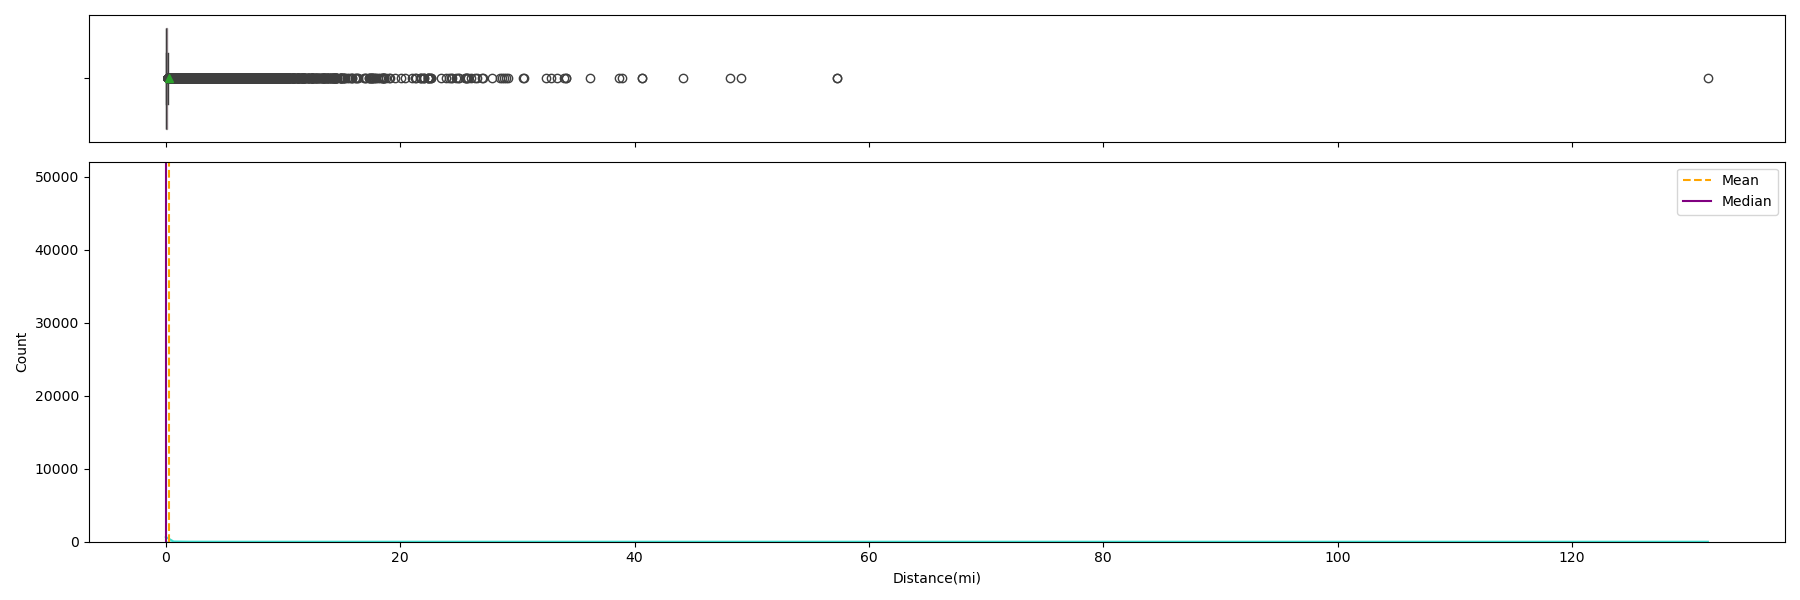

In [42]:
from IPython.display import Image, display

# Distance
display(Image(filename='plots/numerical/Distance(mi).png'))


**Distance(mi):** Most accidents occur within a very short distance, with the distribution peaking sharply at 0 and a long tail of extreme outliers up to ~130 miles. This suggests many incidents are localized or minor in geographic spread.

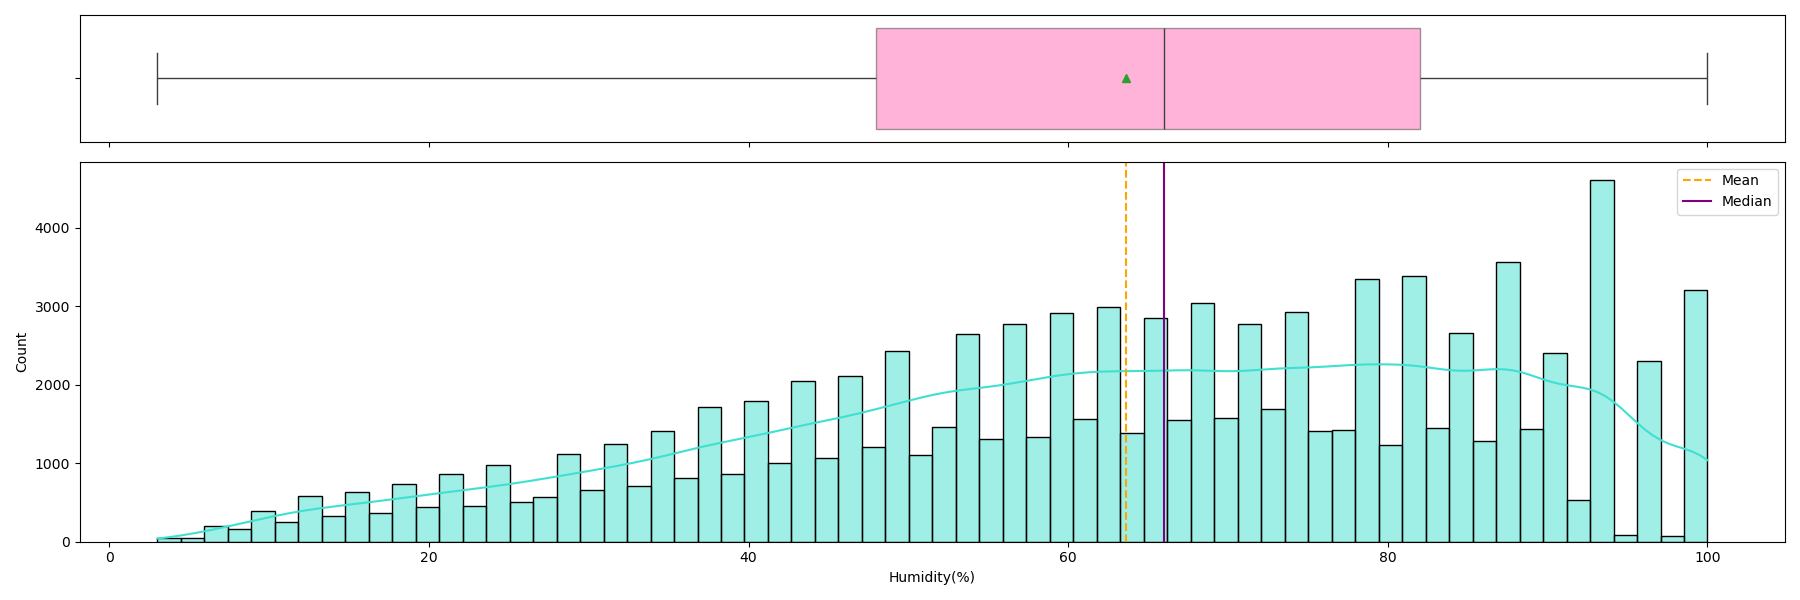

In [43]:
# Humidity
display(Image(filename='plots/numerical/Humidity(%).png'))


**Humidity(%):** Humidity is skewed right with a broad peak between 60–100%, suggesting most accidents happen in fairly humid conditions. A few outliers show very low humidity, possibly corresponding to drier regions or times. **This could signify that driver's behavior is one of the key factors in traffic accidents as high levels of humidity is linked to worse driver's behavior.**

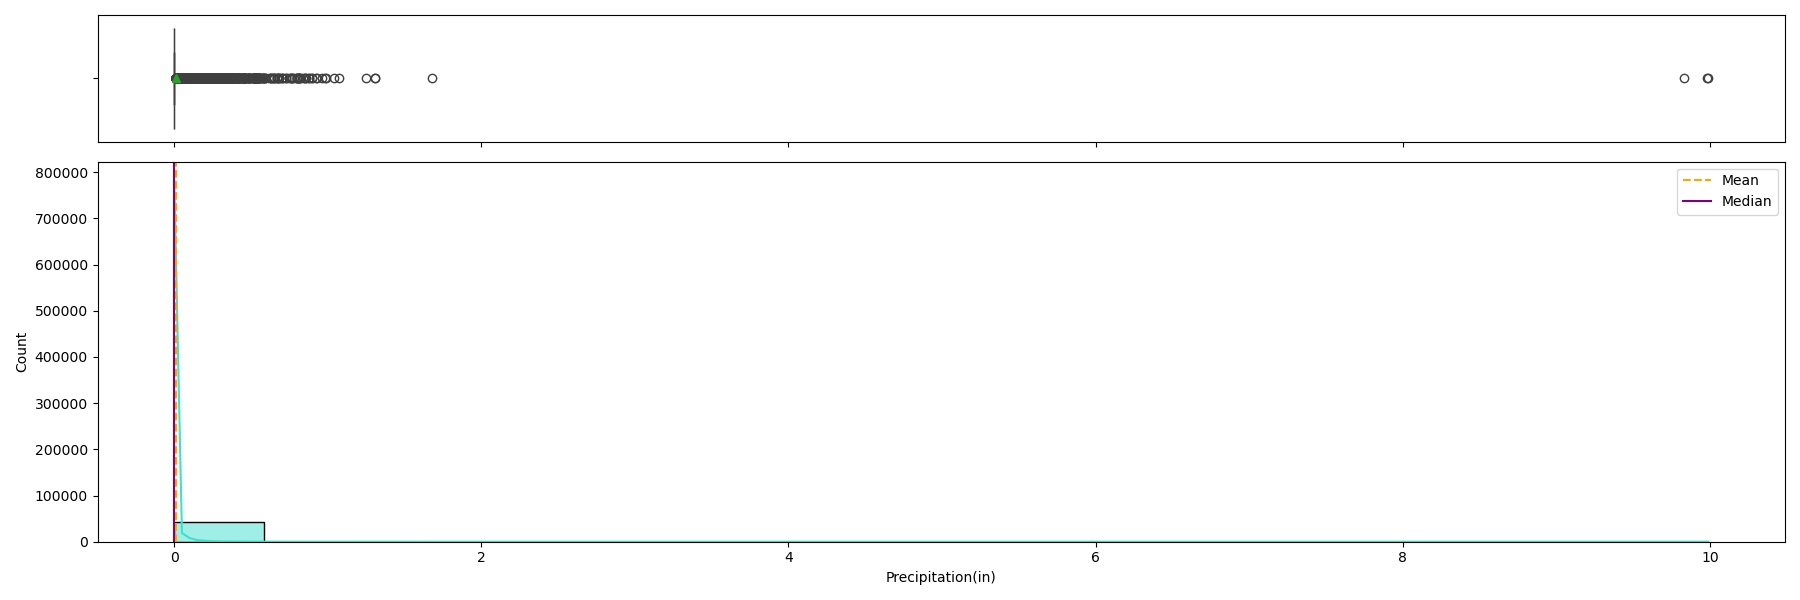

In [44]:
# Precipitation
display(Image(filename='plots/numerical/Precipitation(in).png'))


**Precipitation(in):** Nearly all values are zero, indicating dry conditions dominate. The extreme right-skew and sparse non-zero entries suggest heavy rain or snowfall is rare in the dataset.

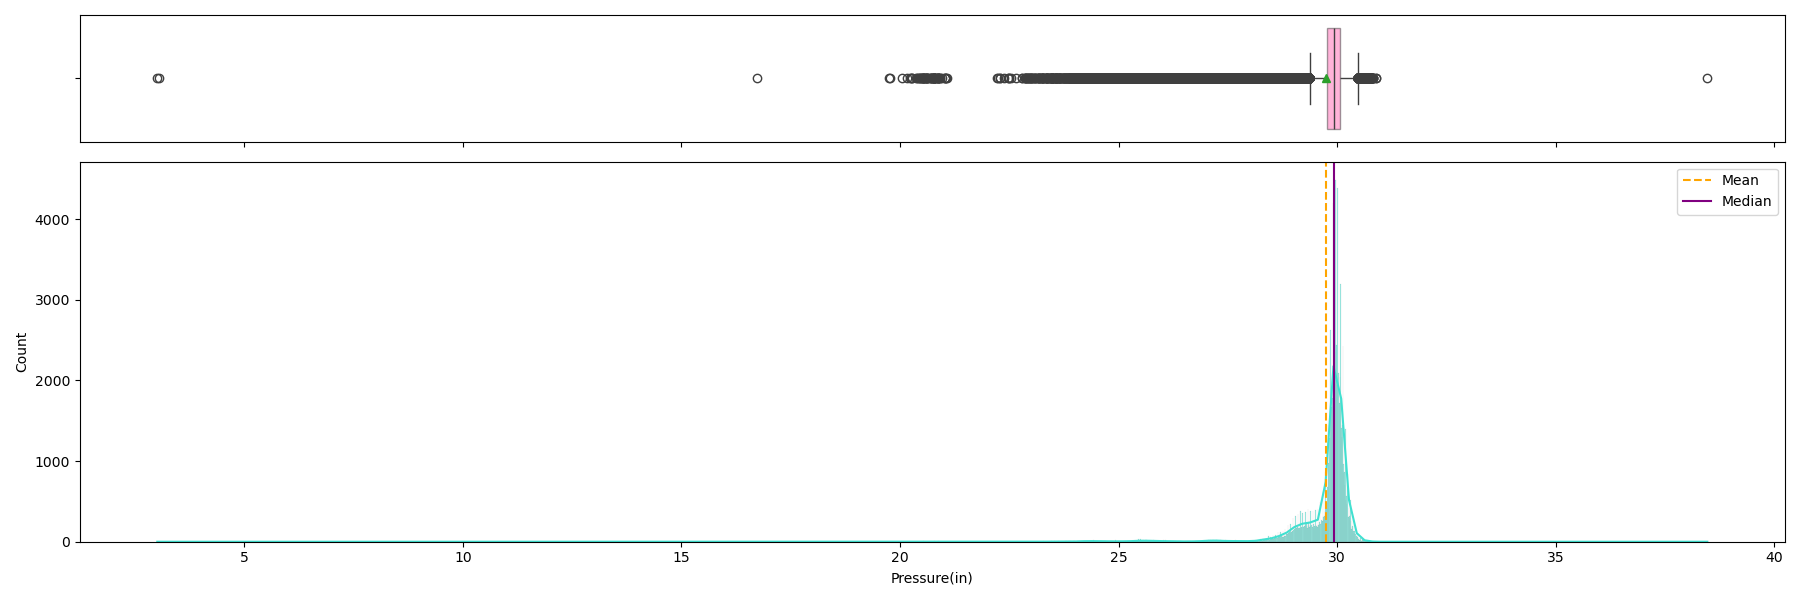

In [45]:
# Pressure
display(Image(filename='plots/numerical/Pressure(in).png'))


**Pressure(in):** Atmospheric pressure is tightly concentrated around 30 inHg, with minimal variance and very few outliers, suggesting limited influence or variability in this parameter.



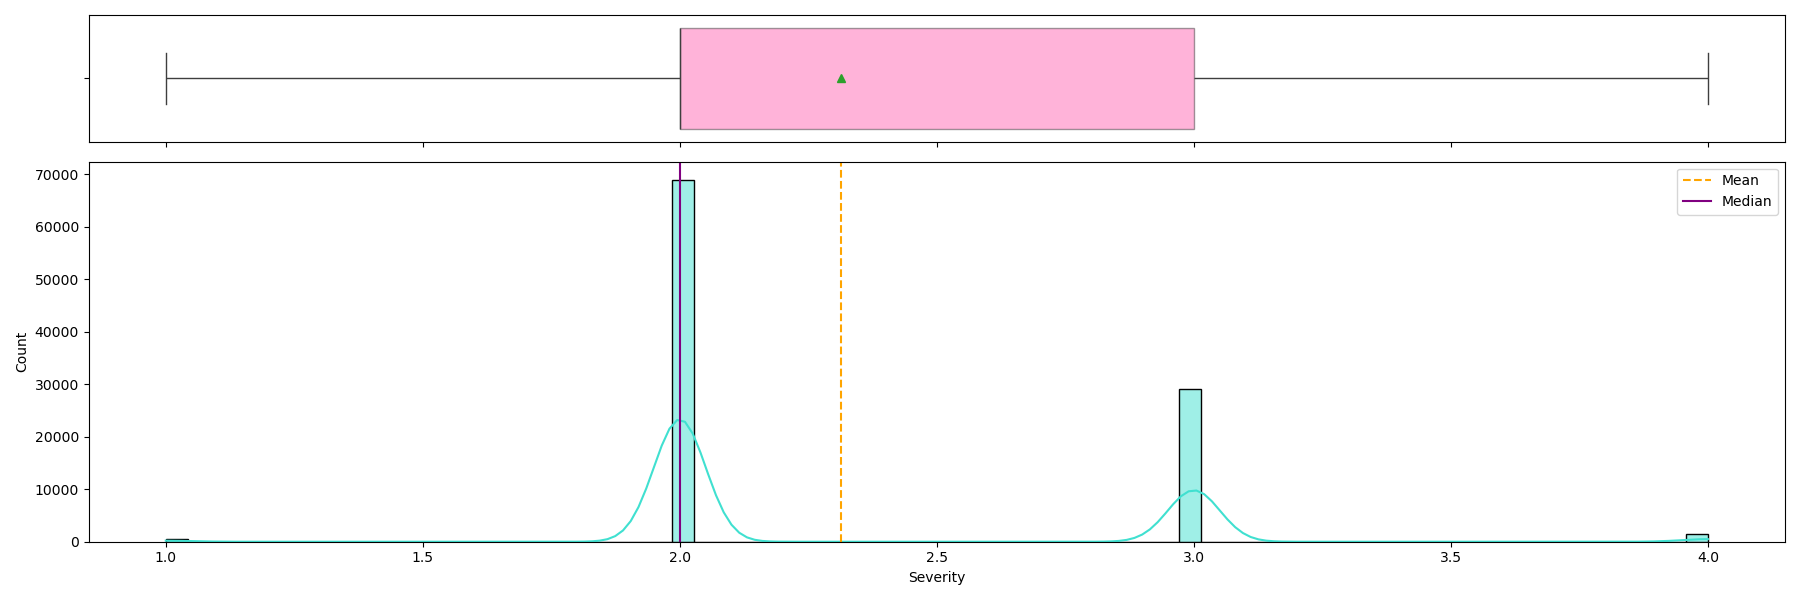

In [46]:
# Severity
display(Image(filename='plots/numerical/Severity.png'))


**Severity:** The severity distribution is highly skewed toward class 2, suggesting that most accidents are moderate. Classes 3 and 4 are rare, indicating fewer severe incidents in the sampled data.

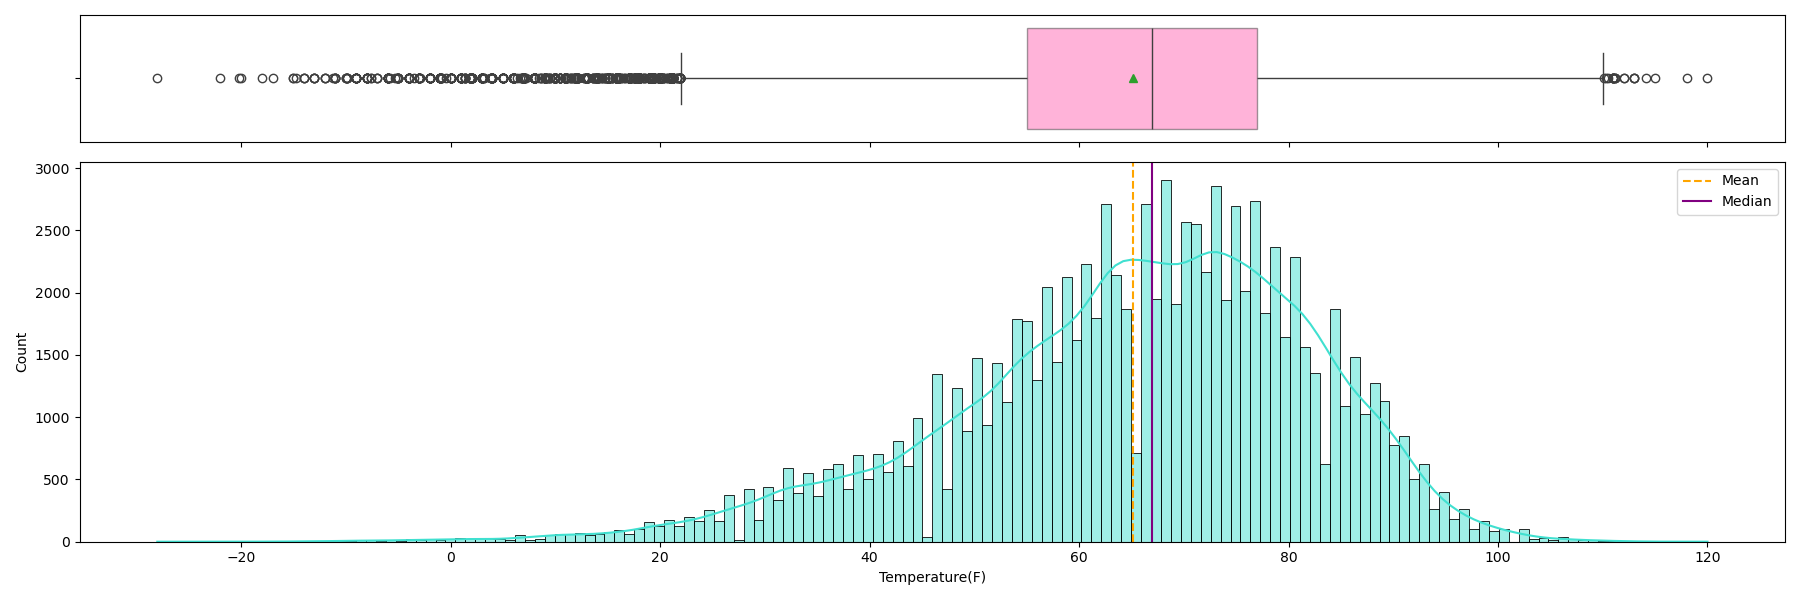

In [47]:
# Temperature
display(Image(filename='plots/numerical/Temperature(F).png'))


**Temperature(F)** Temperature follows a near-normal distribution centered around 66–70°F, with some outliers in both extremes, including below freezing. The balance of mean and median indicates minimal skew.

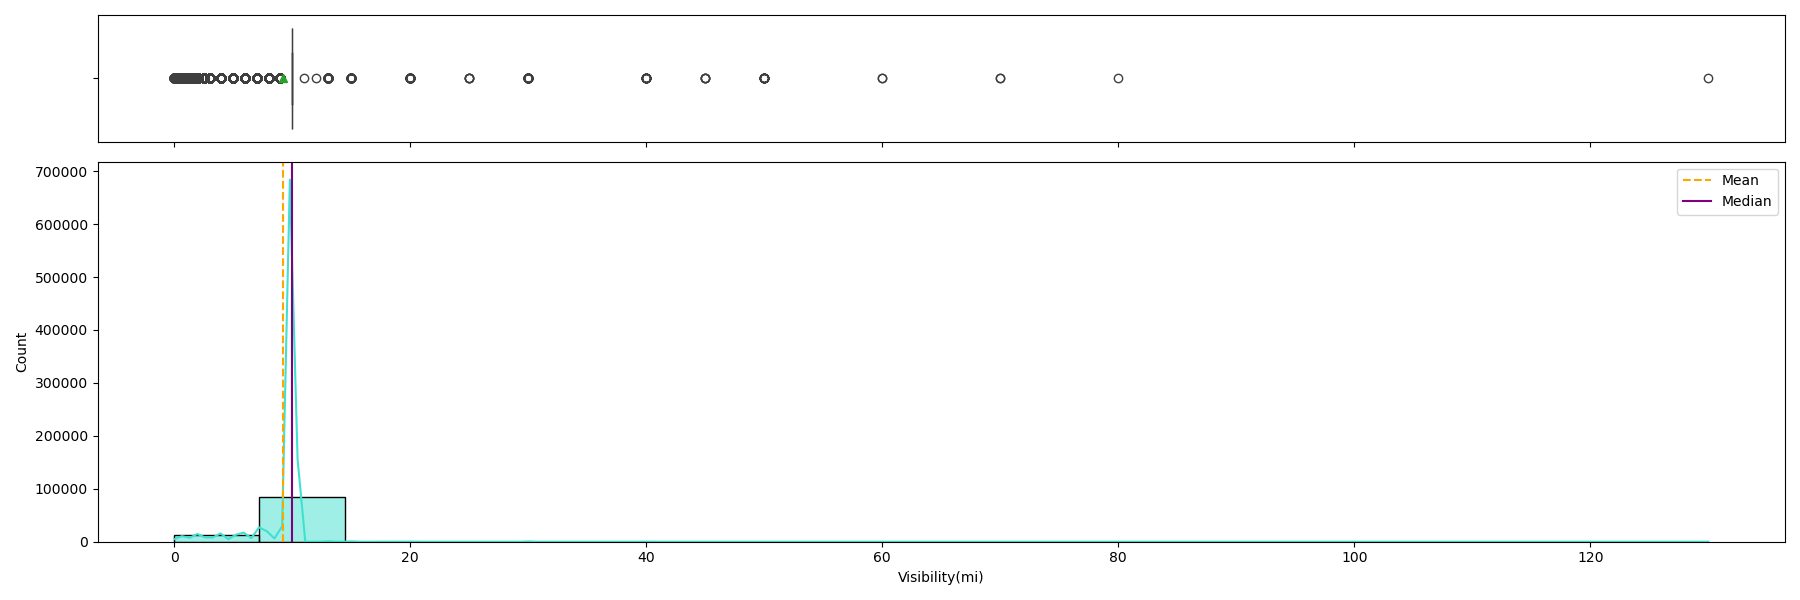

In [48]:
# Visibility
display(Image(filename='plots/numerical/Visibility(mi).png'))


**Visibility(mi):** Visibility is highly right-skewed with most values clustered around 10 miles, indicating that most accidents occur under clear visibility conditions. A few extreme outliers show poor visibility, which may relate to severe weather events. **Traffic accidents also dramatically reduced after 11 miles, which reinforced the idea that high visibility plays a big part in preventing accidents.**

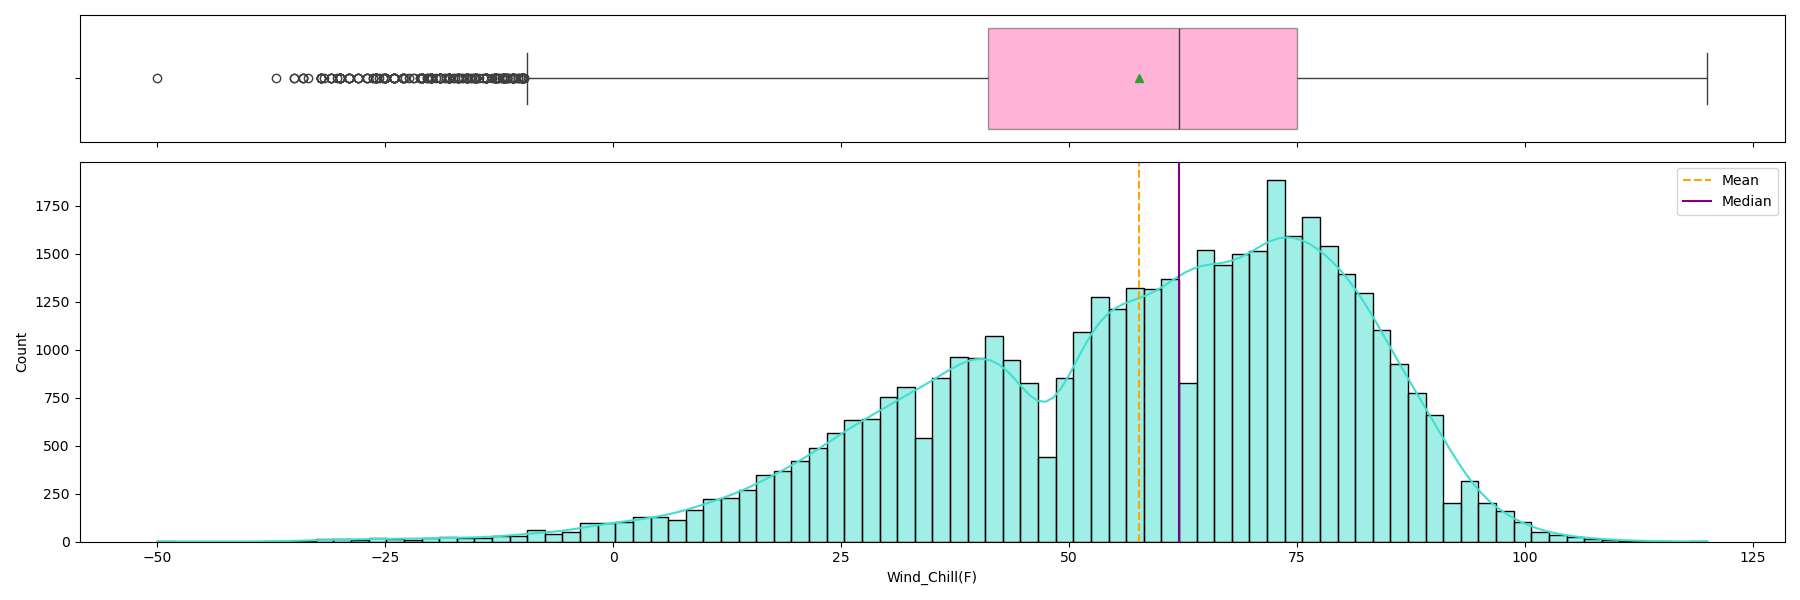

In [49]:
# Wind Chill
display(Image(filename='plots/numerical/Wind_Chill(F).png'))


**Wind_Chill(F):** The distribution resembles a normal curve with a mean around 60–70°F, but includes significant lower outliers, indicating the presence of cold-weather accidents. This variable likely mirrors Temperature(F) in shape.

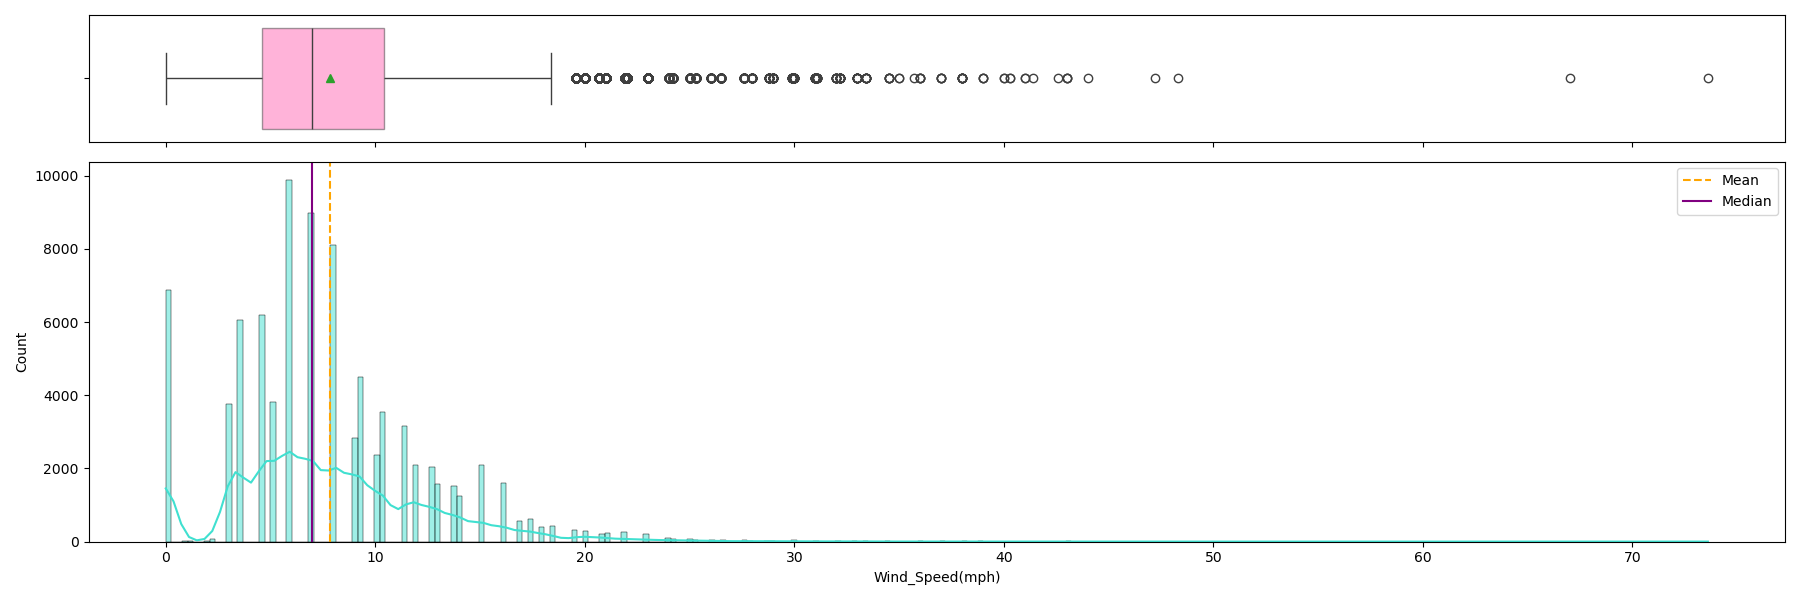

In [50]:
# Wind Speed
display(Image(filename='plots/numerical/Wind_Speed(mph).png'))


**Wind_Speed(mph):** Wind speeds are mostly under 10 mph, but some strong outliers suggest rare high-wind conditions (e.g., storms). The distribution is heavily right-skewed, and mean is higher than median due to outliers.



### Plot Categorical Variables - Frequency Plots

In [53]:
column_info = {
    "ID": "VARCHAR", "Source": "VARCHAR", "Severity": "BIGINT", "Start_Time": "TIMESTAMP",
    "End_Time": "TIMESTAMP", "Start_Lat": "DOUBLE", "Start_Lng": "DOUBLE", "End_Lat": "DOUBLE",
    "End_Lng": "DOUBLE", "Distance(mi)": "DOUBLE", "Description": "VARCHAR", "Street": "VARCHAR",
    "City": "VARCHAR", "County": "VARCHAR", "State": "VARCHAR", "Zipcode": "VARCHAR",
    "Country": "VARCHAR", "Timezone": "VARCHAR", "Airport_Code": "VARCHAR",
    "Weather_Timestamp": "TIMESTAMP", "Temperature(F)": "DOUBLE", "Wind_Chill(F)": "DOUBLE",
    "Humidity(%)": "DOUBLE", "Pressure(in)": "DOUBLE", "Visibility(mi)": "DOUBLE",
    "Wind_Direction": "VARCHAR", "Wind_Speed(mph)": "DOUBLE", "Precipitation(in)": "DOUBLE",
    "Weather_Condition": "VARCHAR", "Amenity": "BOOLEAN", "Bump": "BOOLEAN", "Crossing": "BOOLEAN",
    "Give_Way": "BOOLEAN", "Junction": "BOOLEAN", "No_Exit": "BOOLEAN", "Railway": "BOOLEAN",
    "Roundabout": "BOOLEAN", "Station": "BOOLEAN", "Stop": "BOOLEAN", "Traffic_Calming": "BOOLEAN",
    "Traffic_Signal": "BOOLEAN", "Turning_Loop": "BOOLEAN", "Sunrise_Sunset": "VARCHAR",
    "Civil_Twilight": "VARCHAR", "Nautical_Twilight": "VARCHAR", "Astronomical_Twilight": "VARCHAR"
}

df_types = pd.DataFrame(column_info.items(), columns=["column_name", "column_type"])

In [55]:
categorical_cols = df_types[df_types['column_type'].isin(['VARCHAR', 'BOOLEAN'])]['column_name'].tolist()
temporal_cols = df_types[df_types['column_type'] == 'TIMESTAMP']['column_name'].tolist()
geospatial_cols = [col for col in numerical_cols if 'Lat' in col or 'Lng' in col]


#### Plot the Categorical Variables

In [58]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Create directory for saving categorical plots
os.makedirs('plots/categorical', exist_ok=True)

def plot_categorical_distributions(df, cat_cols, top_n=20):
    """
    Plot and save frequency plots for each categorical variable.

    Args:
        df: DataFrame
        cat_cols: List of categorical column names
        top_n: Number of top frequent categories to show
    """
    for col in cat_cols:
        plt.figure(figsize=(12, 5))
        # Plot top N categories for readability
        order = df[col].value_counts().head(top_n).index
        sns.countplot(data=df, x=col, order=order, palette='Set2')
        plt.xticks(rotation=45, ha='right')
        plt.title(f"Frequency Plot - {col}")
        plt.tight_layout()

        # Save the plot
        filename = f"plots/categorical/{col}.png"
        plt.savefig(filename)
        plt.close()

# Example usage:
# Make sure you already have df_sample and categorical_cols defined
plot_categorical_distributions(df_sample, categorical_cols)


/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_68557/2206436898.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=order, palette='Set2')
/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_68557/2206436898.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=order, palette='Set2')
/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_68557/2206436898.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=order, palette='Set2')
/var/folders/gw/b7p

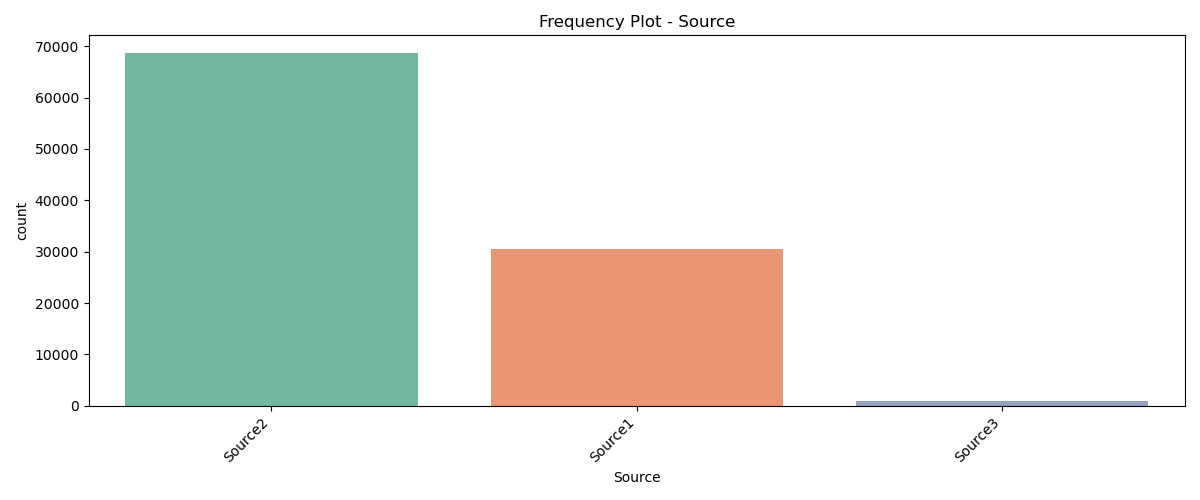

In [60]:
from IPython.display import Image, display

display(Image(filename='plots/categorical/Source.png'))


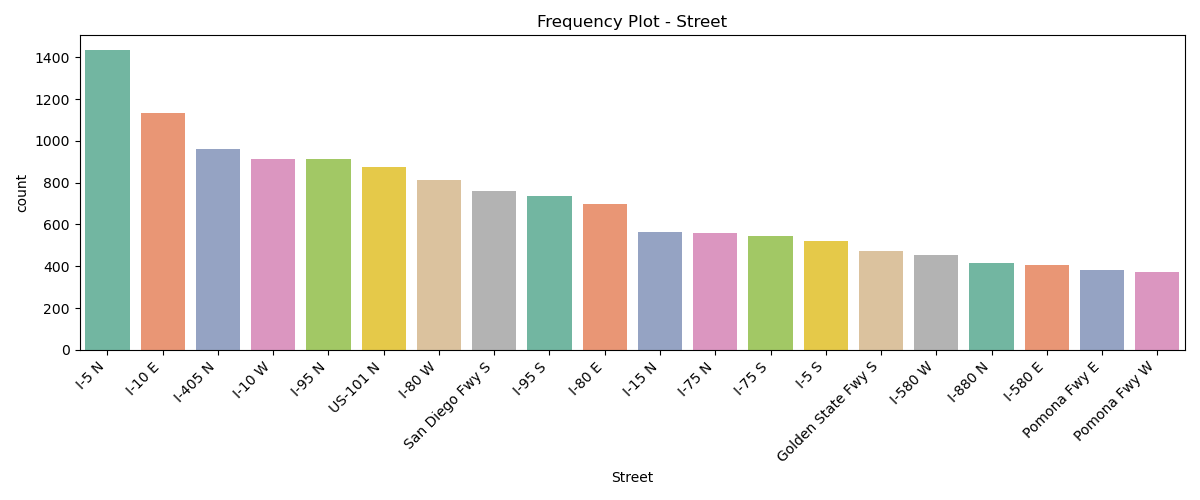

In [61]:
display(Image(filename='plots/categorical/Street.png'))


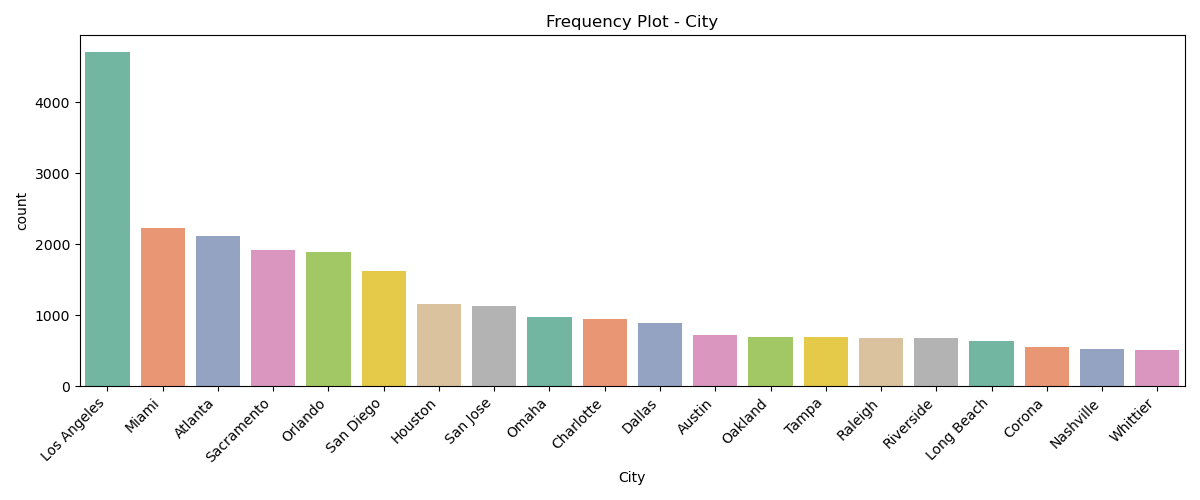

In [62]:
display(Image(filename='plots/categorical/City.png'))


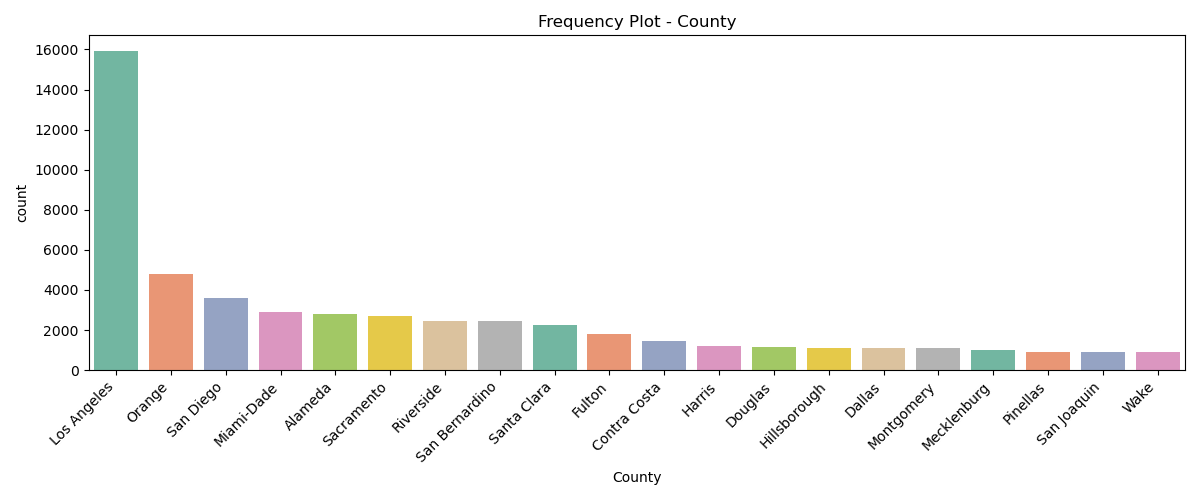

In [63]:
display(Image(filename='plots/categorical/County.png'))


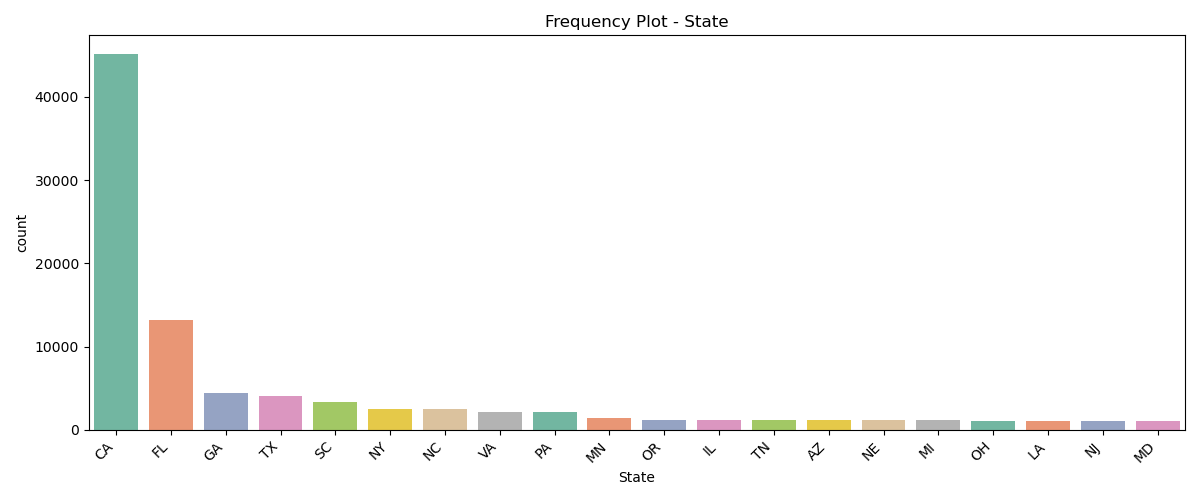

In [64]:
display(Image(filename='plots/categorical/State.png'))


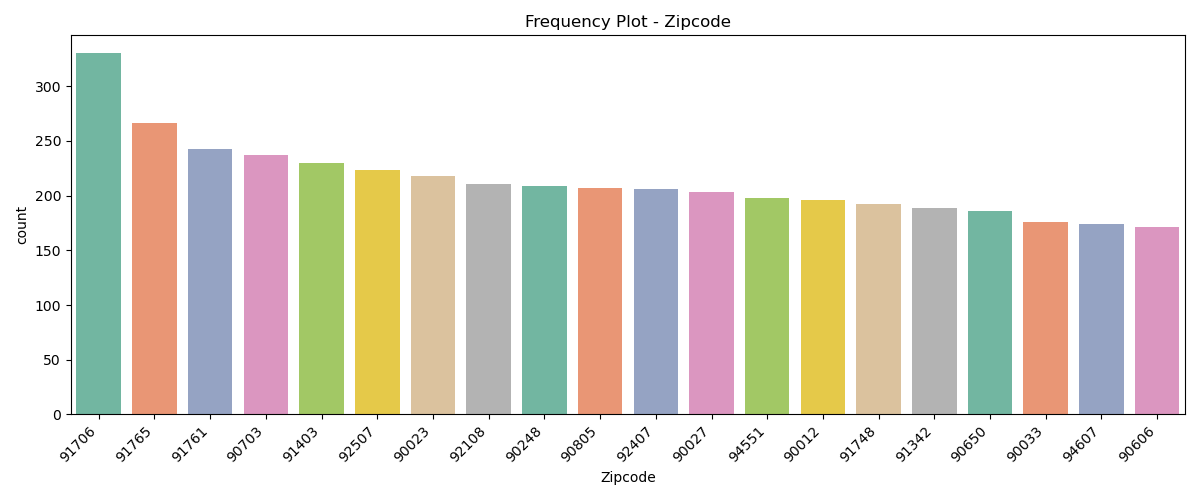

In [65]:
display(Image(filename='plots/categorical/Zipcode.png'))


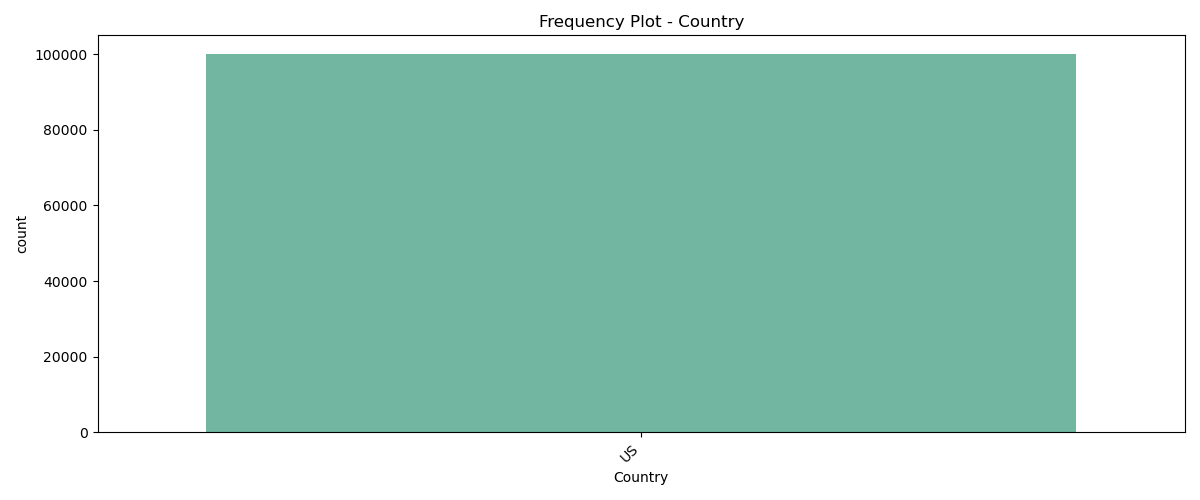

In [66]:
display(Image(filename='plots/categorical/Country.png'))


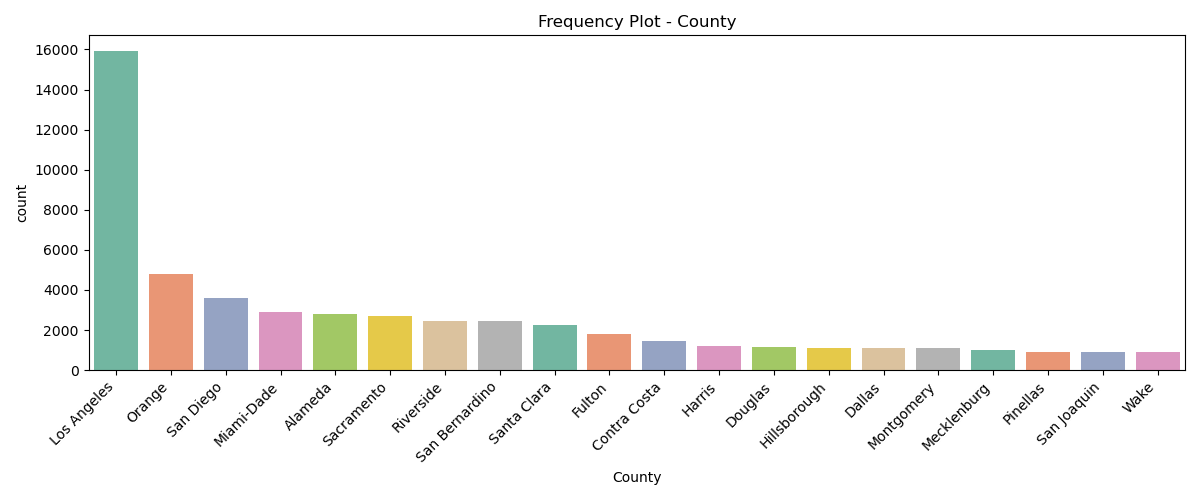

In [75]:
display(Image(filename='plots/categorical/County.png'))


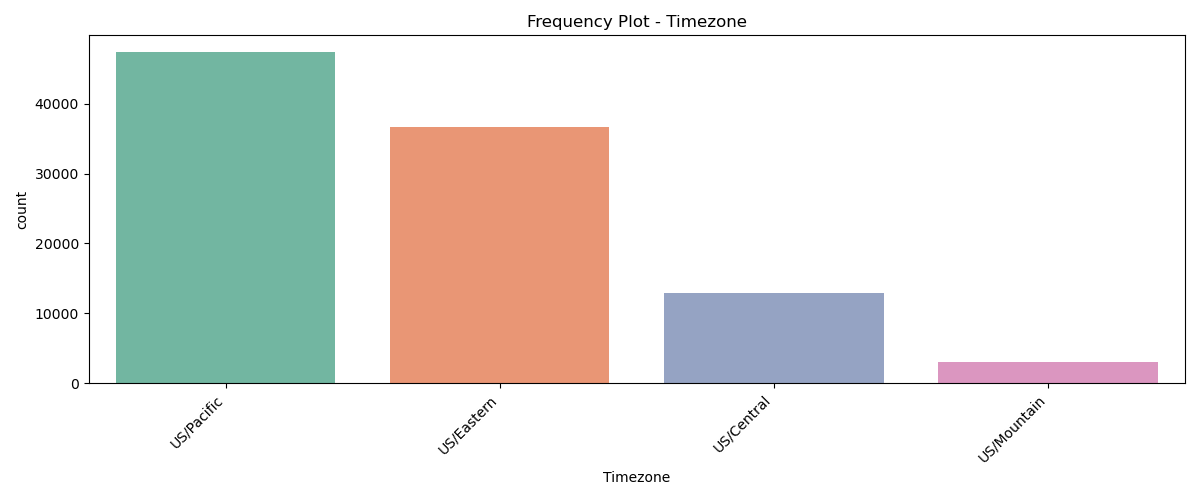

In [67]:
display(Image(filename='plots/categorical/Timezone.png'))


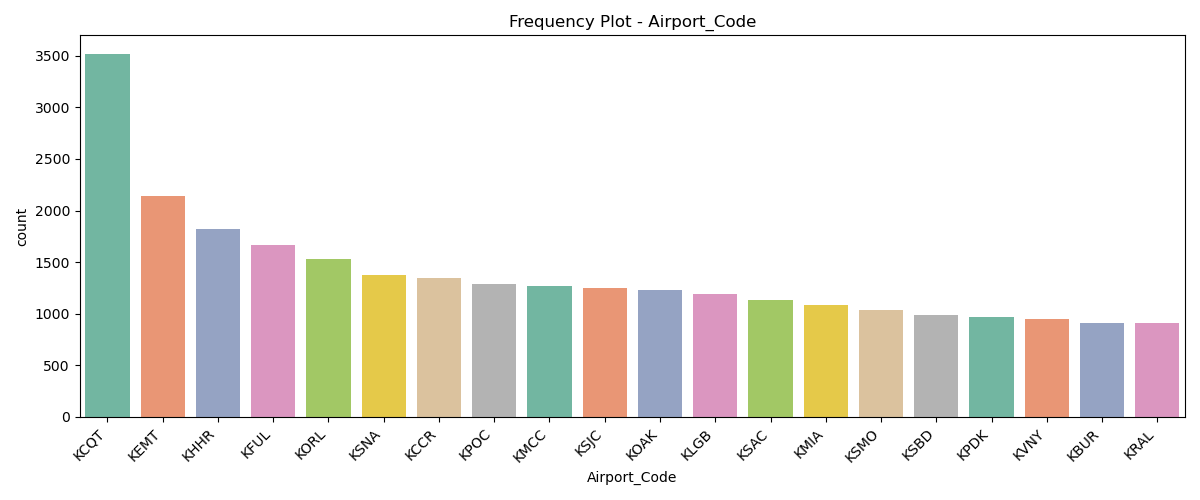

In [68]:
display(Image(filename='plots/categorical/Airport_Code.png'))


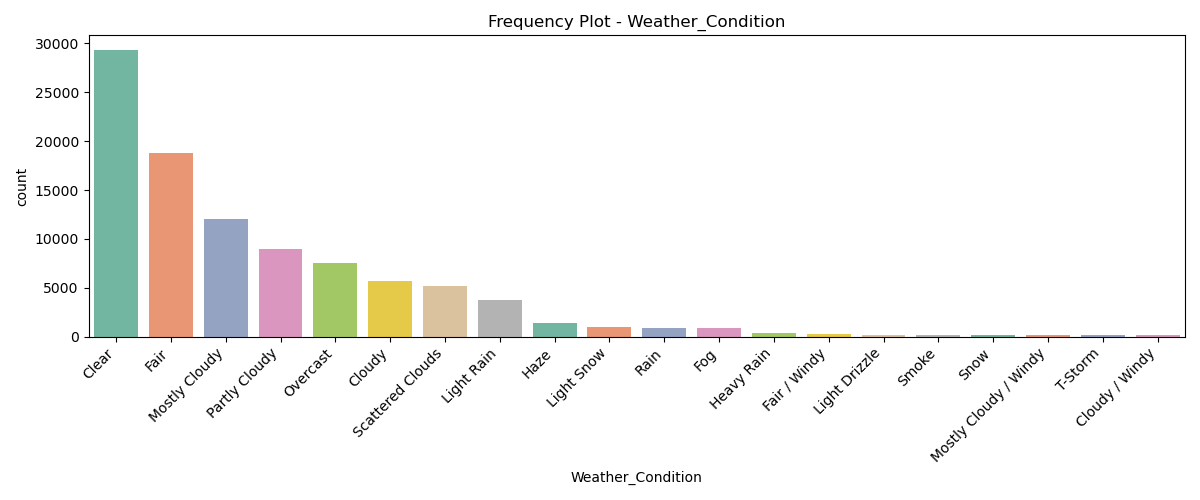

In [69]:
display(Image(filename='plots/categorical/Weather_Condition.png'))


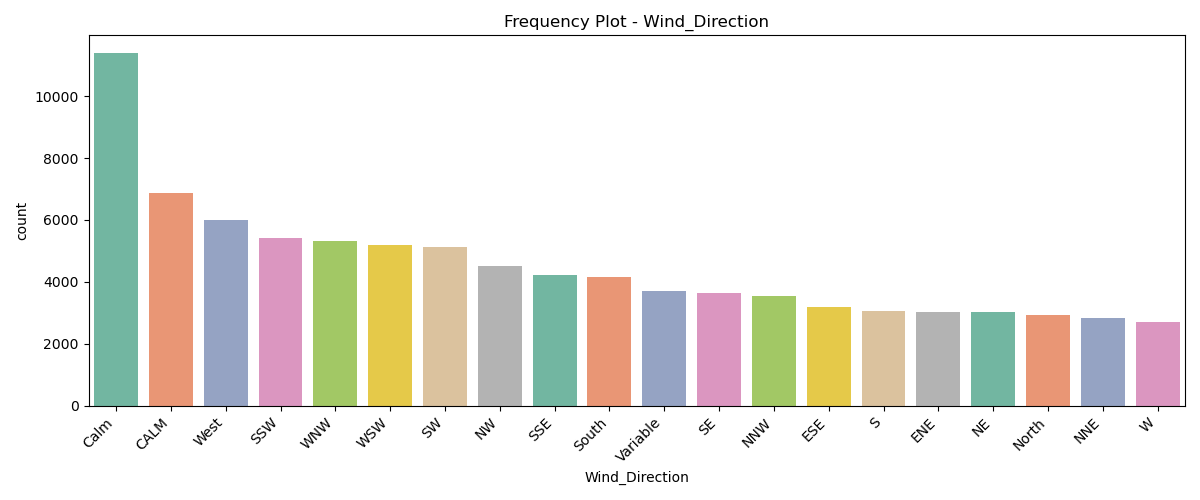

In [70]:
display(Image(filename='plots/categorical/Wind_Direction.png'))


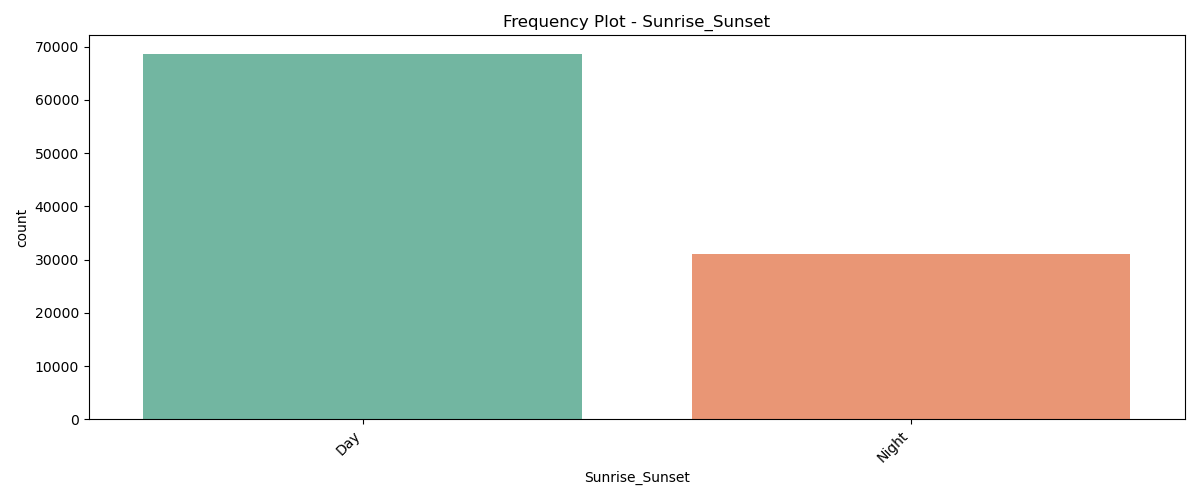

In [71]:
display(Image(filename='plots/categorical/Sunrise_Sunset.png'))


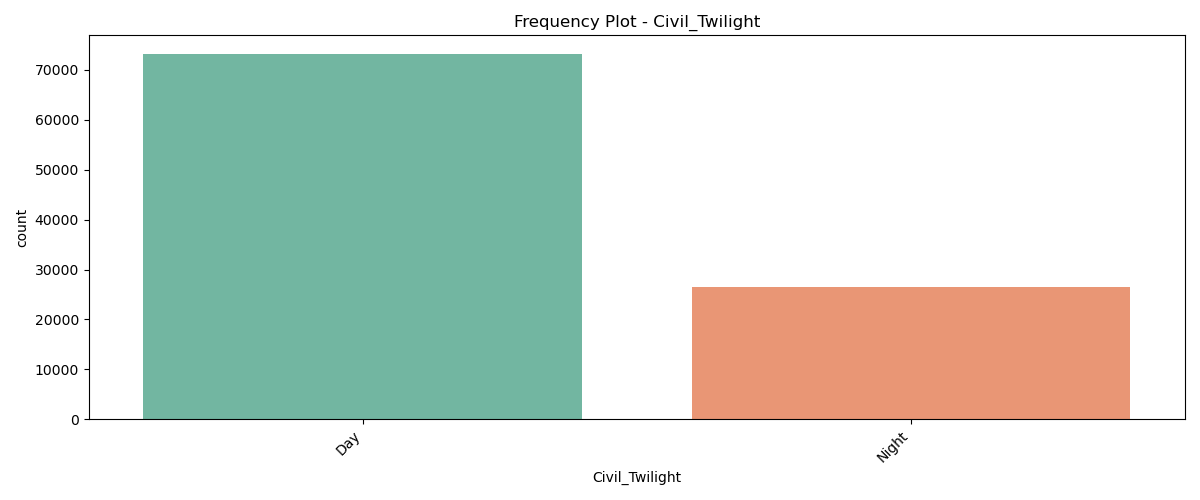

In [72]:
display(Image(filename='plots/categorical/Civil_Twilight.png'))


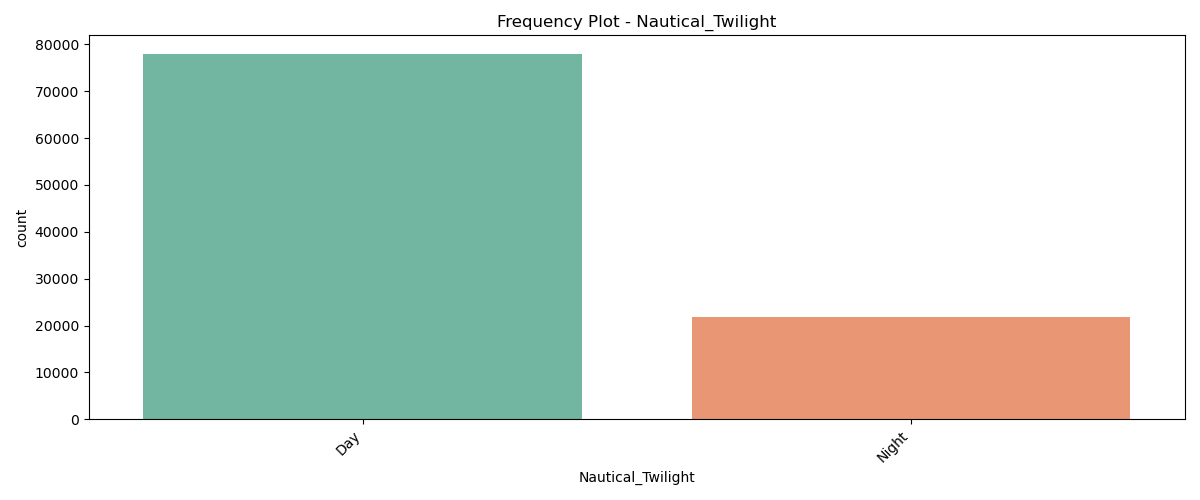

In [73]:
display(Image(filename='plots/categorical/Nautical_Twilight.png'))


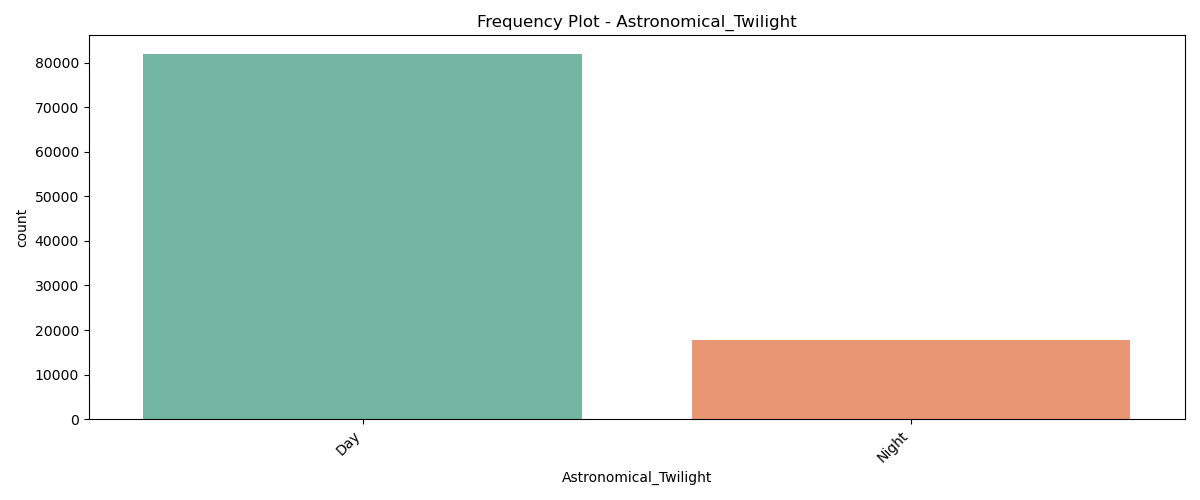

In [74]:
display(Image(filename='plots/categorical/Astronomical_Twilight.png'))


### Categorical Variable Analysis – Key Observations

**Airport_Code:** The top contributing airport is **KCQT**, followed by **KEMT and KHR**. These likely represent airports from heavily populated regions with extensive traffic monitoring.

**Weather Conditions:** The plot shows that the majority of accidents occur during **clear or fair weather** conditions, which together account for a significant portion of all incidents. This suggests that good weather does not necessarily prevent accidents, possibly due to higher traffic volume or driver complacency. While severe conditions like **rain, snow, fog, and thunderstorms** are less frequent, they still contribute to a **notable number of accident**s and may be associated with higher severity or complexity.

**Wind Conditions:** The plot shows that most accidents occur when wind conditions are reported as **"Calm"** or "CALM", suggesting that wind direction is generally not a major contributing factor to accidents. Accidents are more frequent during low or stable wind conditions, with no single directional wind pattern standing out significantly.

**Astronomical_Twilight, Nautical_Twilight, and Civil_Twilight:** All three show a similar distribution, with the majority of accidents occurring during the **daytime**, indicating higher traffic volume and exposure during daylight hours.

**City: Los Angeles** stands out prominently with the highest number of accidents, followed by **Miami, Atlanta, and Sacramento**. This reflects the high population density and traffic congestion in these urban centers.

**Country:** All accidents are reported within the United States, as expected. The variable Country does not add variability and can likely be dropped in modeling.

**County**: The county-level distribution closely mirrors the city-level pattern. **Los Angeles County** again dominates, reaffirming the city-level trend.

**Source**: **Source2** is the **dominant contributor** to the dataset, suggesting that data collection is heavily skewed toward one reporting service. This may introduce reporting bias and should be considered in any further modeling or analysis.

**State:** **California (CA**) accounts for the largest share of accidents by a wide margin, followed by **Florida (FL)** and **Georgia (GA)**. The steep drop-off after these suggests substantial geographic concentration in data reporting or actual accident rates.

**Street**: Streets like **I-5 N, I-10 E,** and **I-405 N** are most frequently associated with accidents. These are all major highways, indicating that **interstates may have higher incidence rates or better reporting systems**.

### Plot the Temporal and Geospatial Variables

#### Create Directories

In [76]:
import os

os.makedirs("plots/temporal", exist_ok=True)
os.makedirs("plots/geospatial", exist_ok=True)


#### Function: Plot & Save Temporal Variables

In [77]:
def plot_temporal_distributions(df, temporal_cols):
    for col in temporal_cols:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            plt.figure(figsize=(10, 4))
            df[col].dt.hour.value_counts().sort_index().plot(kind='bar', color='mediumseagreen')
            plt.title(f'Distribution of Accidents by Hour - {col}')
            plt.xlabel('Hour of Day')
            plt.ylabel('Accident Count')
            plt.tight_layout()
            plt.savefig(f'plots/temporal/{col}.png')
            plt.close()


#### Function: Plot & Save Geospatial Variables

In [78]:
import seaborn as sns

def plot_geospatial_distributions(df, lat_col, lng_col, suffix):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=lng_col, y=lat_col, s=5, alpha=0.3)
    plt.title(f'Geospatial Scatter Plot of {suffix} Coordinates')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.savefig(f'plots/geospatial/{suffix}_Coordinates.png')
    plt.close()


#### Apply to My Data

In [79]:
plot_temporal_distributions(df_sample, temporal_cols)

plot_geospatial_distributions(df_sample, 'Start_Lat', 'Start_Lng', 'Start')
plot_geospatial_distributions(df_sample, 'End_Lat', 'End_Lng', 'End')

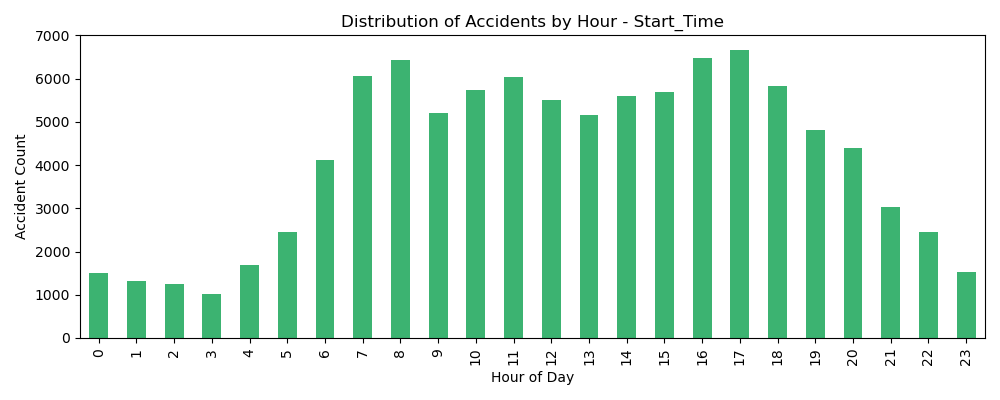

In [81]:
from IPython.display import Image, display

display(Image(filename='plots/temporal/Start_Time.png'))

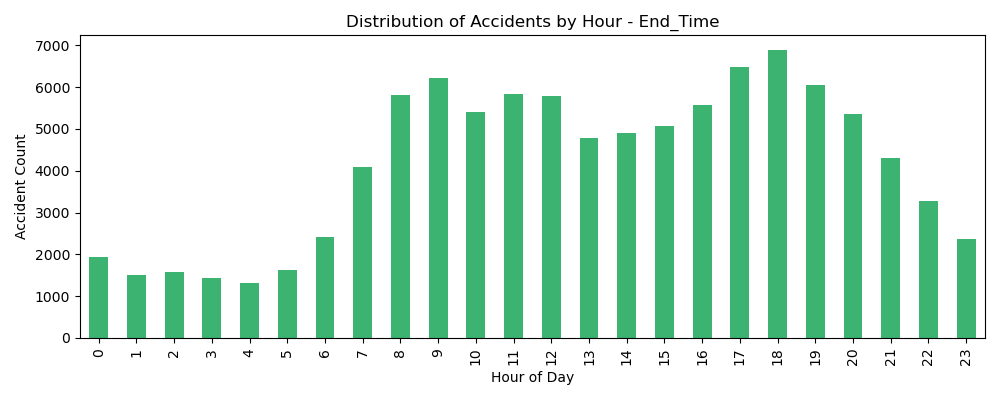

In [82]:
display(Image(filename='plots/temporal/End_Time.png'))

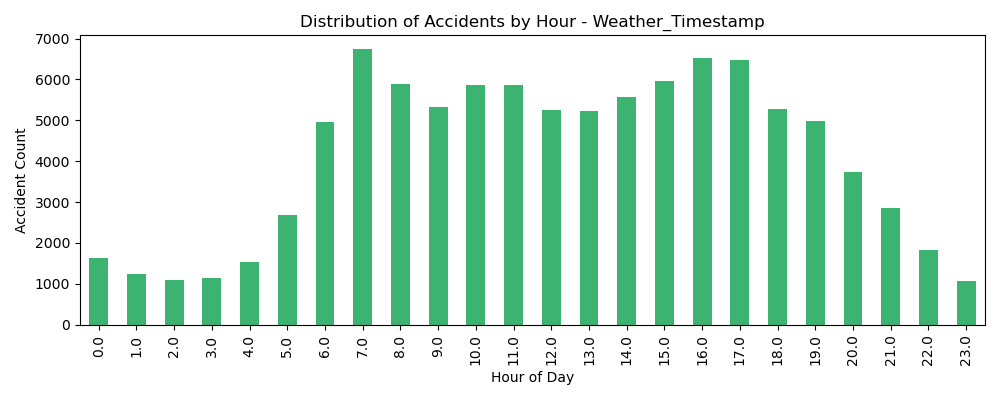

In [83]:
display(Image(filename='plots/temporal/Weather_Timestamp.png'))


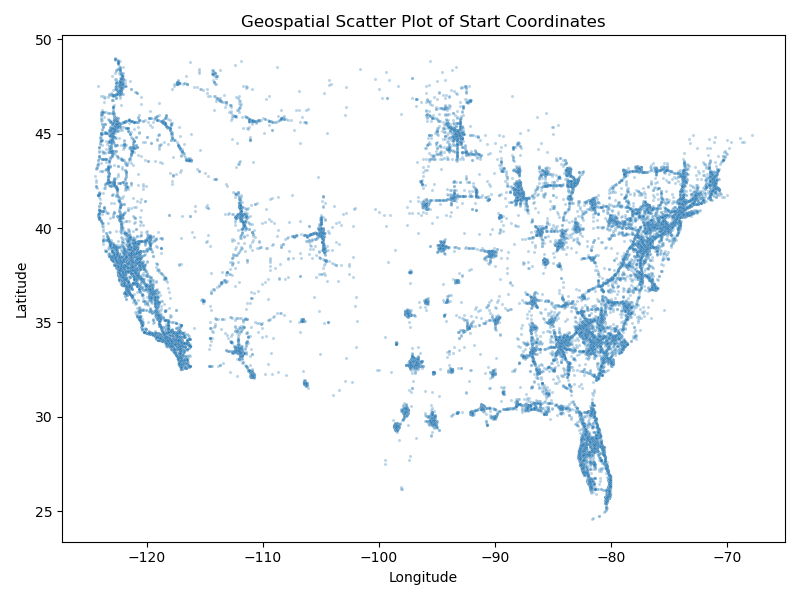

In [85]:
from IPython.display import Image, display

display(Image(filename='plots/geospatial/Start_Coordinates.png'))


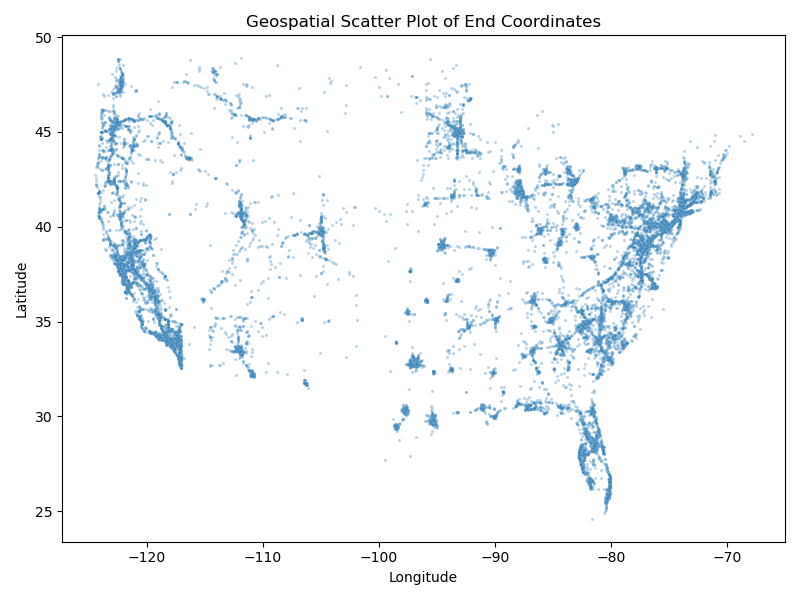

In [86]:
display(Image(filename='plots/geospatial/End_Coordinates.png'))


### Temporal and Geospatial Data Insights

### Temporal Variables:

**Start_Time and End_Time** show similar hourly distributions. Accidents peak around **7–9 AM** and again from **4–6 PM**, aligning with typical rush hours, which highlights commuting traffic risks.

**Weather_Timestamp** also follows a similar trend with a sharp increase in accidents starting from **6 AM**, peaking between **7–9 AM** and **3–5 PM**. This indicates that weather conditions are often logged around the same time accidents tend to happen, potentially supporting causality analyses.

### Geospatial Variables:

The **Start_Coordinates and End_Coordinates** scatter plots show that accidents are **densely clustered in urban regions**, especially in the **East Coast, California, Texas, and Florida**.

The **West Coast (California), Northeast Corridor (New York, New Jersey, Pennsylvania), and Florida show particularly high concentrations**, likely reflecting both population density and traffic volume.

The spatial alignment between start and end coordinates also indicates consistent location reporting and minor displacement during incident logging.

### Analysis by Traffic nature

This section explores patterns based on traffic characteristics, such as identifying situations where accidents are more prevalent, such as at traffic signals, crossings, junctions, and stops. The analysis then delves into the specificities of the three most accident prone states (California, Texas, and Florida) to find out any differences.

In [89]:
# Identify boolean columns in the dataset
boolean_columns = df_sample.select_dtypes(include='bool').columns.tolist()
print("Boolean Columns:", boolean_columns)


Boolean Columns: ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']


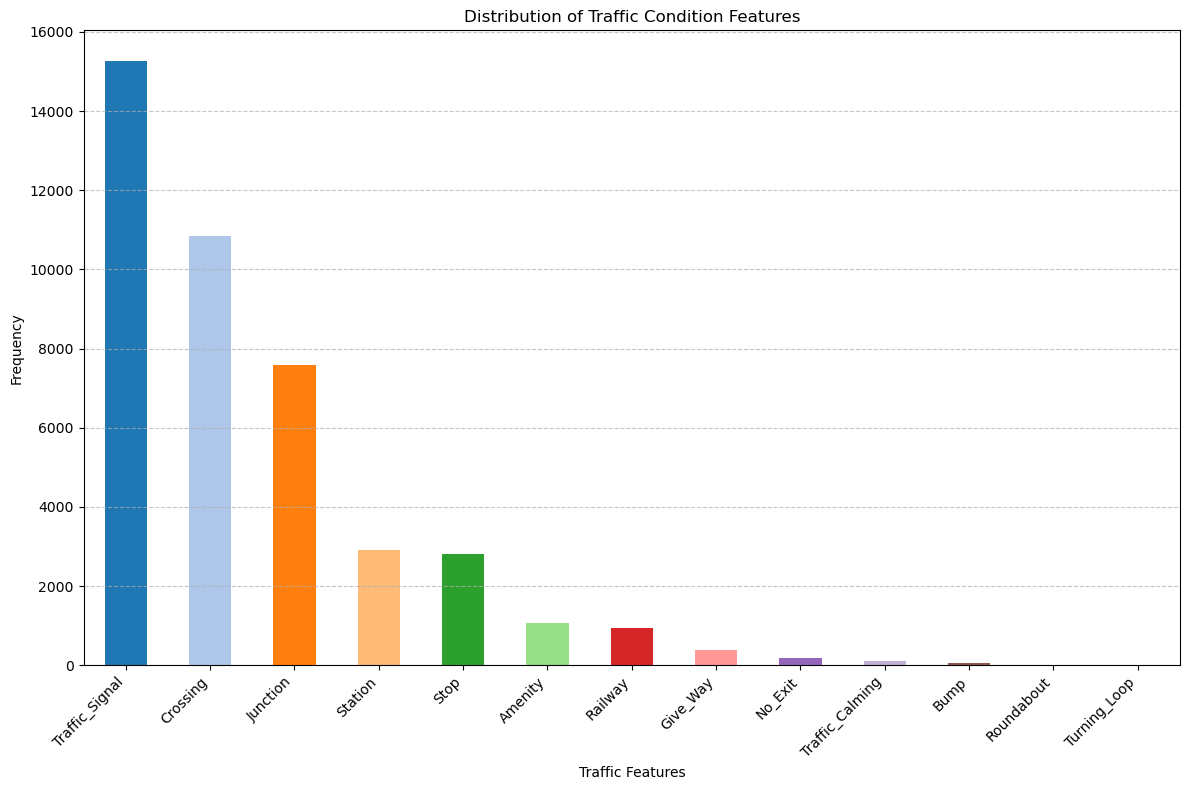

In [90]:
import matplotlib.pyplot as plt

# Bar chart for boolean traffic condition features
plt.figure(figsize=(12, 8))
df_sample[boolean_columns].sum().sort_values(ascending=False).plot(
    kind='bar', 
    color=plt.get_cmap('tab20')(range(len(boolean_columns)))
)
plt.title('Distribution of Traffic Condition Features')
plt.xlabel('Traffic Features')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/categorical/Traffic_Conditions.png')
plt.show()


**Observations:** The plot shows that the most common traffic-related features in US accidents are **Traffic Signals, Crossings, and Junctions**, suggesting that intersections and pedestrian areas are key hotspots for accidents. Features like **Bumps, Roundabouts, and Turning Loops** appear very infrequently, indicating they are less commonly associated with reported incidents. This distribution highlights the importance of monitoring and improving safety measures at high-traffic control points.

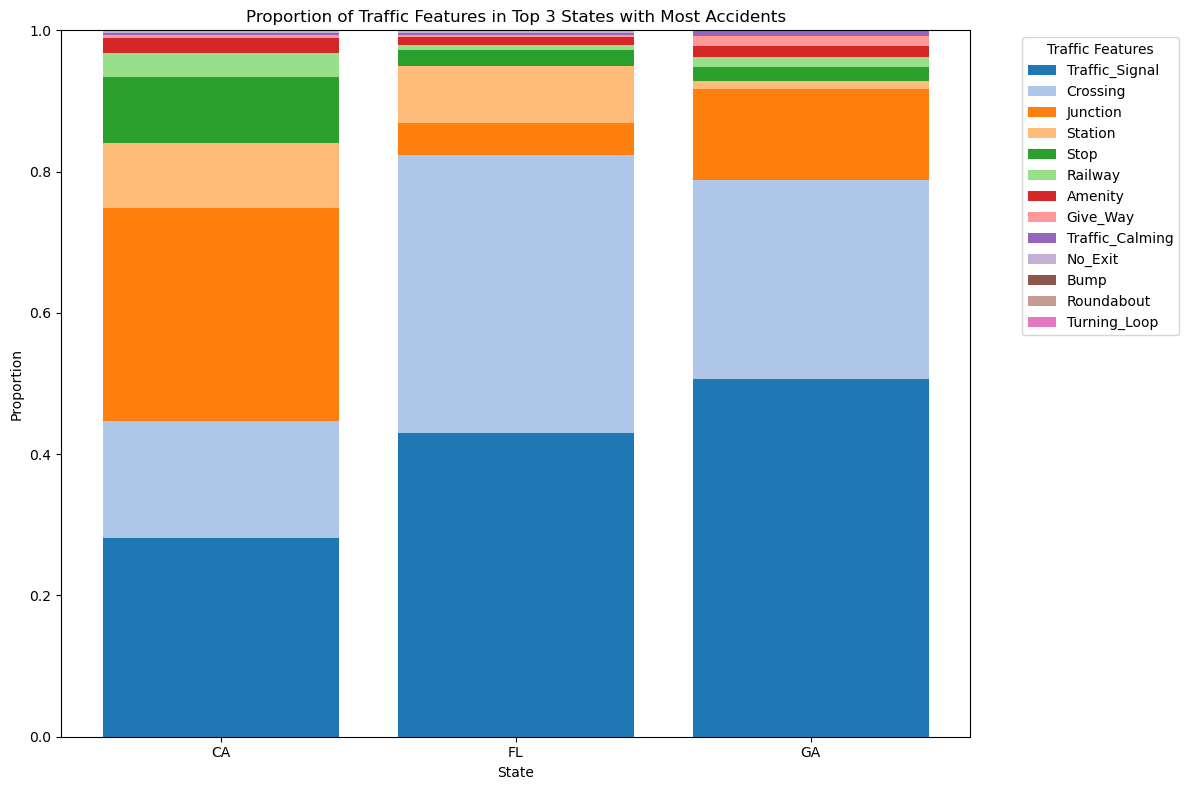

In [93]:
#Identifying the most common traffic conditions in the states with the highest accident rates


import matplotlib.pyplot as plt
import pandas as pd

# Identify top 3 states with the most accidents
top_states = df_sample['State'].value_counts().head(3).index
top_states_data = df_sample[df_sample['State'].isin(top_states)]

# Define binary traffic features
traffic_features = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
                    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
                    'Traffic_Signal', 'Turning_Loop']

# Sum of each traffic feature per top state
feature_counts = pd.DataFrame({
    feature: top_states_data.groupby('State')[feature].sum() for feature in traffic_features
})

# Convert to relative proportions (each state's values sum to 1)
feature_proportions = feature_counts.div(feature_counts.sum(axis=1), axis=0)

# Sort features by total count across all states (for consistent color & stacking order)
sorted_features = feature_counts.sum().sort_values(ascending=False).index

# Assign colors
color_map = plt.get_cmap('tab20')(range(len(sorted_features)))
feature_colors = {feature: color_map[i] for i, feature in enumerate(sorted_features)}

# Plot stacked bar chart (proportional)
plt.figure(figsize=(12, 8))
bottom = pd.Series(0, index=feature_proportions.index)

for feature in sorted_features:
    plt.bar(feature_proportions.index, feature_proportions[feature], 
            bottom=bottom, label=feature, color=feature_colors[feature])
    bottom += feature_proportions[feature]

plt.title('Proportion of Traffic Features in Top 3 States with Most Accidents')
plt.xlabel('State')
plt.ylabel('Proportion')
plt.legend(title='Traffic Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig("plots/categorical/traffic_features_stacked_relative.png", dpi=300)
plt.show()


**Observations:** The plot illustrates the relative distribution of traffic-related features in the top three U.S. states with the highest accident frequencies: **California (CA), Florida (FL), and Georgia (GA)**. In all three states, **Traffic Signals and Crossings** dominate the accident contexts, with **Georgia** showing the highest proportion of accidents occurring near **traffic signals**. **California** stands out with a notably higher share of accidents at **junctions** compared to the other two states.

### Explore Three Most Accident Prone States

In [96]:
#Filtering the Accidents in California By City
accidents_california = df_sample[df_sample['State'] == 'CA']

#Filtering the top 5 cities in California with most Accidents
accidents_by_city_california = accidents_california['City'].value_counts().head(5)

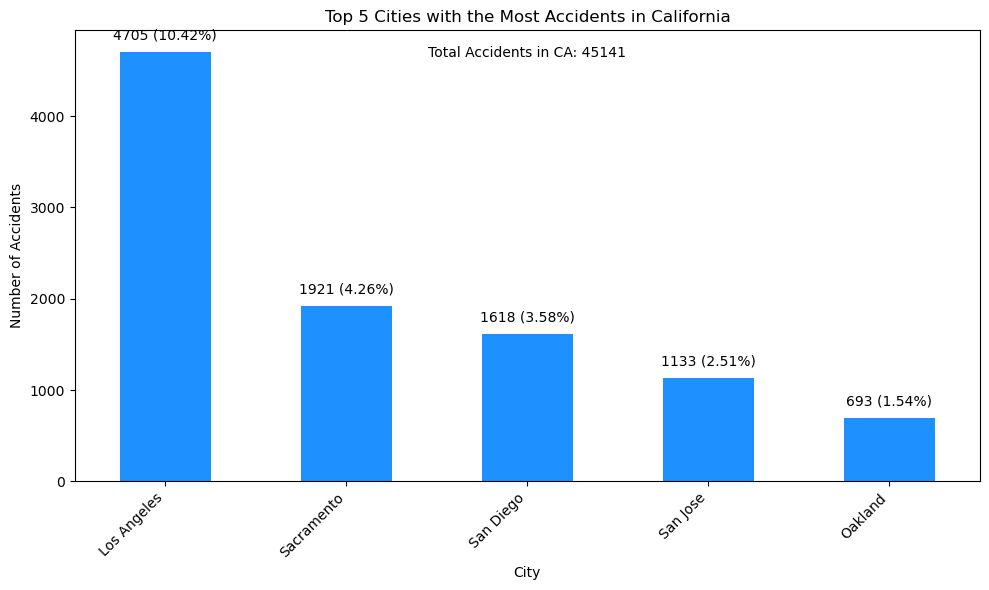

In [107]:
# Calculate the total percentage of accidents in California
total_accidents_california = len(accidents_california)
percentage_california = total_accidents_california / len(df_sample) * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
accidents_by_city_california.plot(kind='bar', color='dodgerblue')



# Set the title and axis labels
plt.title('Top 5 Cities with the Most Accidents in California')
plt.xlabel('City')
plt.ylabel('Number of Accidents')

# Add the count and percentage to the label above each bar
for x, y in enumerate(accidents_by_city_california):
    plt.text(x, y + 100, f'{y} ({(y / total_accidents_california * 100):.2f}%)',
             ha='center', va='bottom')
    # Add the total percentage to the label
plt.text(0.5, 0.95, f'Total Accidents in CA: {total_accidents_california}',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the bar plot
plt.tight_layout()
plt.savefig("plots/categorical/top_5_accident_prone_cities_California.png", dpi=300)
plt.show()

In [99]:
#Filtering the Accidents in Florida By City
accidents_florida = df_sample[df_sample['State'] == 'FL']

#Filtering the top 5 cities in California with most Accidents
accidents_by_city_florida = accidents_florida['City'].value_counts().head(5)

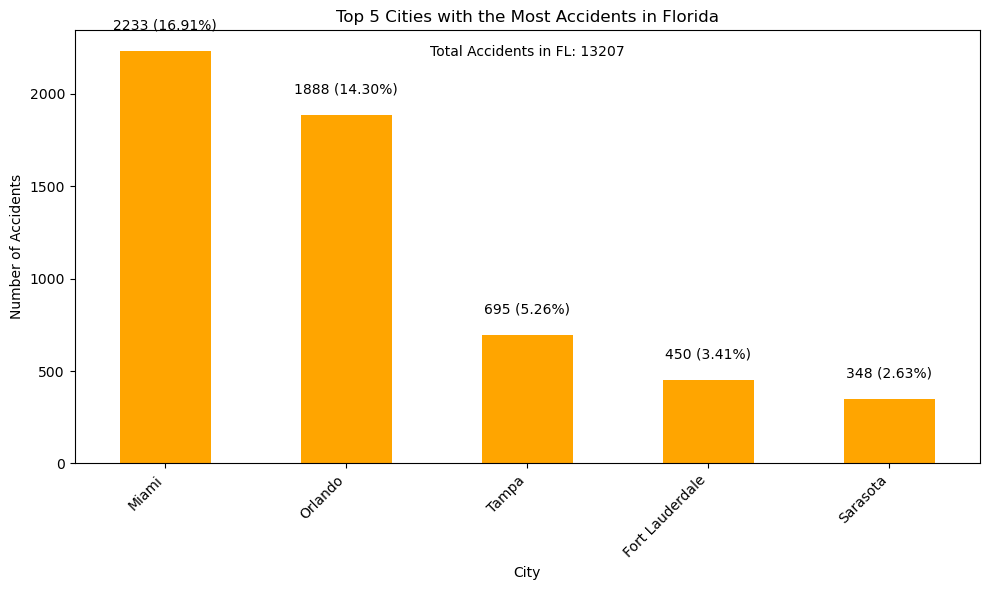

In [104]:
# Calculate the total percentage of accidents in florida
total_accidents_florida = len(accidents_florida)
percentage_florida = total_accidents_florida / len(df_sample) * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
accidents_by_city_florida.plot(kind='bar', color='orange')



# Set the title and axis labels
plt.title('Top 5 Cities with the Most Accidents in Florida')
plt.xlabel('City')
plt.ylabel('Number of Accidents')

# Add the count and percentage to the label above each bar
for x, y in enumerate(accidents_by_city_florida):
    plt.text(x, y + 100, f'{y} ({(y / total_accidents_florida * 100):.2f}%)',
             ha='center', va='bottom')
    # Add the total percentage to the label
plt.text(0.5, 0.95, f'Total Accidents in FL: {total_accidents_florida}',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the bar plot
plt.tight_layout()
plt.savefig("plots/categorical/top_5_accident_prone_cities_Florida.png", dpi=300)
plt.show()

In [101]:
#Filtering the Accidents in Texas By City
accidents_texas = df_sample[df_sample['State'] == 'TX']

#Filtering the top 5 cities in Texas with most Accidents
accidents_by_city_texas = accidents_texas['City'].value_counts().head(5)

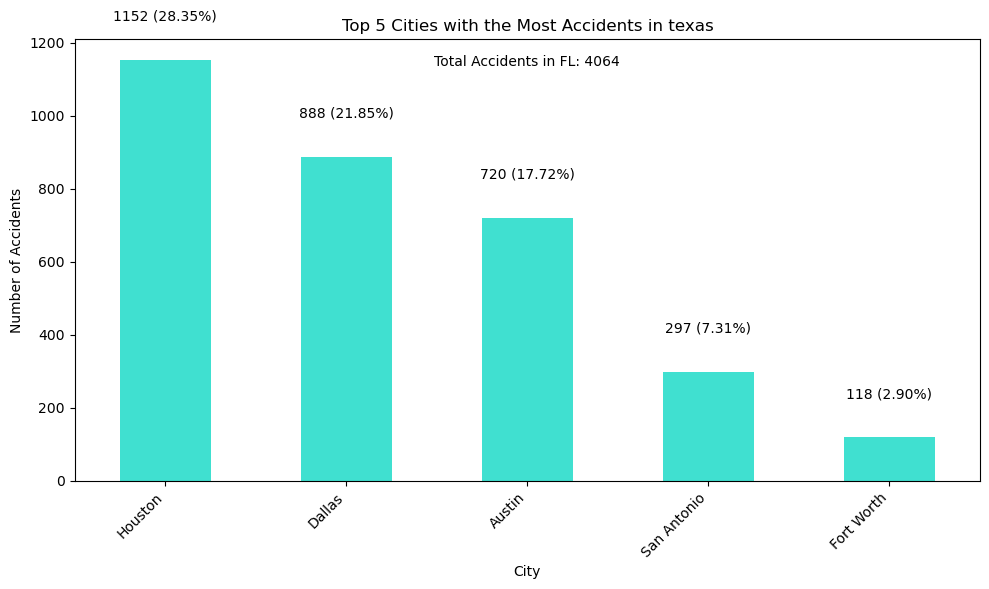

In [103]:
# Calculate the total percentage of accidents in texas
total_accidents_texas = len(accidents_texas)
percentage_texas= total_accidents_texas / len(df_sample) * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
accidents_by_city_texas.plot(kind='bar', color='turquoise')



# Set the title and axis labels
plt.title('Top 5 Cities with the Most Accidents in texas')
plt.xlabel('City')
plt.ylabel('Number of Accidents')

# Add the count and percentage to the label above each bar
for x, y in enumerate(accidents_by_city_texas):
    plt.text(x, y + 100, f'{y} ({(y / total_accidents_texas * 100):.2f}%)',
             ha='center', va='bottom')
    # Add the total percentage to the label
plt.text(0.5, 0.95, f'Total Accidents in FL: {total_accidents_texas}',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the bar plot
plt.tight_layout()
plt.savefig("plots/categorical/top_5_accident_prone_cities_Texas.png", dpi=300)
plt.show()

**Observations:** In all three states—California, Florida, and Texas—accidents are highly concentrated in a **few major cities**, with **Los Angeles, Miami, and Houston** leading their respective states by significant margins. Notably, **Los Angeles** alone accounts for over **10%** of California's accidents, while **Miami** and **Houston** contribute to nearly **17%** and **28%** of total accidents in Florida and Texas, respectively, highlighting the disproportionate impact of dense urban areas on traffic incidents.

### Analysis by Weather

This section explores how weather conditions like temperature, humidity, and wind speed affect accident occurrences. These values are compared with yearly averages to see how much they differ from normal. The focus is on the top three states with the most accidents, and a bar chart is used to show the overall weather patterns.


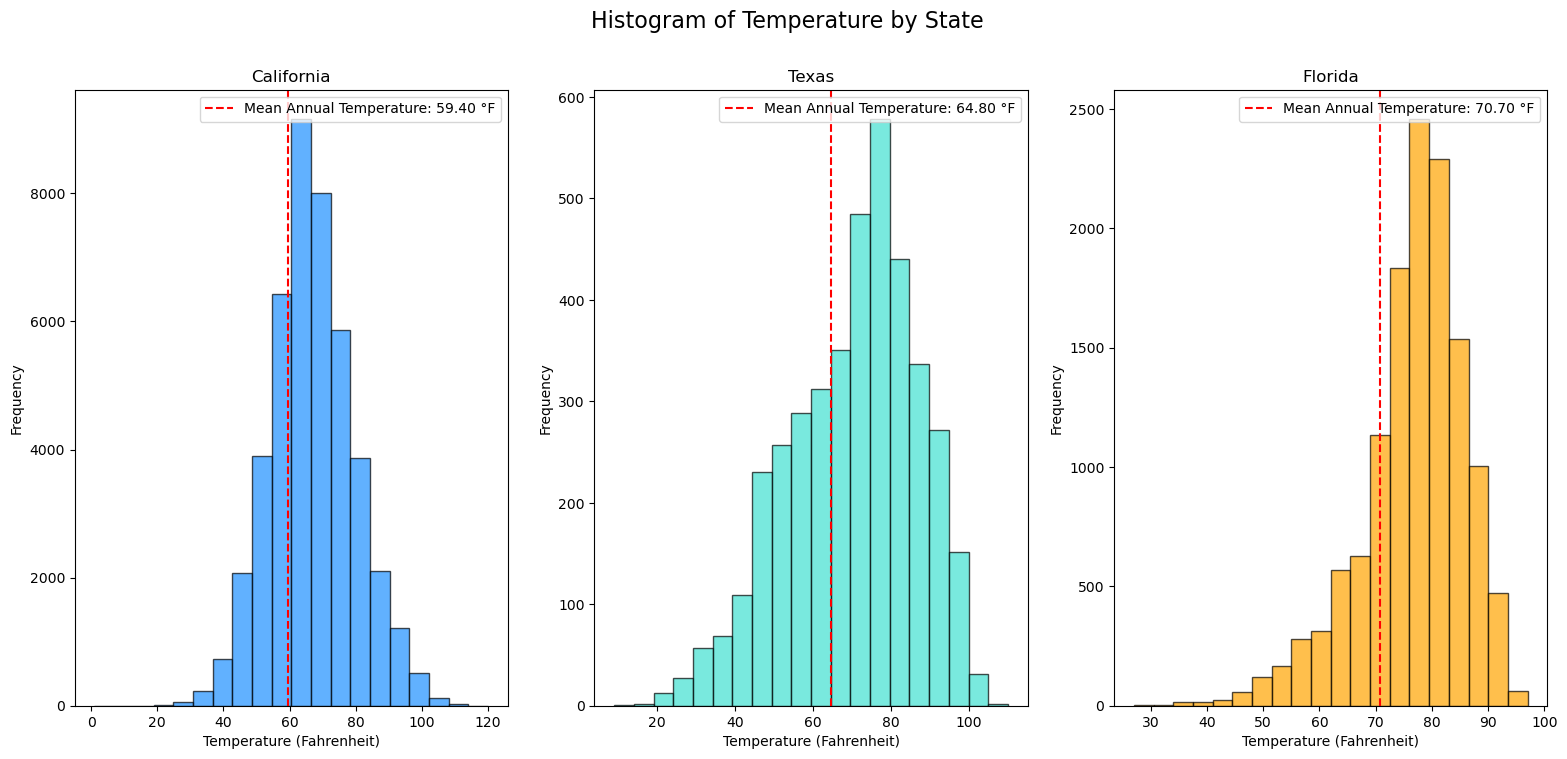

In [110]:
# Filter data for California, Texas, and Florida
california_data = df_sample[df_sample['State'] == 'CA']['Temperature(F)'].dropna()
texas_data = df_sample[df_sample['State'] == 'TX']['Temperature(F)'].dropna()
florida_data = df_sample[df_sample['State'] == 'FL']['Temperature(F)'].dropna()

# Calculate mean temperatures for each state
california_mean_temp = 59.4
texas_mean_temp = 64.8
florida_mean_temp = 70.7

# Create subplots for each state
fig, axes = plt.subplots(1, 3, figsize=(19, 8))

# California
axes[0].hist(california_data, bins=20, color='dodgerblue', edgecolor='black', alpha=0.7)
axes[0].axvline(california_mean_temp, color='red', linestyle='--', linewidth=1.5, label=f'Mean Annual Temperature: {california_mean_temp:.2f} °F')
axes[0].set_title('California')
axes[0].set_xlabel('Temperature (Fahrenheit)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Texas
axes[1].hist(texas_data, bins=20, color='turquoise', edgecolor='black', alpha=0.7)
axes[1].axvline(texas_mean_temp, color='red', linestyle='--', linewidth=1.5, label=f'Mean Annual Temperature: {texas_mean_temp:.2f} °F')
axes[1].set_title('Texas')
axes[1].set_xlabel('Temperature (Fahrenheit)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Florida
axes[2].hist(florida_data, bins=20, color='orange', edgecolor='black', alpha=0.7)
axes[2].axvline(florida_mean_temp, color='red', linestyle='--', linewidth=1.5, label=f'Mean Annual Temperature: {florida_mean_temp:.2f} °F')
axes[2].set_title('Florida')
axes[2].set_xlabel('Temperature (Fahrenheit)')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.suptitle('Histogram of Temperature by State', fontsize=16)
plt.savefig("plots/categorical/histogram_of_temperature_by_top_3_state.png", dpi=300)
plt.show()

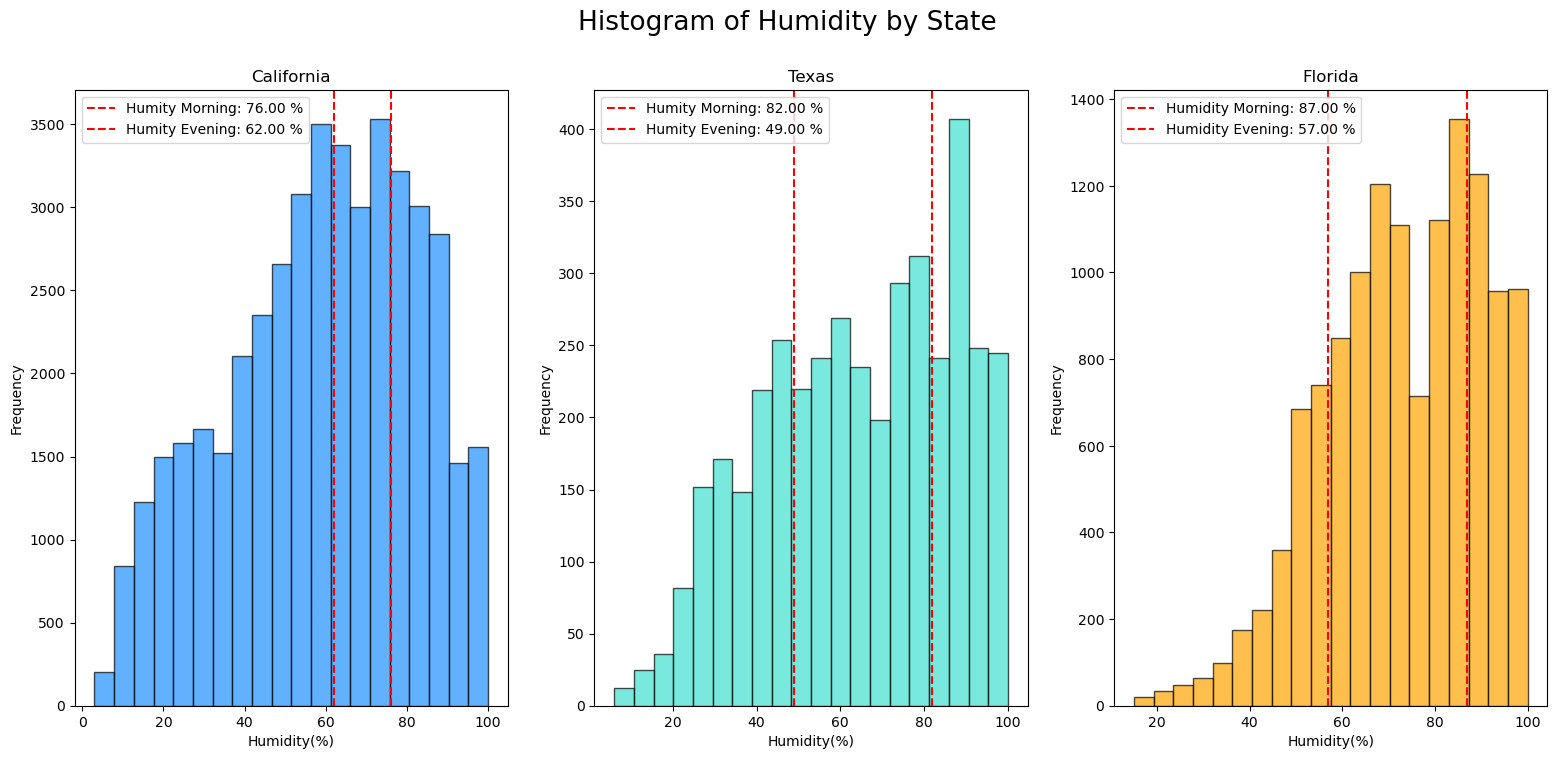

In [109]:
# Filter data for California, Texas, and Florida
california_data = df_sample[df_sample['State'] == 'CA']['Humidity(%)'].dropna()
texas_data = df_sample[df_sample['State'] == 'TX']['Humidity(%)'].dropna()
florida_data = df_sample[df_sample['State'] == 'FL']['Humidity(%)'].dropna()

# Calculate mean temperatures for each state
california_mean_humity_morning = 76
california_mean_humity_night = 62
texas_mean_humity_morning = 82
texas_mean_humity_night = 49
florida_mean_humity_morning = 87
florida_mean_humity_night = 57

# Create subplots for each state
fig, axes = plt.subplots(1, 3, figsize=(19, 8))

# California
axes[0].hist(california_data, bins=20, color='dodgerblue', edgecolor='black', alpha=0.7)
axes[0].axvline(california_mean_humity_morning, color='red', linestyle='--', linewidth=1.5, label=f'Humity Morning: {california_mean_humity_morning:.2f} %')
axes[0].axvline(california_mean_humity_night, color='red', linestyle='--', linewidth=1.5, label=f'Humity Evening: {california_mean_humity_night:.2f} %')
axes[0].set_title('California')
axes[0].set_xlabel('Humidity(%)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Texas
axes[1].hist(texas_data, bins=20, color='turquoise', edgecolor='black', alpha=0.7)
axes[1].axvline(texas_mean_humity_morning, color='red', linestyle='--', linewidth=1.5, label=f'Humity Morning: {texas_mean_humity_morning:.2f} %')
axes[1].axvline(texas_mean_humity_night, color='red', linestyle='--', linewidth=1.5, label=f'Humity Evening: {texas_mean_humity_night:.2f} %')
axes[1].set_title('Texas')
axes[1].set_xlabel('Humidity(%)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Florida
axes[2].hist(florida_data, bins=20, color='orange', edgecolor='black', alpha=0.7)
axes[2].axvline(florida_mean_humity_morning, color='red', linestyle='--', linewidth=1.5, label=f'Humidity Morning: {florida_mean_humity_morning:.2f} %')
axes[2].axvline(florida_mean_humity_night, color='red', linestyle='--', linewidth=1.5, label=f'Humidity Evening: {florida_mean_humity_night:.2f} %')
axes[2].set_title('Florida')
axes[2].set_xlabel('Humidity(%)')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.suptitle('Histogram of Humidity by State', fontsize=19)
plt.savefig("plots/categorical/histogram_of_humidity_by_top_3_state.png", dpi=300)
plt.show()

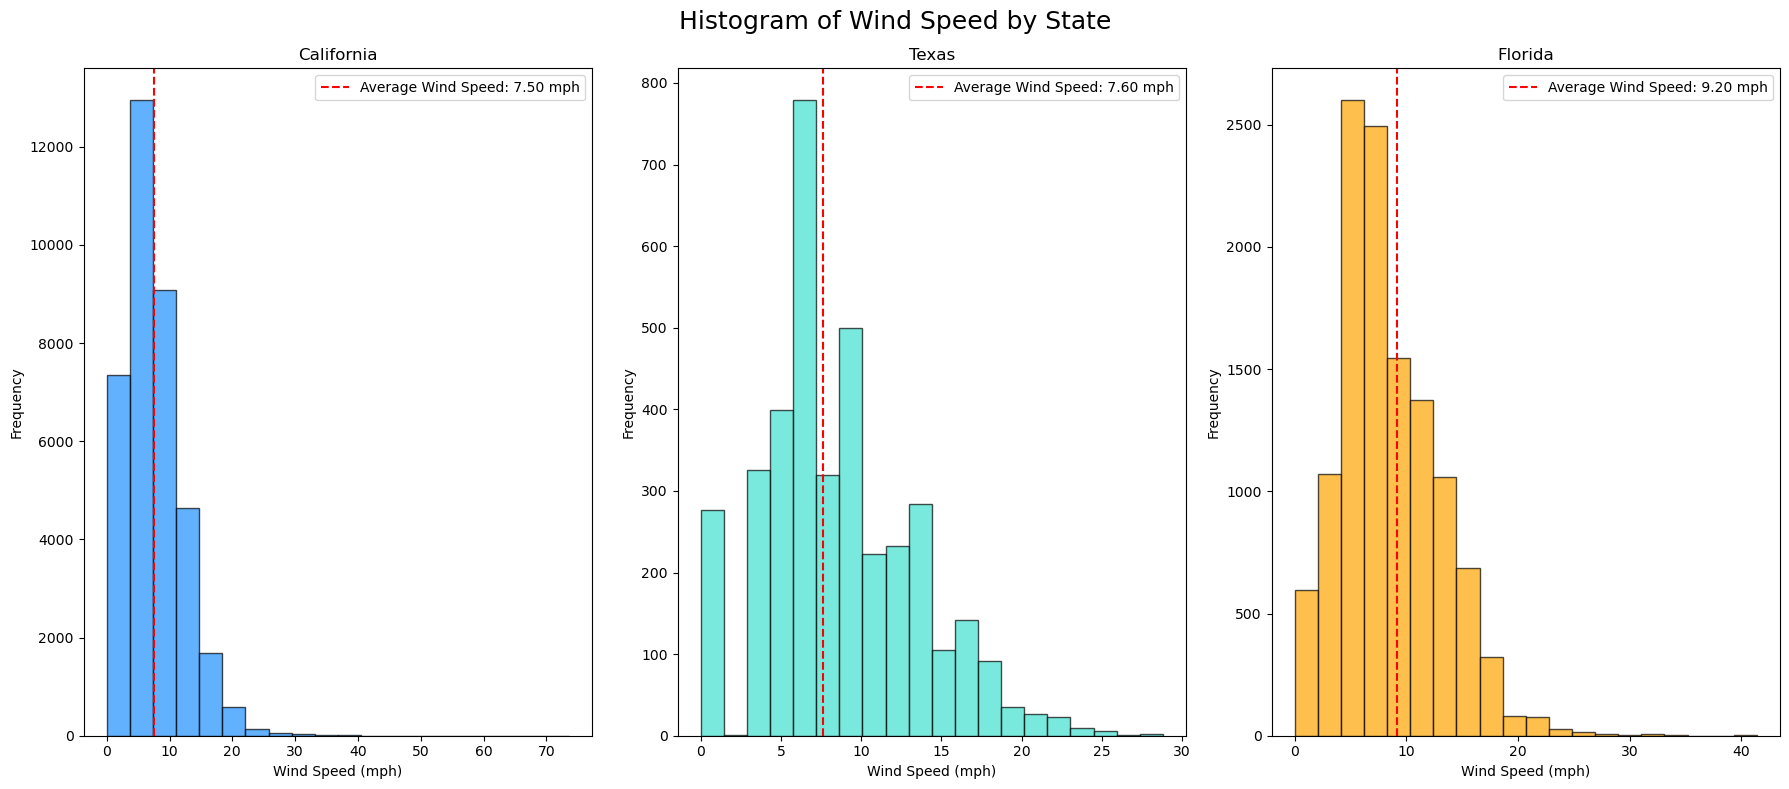

In [111]:
# Filter data for California, Texas, and Florida
california_data = df_sample[df_sample['State'] == 'CA']['Wind_Speed(mph)'].dropna()
texas_data = df_sample[df_sample['State'] == 'TX']['Wind_Speed(mph)'].dropna()
florida_data = df_sample[df_sample['State'] == 'FL']['Wind_Speed(mph)'].dropna()

# Calculate mean temperatures for each state
california_mean_wind = 7.5
texas_mean_wind = 7.6
florida_mean_wind = 9.2

# Create subplots for each state
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# California
axes[0].hist(california_data, bins=20, color='dodgerblue', edgecolor='black', alpha=0.7)
axes[0].axvline(california_mean_wind, color='red', linestyle='--', linewidth=1.5, label=f'Average Wind Speed: {california_mean_wind:.2f} mph')
axes[0].set_title('California')
axes[0].set_xlabel('Wind Speed (mph)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Texas
axes[1].hist(texas_data, bins=20, color='turquoise', edgecolor='black', alpha=0.7)
axes[1].axvline(texas_mean_wind, color='red', linestyle='--', linewidth=1.5, label=f'Average Wind Speed: {texas_mean_wind:.2f} mph')
axes[1].set_title('Texas')
axes[1].set_xlabel('Wind Speed (mph)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Florida
axes[2].hist(florida_data, bins=20, color='orange', edgecolor='black', alpha=0.7)
axes[2].axvline(florida_mean_wind, color='red', linestyle='--', linewidth=1.5, label=f'Average Wind Speed: {florida_mean_wind:.2f} mph')
axes[2].set_title('Florida')
axes[2].set_xlabel('Wind Speed (mph)')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.suptitle('Histogram of Wind Speed by State', fontsize=18)
plt.tight_layout()
plt.savefig("plots/categorical/histogram_of_wind_speed_by_top_3_state.png", dpi=300)
plt.show()


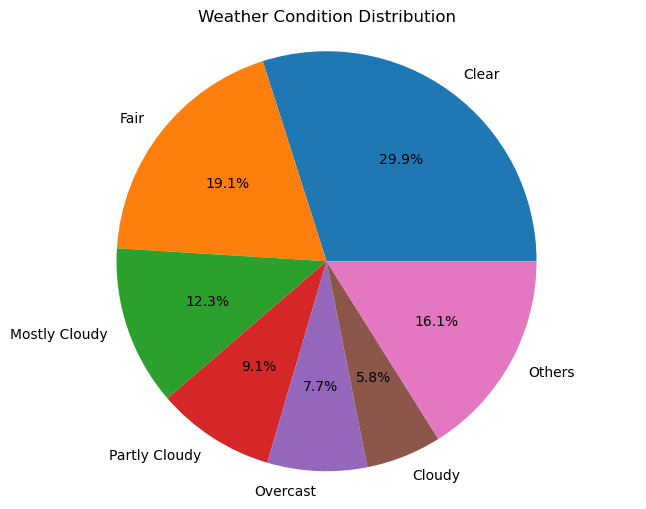

In [113]:
# Graph the Weather conditions in a Pie Chart
weather_counts = df_sample['Weather_Condition'].value_counts()

# Group the main categories of weather conditions
top_conditions = weather_counts.head(6)
other_conditions_count = weather_counts.iloc[6:].sum()

# Create a new DataFrame with the summarized weather conditions
summary_weather_counts = pd.DataFrame(top_conditions).reset_index()
summary_weather_counts.columns = ['Weather_Condition', 'Count']

others_row = pd.DataFrame({'Weather_Condition': ['Others'], 'Count': [other_conditions_count]})
summary_weather_counts = pd.concat([summary_weather_counts, others_row], ignore_index=True)

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(summary_weather_counts['Count'], labels=summary_weather_counts['Weather_Condition'], autopct='%1.1f%%')
plt.title('Weather Condition Distribution')
plt.axis('equal')
plt.savefig("plots/categorical/weather_condition_distribution.png", dpi=300)
plt.show()

### Observations: Weather Analysis and Accident Trends

- **Humidity Patterns**:  
  In all three states—California, Texas, and Florida—accidents are more frequent at moderate to high humidity levels. Notably, in Florida and Texas, the majority of accidents occur around or above the average morning humidity, suggesting elevated moisture might coincide with riskier driving periods.

- **Temperature Distribution**:  
  Most accidents occur within a narrow band around each state's average annual temperature. This suggests that extreme temperature deviations are not the primary cause of accidents; rather, accidents are more likely during regular daily temperature conditions.

- **Wind Speed Trends**:  
  The majority of accidents happen under low wind speeds, mostly below 15 mph in all three states. This indicates that wind speed is not a major contributing factor to accident risk, similar to observations made for calm wind directions.

- **Weather Condition Categories**:  
  Almost 70% of accidents occur in relatively fair weather, with **Clear**, **Fair**, and **Mostly Cloudy** conditions dominating the pie chart. This suggests that adverse weather (e.g., rain, fog, snow) is **not** the main trigger for most accidents, highlighting the role of human or traffic factors over environmental hazards.


### Temporal Patterns of Accidents: Year, Weekday, and Hourly Trends
This section breaks down accident data using the 'Start_Time' column to explore how often accidents occur by year, day of the week, and time of day. It also compares weekdays vs. weekends, since driving patterns and accident trends can differ significantly between them.

In [114]:
#Changing the Time Format
print(df_sample['Start_Time'].head())

0   2016-09-15 11:07:56
1   2022-04-30 22:21:00
2   2016-07-13 08:59:47
3   2016-03-16 09:25:43
4   2016-08-31 19:06:45
Name: Start_Time, dtype: datetime64[us]


In [115]:
# Convert the 'Start_Time' column to datetime object
df_sample.Start_Time = pd.to_datetime(df_sample.Start_Time, errors='coerce')

year = df_sample['Start_Time'].dt.year
month = df_sample['Start_Time'].dt.month
dayofweek = df_sample['Start_Time'].dt.dayofweek
hour = df_sample['Start_Time'].dt.hour
weekday_hour = df_sample[df_sample['Start_Time'].dt.dayofweek < 5]['Start_Time'].dt.hour
weekend_hour = df_sample[df_sample['Start_Time'].dt.dayofweek >= 5]['Start_Time'].dt.hour


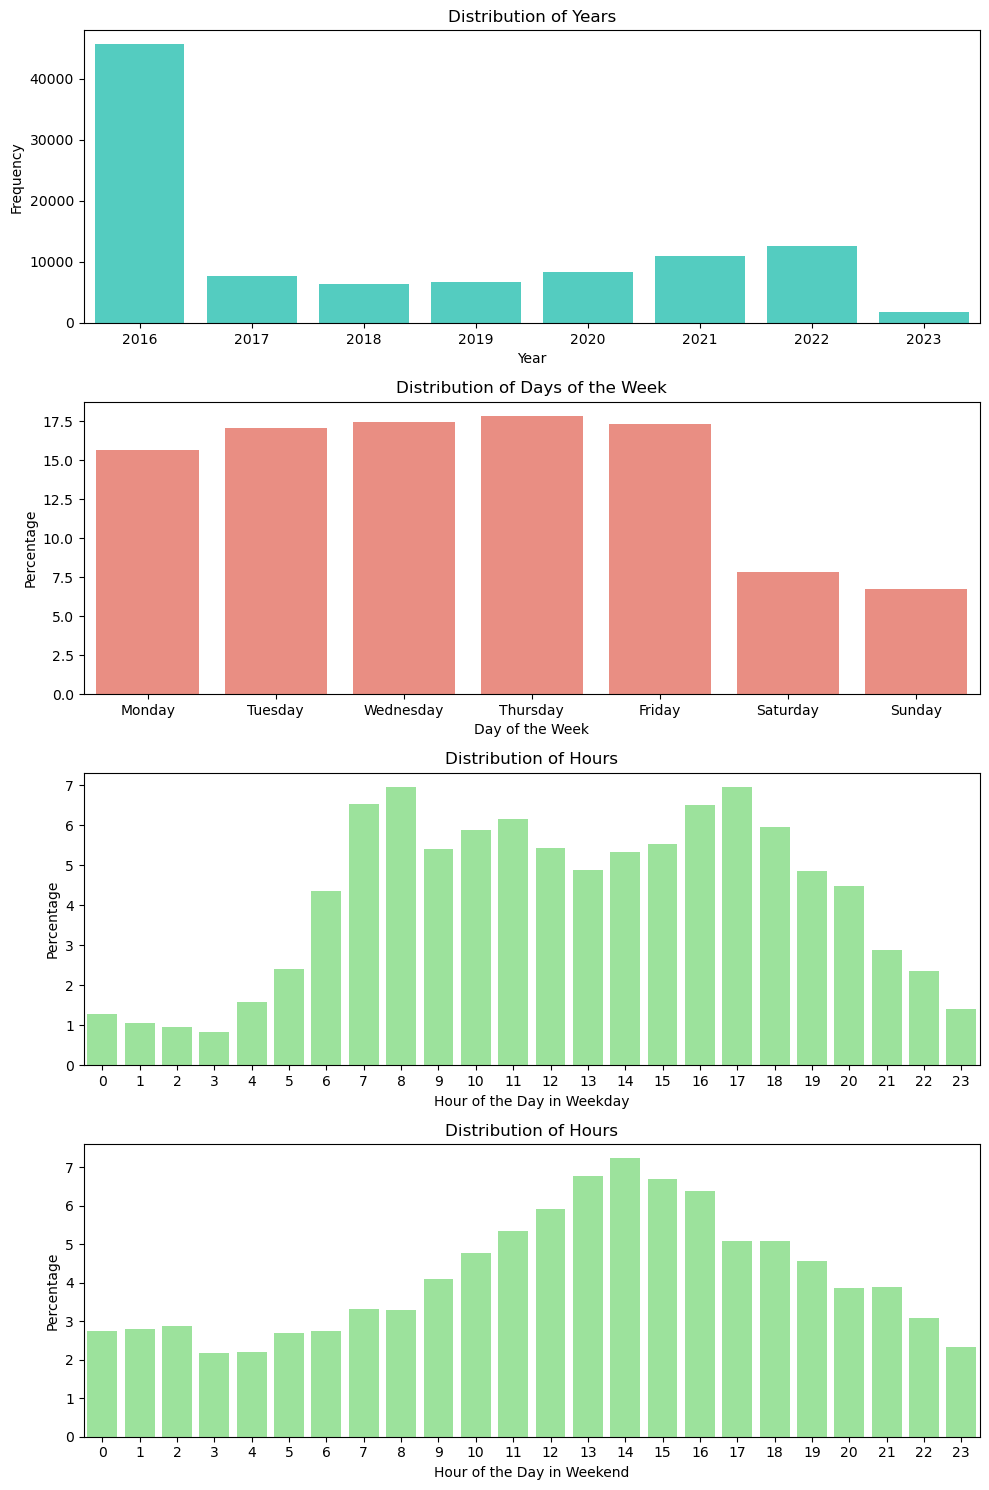

In [117]:
# Create histograms for hours, years, and days of the week
fig, axes = plt.subplots(4, 1, figsize=(10, 15))

# Histogram for years
year_frequency = (year.value_counts()).sort_index()
sns.barplot(x=year_frequency.index.astype(int), y=year_frequency.values, ax=axes[0], color='turquoise')
axes[0].set_title('Distribution of Years')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Frequency')

# Histogram for days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_percentage = (dayofweek.value_counts(normalize=True) * 100).sort_index()
sns.barplot(x=day_percentage.index, y=day_percentage.values, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Days of the Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Percentage')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(days)


# Histogram for Hours in Weekdays
hour_percentage = (weekday_hour.value_counts(normalize=True) * 100).sort_index()
sns.barplot(x=hour_percentage.index.astype(int), y=hour_percentage.values, ax=axes[2], color='lightgreen')
axes[2].set_title('Distribution of Hours')
axes[2].set_xlabel('Hour of the Day in Weekday')
axes[2].set_ylabel('Percentage')

# Histogram for Hours in Weekends
hour_percentage = (weekend_hour.value_counts(normalize=True) * 100).sort_index()
sns.barplot(x=hour_percentage.index.astype(int), y=hour_percentage.values, ax=axes[3], color='lightgreen')
axes[3].set_title('Distribution of Hours')
axes[3].set_xlabel('Hour of the Day in Weekend')
axes[3].set_ylabel('Percentage')
plt.tight_layout()
plt.savefig("plots/categorical/temporal_patterns_of_accidents_by_year_weekday_hourly_trends.png", dpi=300)
plt.show()

### Observations: Temporal Patterns of Accidents

- **Yearly Distribution**: A large number of accidents were recorded in 2016, likely due to data collection starting mid-year and capturing older records in bulk. Accident counts are more evenly distributed in subsequent years, with a slight rise in recent years up to 2022.

- **Day of the Week**: Accidents are more frequent on weekdays, especially from Tuesday to Friday, suggesting a strong link to workday commuting patterns. Weekend accident percentages drop noticeably on Saturday and Sunday.

- **Hourly Patterns – Weekdays**: Accidents peak around typical commuting hours, especially **7–9 AM** and again from **3–6 PM**, reflecting morning and evening rush hour risks.

- **Hourly Patterns – Weekends**: Accident frequency rises later in the day, peaking between **12 PM and 3 PM**, possibly due to leisure travel and mid-day activity, with fewer incidents in early morning and late night hours.

These patterns highlight the influence of work schedules and daily routines on accident occurrence.


### Correlation Heatmap for Numerical Variables

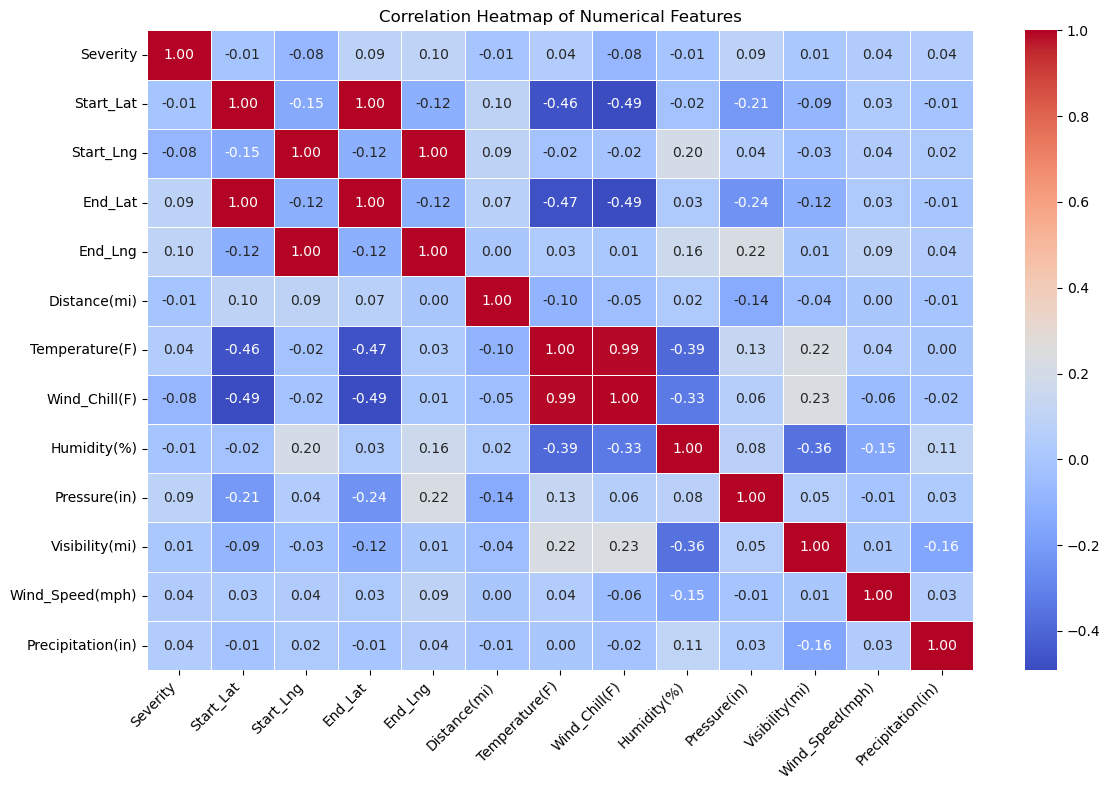

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Step 1: Select numeric columns from df_sample
numeric_cols = df_sample.select_dtypes(include=['float64', 'int64'])

# Step 2: Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Step 3: Set up folder if it doesn't exist
output_dir = "plots/numerical"
os.makedirs(output_dir, exist_ok=True)

# Step 4: Plot and save heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
output_path = os.path.join(output_dir, "correlation_heatmap.png")
plt.savefig(output_path, dpi=300)
plt.show()

#### Observations: Correlation Heatmap of Numerical Features

- Most numeric features show **weak to moderate correlations** with one another, indicating they provide relatively independent information.
- As expected, **Temperature** and **Wind Chill** have a very strong positive correlation (**0.99**), suggesting they are nearly interchangeable in this dataset.
- **Start_Lat** and **End_Lat**, as well as **Start_Lng** and **End_Lng**, are perfectly correlated (value = **1.00**) — likely due to minimal change in coordinates between start and end points in short-distance accidents.
- **Humidity** shows a mild negative correlation with **Visibility** (**-0.36**) and **Pressure** (**-0.15**), which is consistent with atmospheric behavior.
- The correlation between any feature and **Severity** is relatively low (mostly between **-0.1 and 0.1**), suggesting that accident severity is influenced by a **complex combination of factors** rather than any single numeric variable.

This heatmap helps validate which features are redundant and which ones may offer distinct signals for further modeling or analysis.


### Pairplot with Severity of Accidents

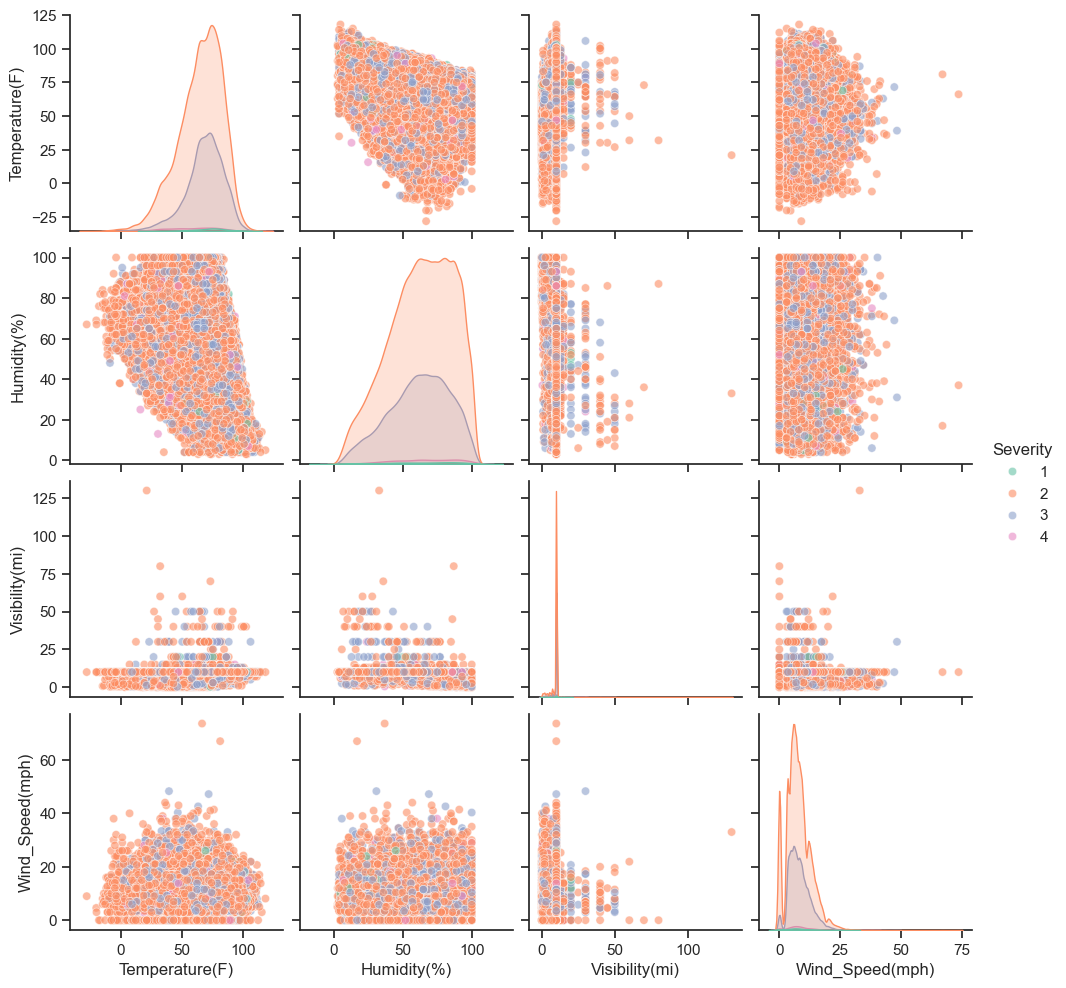

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Step 1: Select relevant columns (limit for clarity + speed)
selected_cols = ['Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Severity']

# Step 2: Drop missing values (required for sns.pairplot)
pairplot_data = df_sample[selected_cols].dropna()

# Optional: Sample further to speed up the plot (e.g., 3000 rows)
#pairplot_data = pairplot_data.sample(n=3000, random_state=42)

# Step 3: Create the pairplot
sns.set(style="ticks")
pairplot = sns.pairplot(pairplot_data, hue='Severity', palette='Set2', diag_kind='kde', plot_kws={'alpha': 0.6})

# Step 4: Save the plot
output_dir = "plots/numerical"
os.makedirs(output_dir, exist_ok=True)
pairplot.savefig(os.path.join(output_dir, "pairplot_severity.png"), dpi=300)

plt.show()


### 🔍 Observations: Pairplot of Key Weather Variables by Severity

- The pairplot shows the relationships between key weather-related features (`Temperature`, `Humidity`, `Visibility`, `Wind Speed`) across different levels of **accident severity**.
- Each **scatterplot** in the lower triangle visualizes how two variables relate to one another, colored by `Severity` (1 to 4).
- The **diagonal plots** are **kernel density estimates (KDEs)** showing the distribution of each feature separately for each severity level. These KDEs overlap, creating the appearance of multiple layers per variable — one per severity group.
- From this plot, we observe that most severity levels share similar distributions, especially for `Temperature`, `Humidity`, and `Wind Speed`, suggesting that **weather conditions alone may not strongly distinguish between severity levels**.
- A few outliers with high `Wind Speed` or very low `Visibility` appear more often in higher severity levels, but these are relatively rare.

This pairplot is useful for spotting broad trends or clusters, but doesn’t reveal strong separation between severities — pointing to the need for more complex modeling or the inclusion of other variables.


## Some EDA ofr the full dataset 

#### Define the full dataset

In [121]:
df_full = pd.read_csv('../data/US_Accidents_March23.csv')


#### Clean for Latitude/Longitude-based Plots

In [122]:
# Filter valid coordinates
df_geo = df_full[(df_full['Start_Lat'].notna()) & (df_full['Start_Lng'].notna())]
df_geo = df_geo[(df_geo['Start_Lat'] != 0) & (df_geo['Start_Lng'] != 0)]


### Accident Density Across States

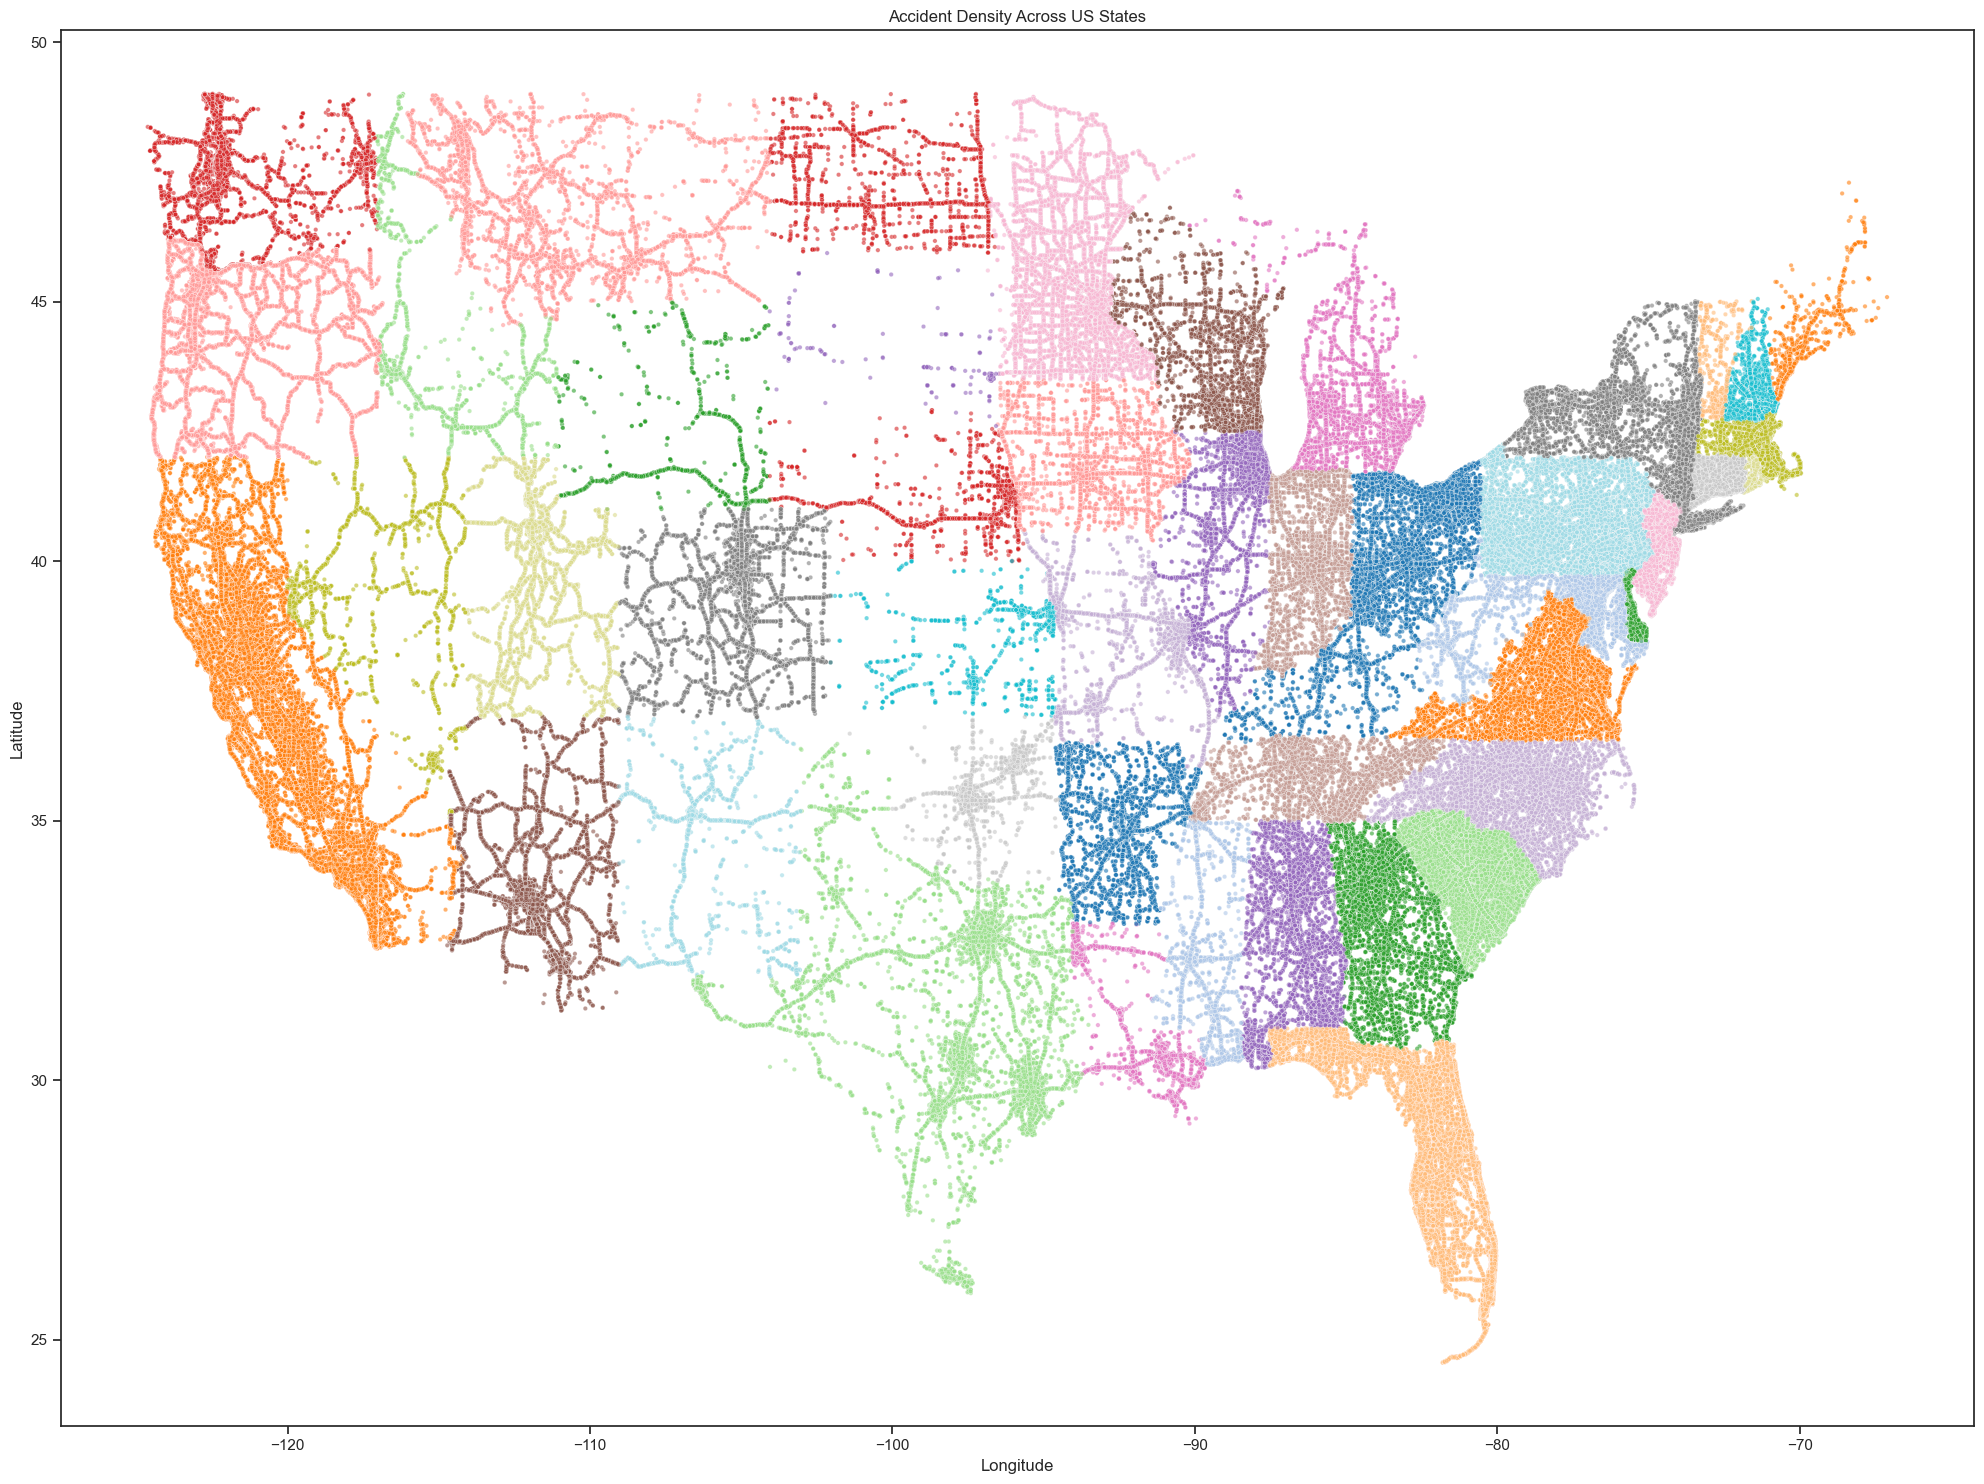

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 15))
sns.scatterplot(x=df_geo['Start_Lng'], y=df_geo['Start_Lat'], hue=df_geo['State'], 
                palette='tab20', s=10, alpha=0.6, legend=False)
plt.title('Accident Density Across US States')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig("plots/geospatial/accident_density_by_state.png", dpi=300)
plt.show()


### Observations: Accident Density Across US States

- The scatterplot shows a clear concentration of accidents along **major highway corridors**, particularly in **California**, **Texas**, **Florida**, and the **Northeastern corridor**.
- States with dense urban infrastructure, such as **California** and the **Mid-Atlantic states**, exhibit tightly packed clusters, reflecting high accident frequency in urban and suburban areas.
- The **Midwest and Western states** show a more dispersed pattern, with accidents spread out along major interstates rather than densely packed urban regions.
- Overall, the visualization highlights that accident density is strongly tied to population density, road networks, and urban development.


### Severity Across the US

/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_68557/2118080524.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_68557/2118080524.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("plots/geospatial/severity_across_states.png", dpi=300)
/Users/deb/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


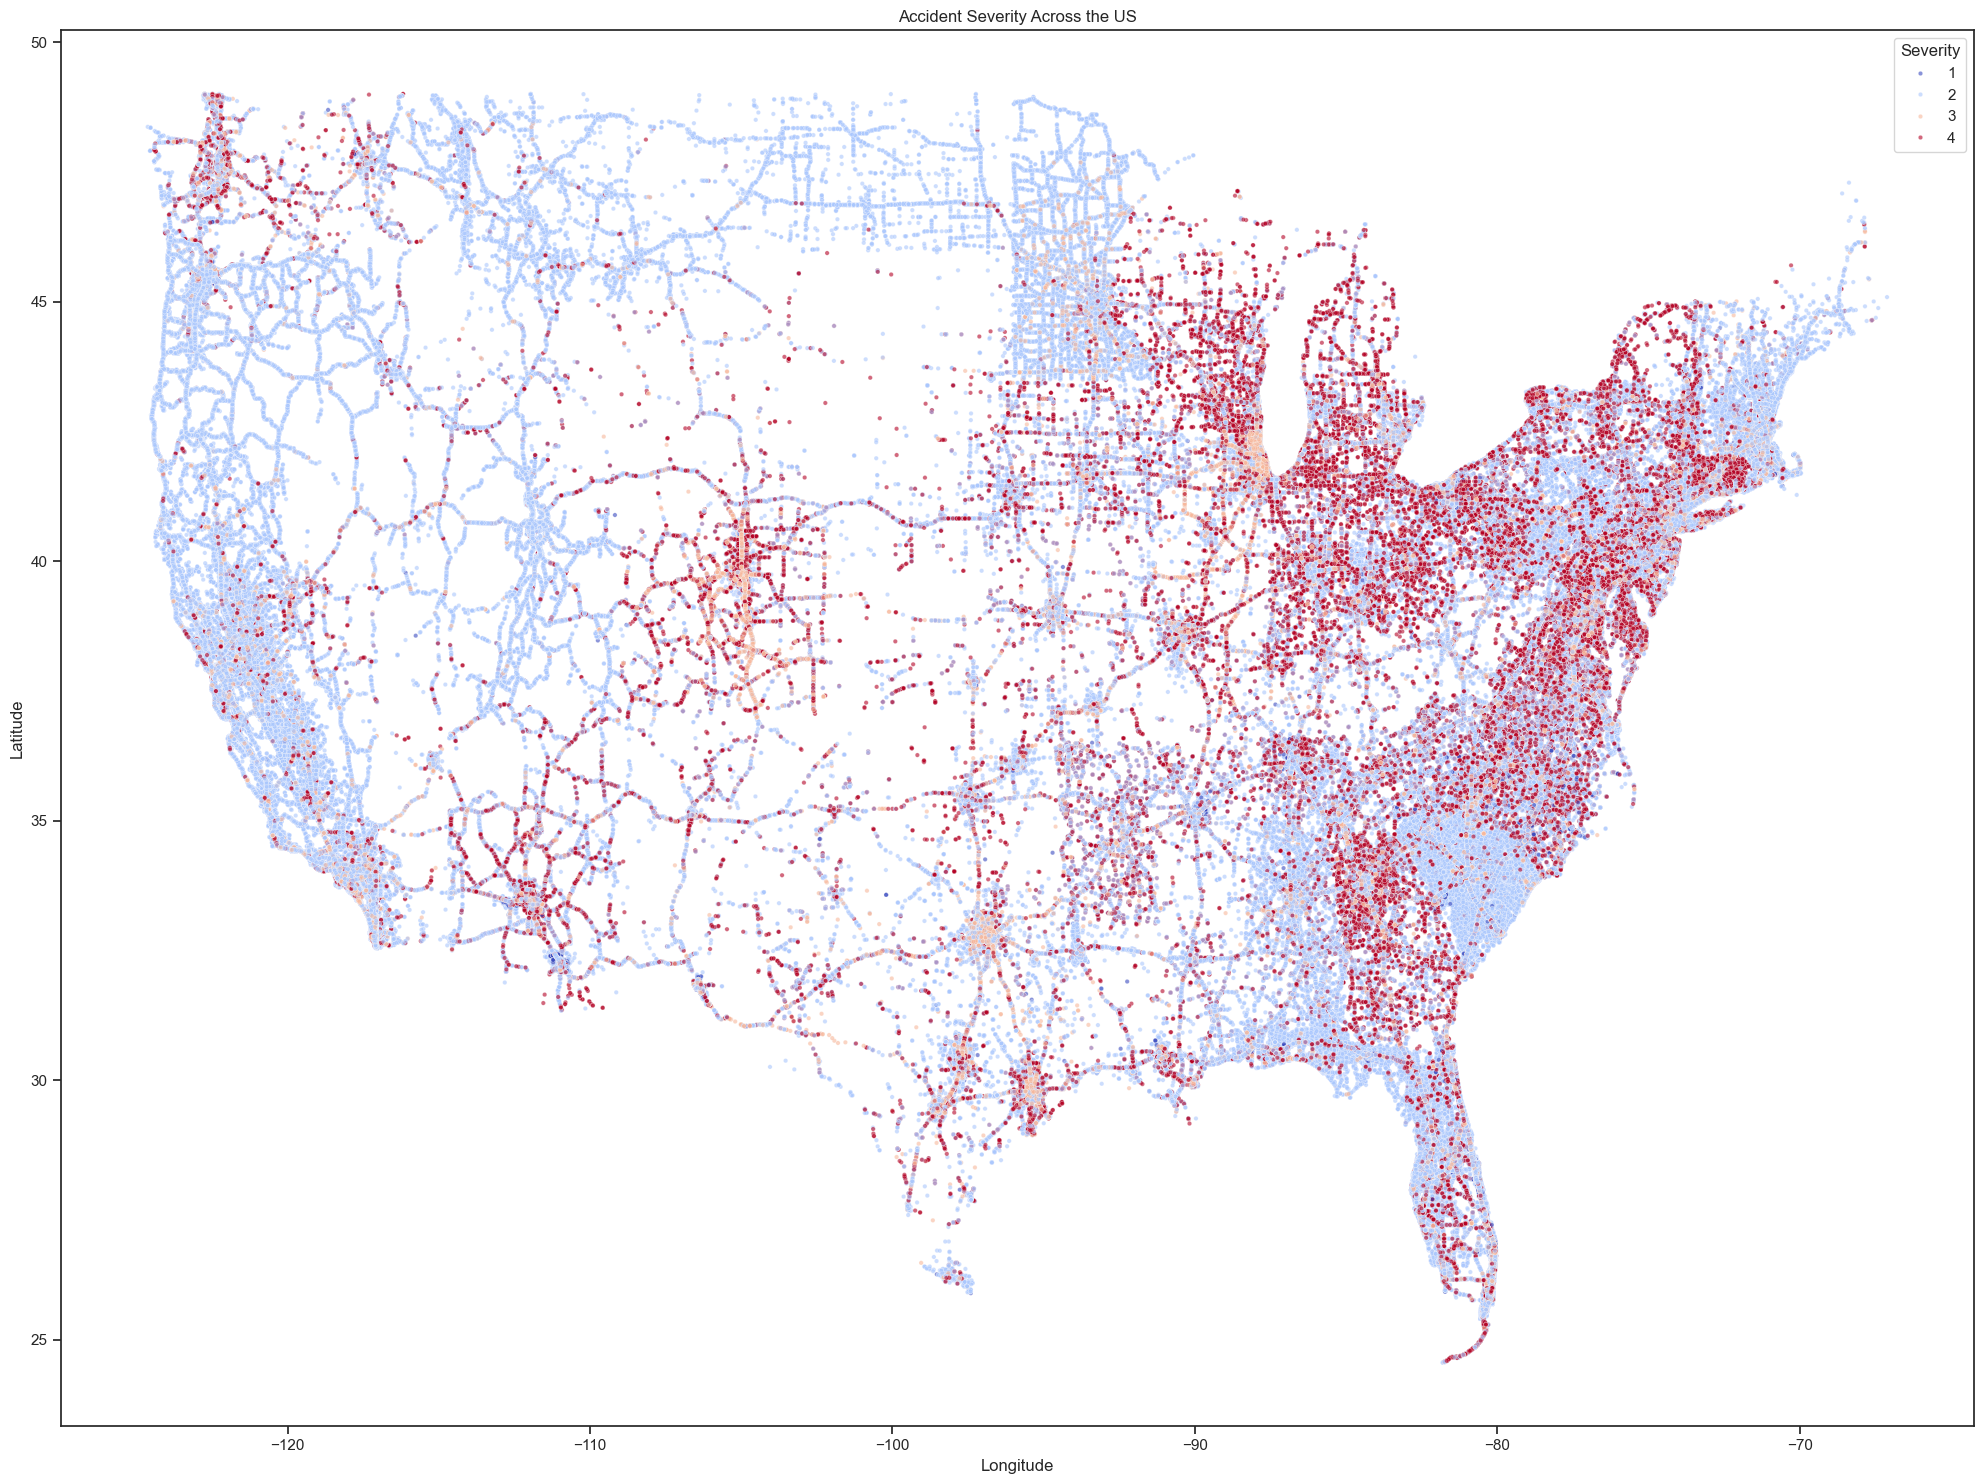

In [124]:
plt.figure(figsize=(20, 15))
sns.scatterplot(x=df_geo['Start_Lng'], y=df_geo['Start_Lat'], hue=df_geo['Severity'], 
                palette='coolwarm', s=10, alpha=0.6)
plt.title('Accident Severity Across the US')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig("plots/geospatial/severity_across_states.png", dpi=300)
plt.show()


### Observations: Accident Severity Across the US

- This scatterplot maps accident locations across the US, colored by **severity level** from 1 (minor) to 4 (most severe).
- **Lower severity accidents (1–2)** are widely distributed and densely clustered around urban areas and interstate networks.
- **Higher severity accidents (3–4)** are more sparsely distributed but appear with noticeable concentration in regions such as the **Midwest**, **Southeast**, and **East Coast**, especially near urban hubs and major highway junctions.
- The plot suggests that **severity is not uniform** across regions — factors such as infrastructure, traffic volume, and possibly emergency response access could influence severity outcomes.


## ✅ Assignment Summary: Time and Weather Based Accident Analysis

This section addresses the following assignment requirements using time-related trends from the full US Accidents dataset:

---

### 📌 Assignment 1: **Accident Rates Over Time**

> *"Provide visualizations showing accident rates over time."*

We interpret "accident rates" as the total number of accidents across different time scales. The following plots were created:

1. **Yearly Accident Trend by Severity**  
   - A stacked bar plot showing total accidents each year (2016–2023), with segments by severity level (1 to 4).  
   - This also partially fulfills Assignment #3.

2. **Seasonal Trend of Accidents by Year and Severity**  
   - A bar plot grouped by year and season (Winter, Spring, Summer, Fall), color-coded by severity level.  
   - Helps understand seasonal risk patterns and their severity distribution over time.

3. **Monthly Accident Trend**  
   - A bar plot showing the number of accidents for each calendar month, aggregated across all years.

4. **Day of the Week Accident Trend**  
   - A bar plot showing accident counts from Monday through Sunday, illustrating weekly driving behavior patterns.

5. **Hourly Accident Trend**  
   - A bar plot showing the distribution of accidents by hour of the day (0 to 23), identifying rush-hour peaks.

---

### 📌 Assignment 3: **Severity Trends by Year**

> *"Analyze how accident severity levels have changed over time."*

- **Yearly Accident Trend by Severity** (Plot #1 above) directly satisfies this requirement.
- It shows how the proportion and total number of accidents at each severity level have evolved from 2016 through 2023.

---

All plots use **raw accident counts** on the y-axis to maintain interpretability and consistency across plots. The data was derived from the `Start_Time` column and visualized using **Matplotlib** and **Seaborn**.


In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Setup ===
# Ensure directory for saving
os.makedirs("plots/time", exist_ok=True)

# === Load & Prepare Data ===
# If not already parsed: handle mixed timestamp formats
df_full['Start_Time'] = pd.to_datetime(df_full['Start_Time'], format='mixed', errors='coerce')

# Extract relevant time components
df_full['Year'] = df_full['Start_Time'].dt.year
df_full['Month'] = df_full['Start_Time'].dt.month_name()
df_full['Hour'] = df_full['Start_Time'].dt.hour
df_full['DayOfWeek'] = df_full['Start_Time'].dt.day_name()

# Define seasons based on month
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
df_full['Season'] = df_full['Start_Time'].dt.month.map(season_map)

# === Plot 1: Yearly Accident Trend (Stacked by Severity) ===
plt.figure(figsize=(12, 6))
yearly_severity = df_full.groupby(['Year', 'Severity']).size().unstack(fill_value=0)
yearly_severity.plot(kind='bar', stacked=True, colormap='Set2', ax=plt.gca())
plt.title('Yearly Accident Trend by Severity')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.savefig("plots/time/yearly_trend_severity.png")
plt.close()

# === Plot 2: Seasonal Trend by Year and Severity ===
plt.figure(figsize=(16, 6))
seasonal = df_full.groupby(['Year', 'Season', 'Severity']).size().reset_index(name='Counts')
pivot_seasonal = seasonal.pivot_table(index=['Year', 'Season'], columns='Severity', values='Counts', fill_value=0)
pivot_seasonal.plot(kind='bar', stacked=True, colormap='Set3', figsize=(16, 6))
plt.title('Seasonal Accident Trend by Severity')
plt.xlabel('Year, Season')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.savefig("plots/time/seasonal_trend_severity.png")
plt.close()

# === Plot 3: Monthly Accident Trend ===
plt.figure(figsize=(12, 6))
monthly_order = ['January', 'February', 'March', 'April', 'May', 'June',
                 'July', 'August', 'September', 'October', 'November', 'December']
monthly_counts = df_full['Month'].value_counts().reindex(monthly_order)
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, color='salmon')
plt.axhline(monthly_counts.mean(), linestyle='--', color='gray', label='Average')
plt.title("Monthly Accident Trend")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/time/monthly_trend.png")
plt.close()

# === Plot 4: Day of Week Accident Trend ===
plt.figure(figsize=(12, 6))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_full['DayOfWeek'].value_counts().reindex(day_order)
sns.barplot(x=day_counts.index, y=day_counts.values, color='pink')
plt.axhline(day_counts.mean(), linestyle='--', color='gray', label='Average')
plt.title("Day of Week Accident Trend")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/time/dayofweek_trend.png")
plt.close()

# === Plot 5: Hourly Accident Trend ===
plt.figure(figsize=(12, 6))
hour_counts = df_full['Hour'].value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values, color='orchid')
plt.axhline(hour_counts.mean(), linestyle='--', color='gray', label='Average')
plt.title("Hourly Accident Trend")
plt.ylabel("Number of Accidents")
plt.xlabel("Hour of Day")
plt.tight_layout()
plt.savefig("plots/time/hourly_trend.png")
plt.close()


<Figure size 1600x600 with 0 Axes>

### Yearly Trend

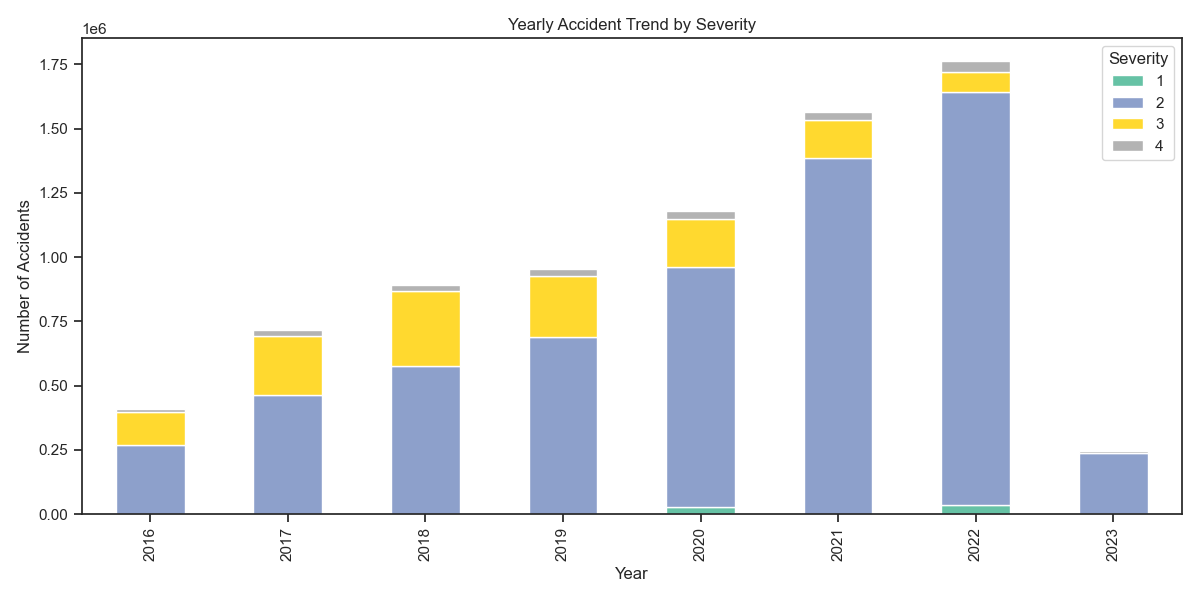

In [128]:
from IPython.display import Image, display
display(Image(filename="plots/time/yearly_trend_severity.png"))


### Seasonal Trend

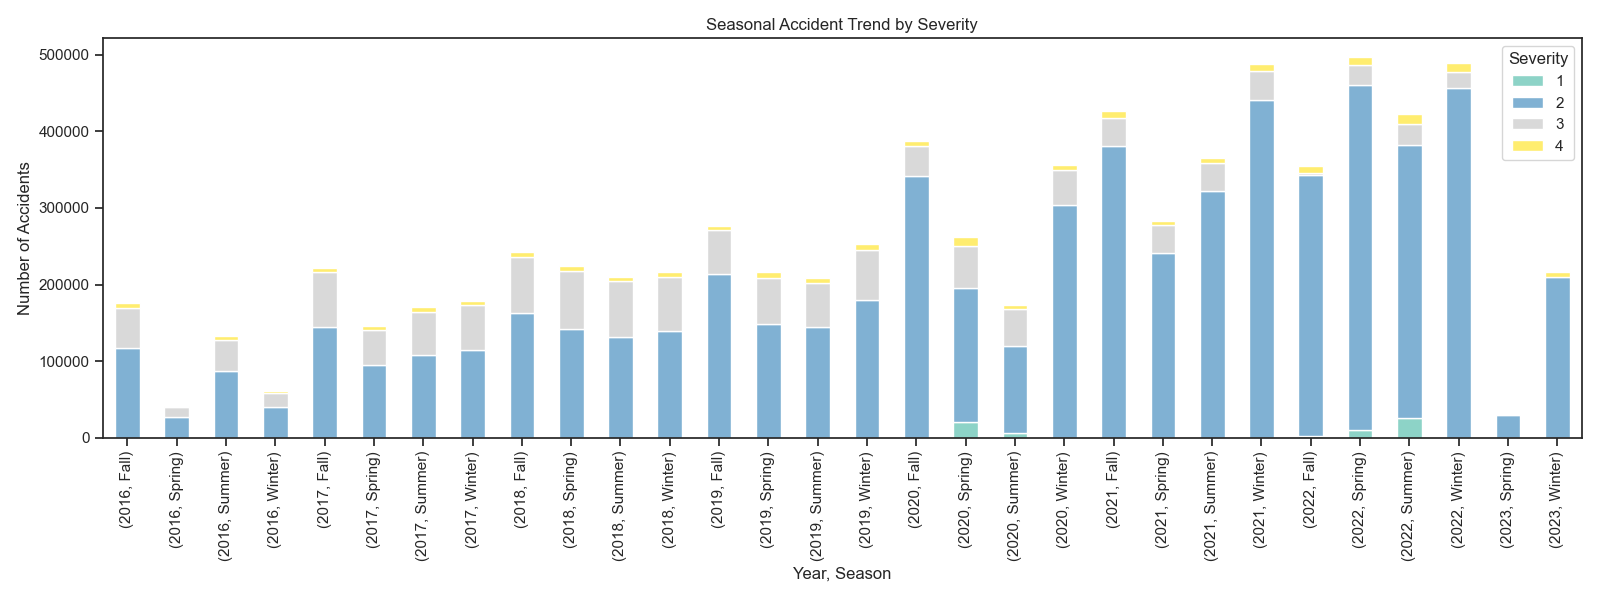

In [129]:
display(Image(filename="plots/time/seasonal_trend_severity.png"))


### Monthly Trend

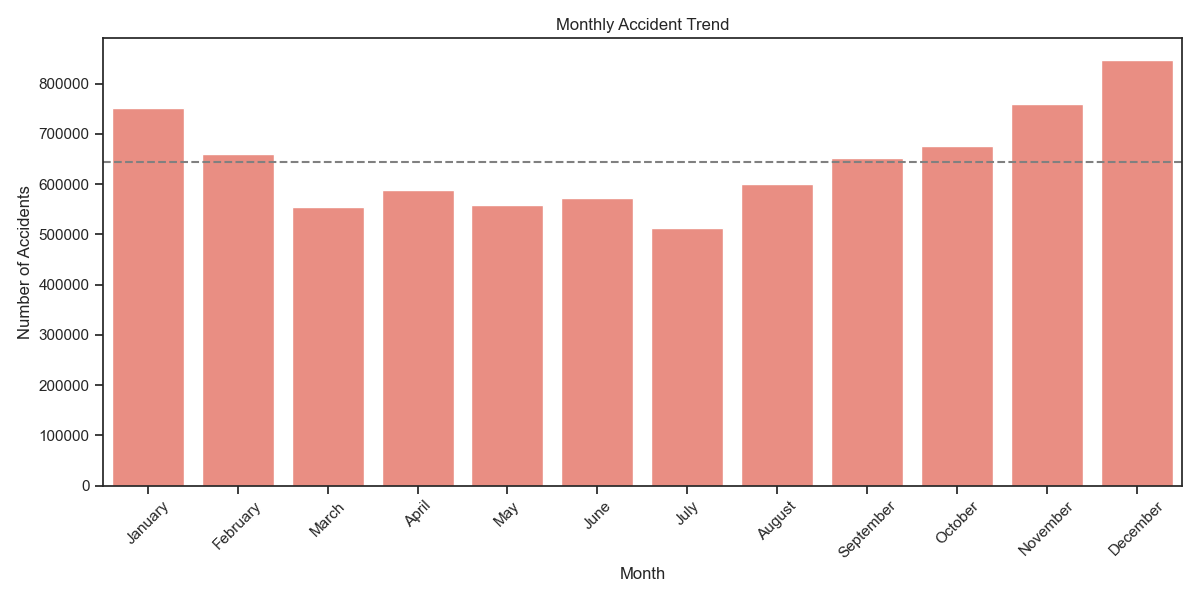

In [130]:
display(Image(filename="plots/time/monthly_trend.png"))


### Day of Week Trend

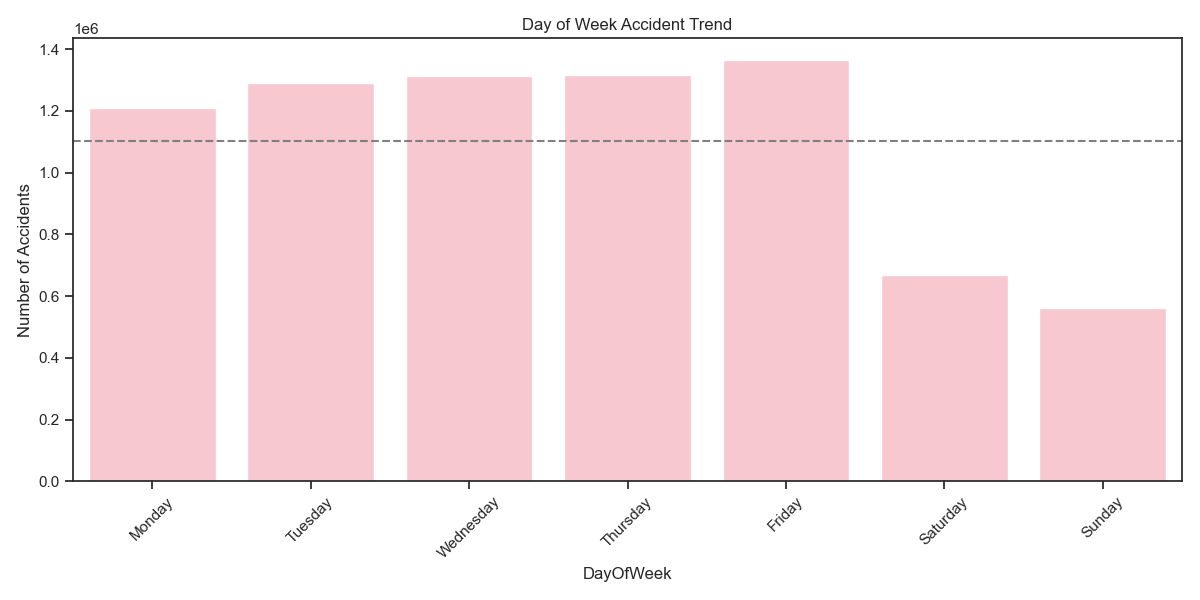

In [131]:
display(Image(filename="plots/time/dayofweek_trend.png"))


### Hourly Trend

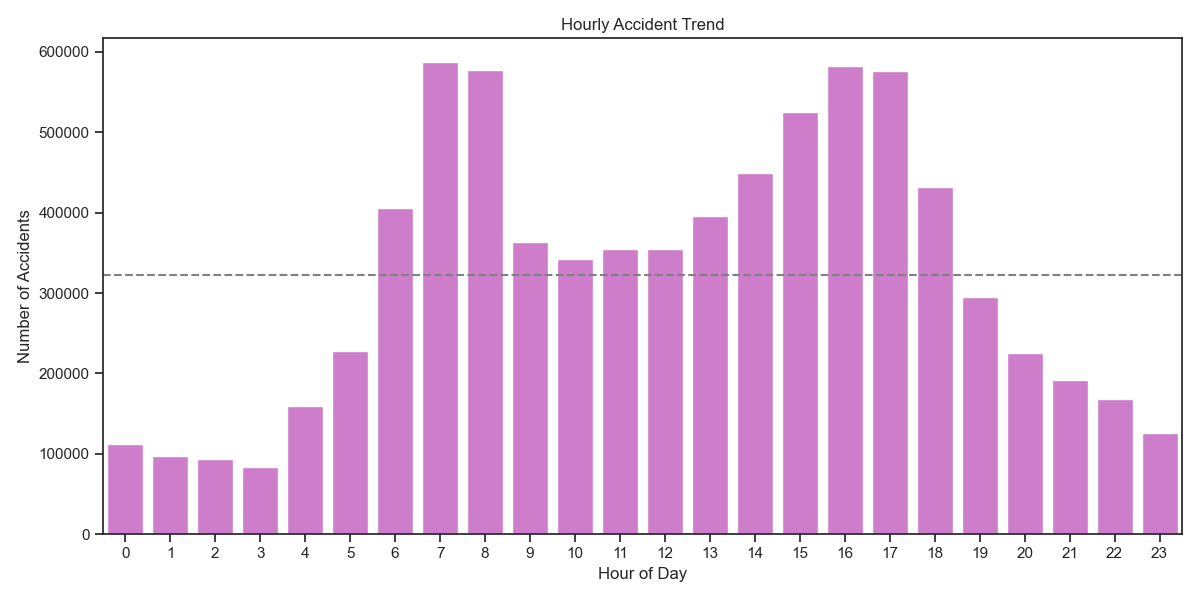

In [132]:
display(Image(filename="plots/time/hourly_trend.png"))


### 📊 Yearly Accident Trend by Severity
This **stacked bar chart** presents the number of traffic accidents per year, segmented by severity levels. A **steady increase in total accidents** is observed from 2016 to 2022, indicating a rising safety concern. Interestingly, while **Severity 2** (less serious) accidents have been increasing, **Severity 3** accidents have shown a **declining trend**. This shift in severity distribution may reflect changes in reporting practices, road conditions, or mitigation strategies. Overall, **traffic accidents have more than doubled since 2017**, making this trend a critical area for intervention.

---

### 🍂 Seasonal Accident Trend by Severity
This visualization highlights how accidents vary by **season and year**, with severity included. **Fall and Winter consistently record the highest accident volumes**, likely due to adverse weather conditions such as rain, snow, and reduced daylight. However, in **2022**, a notable **spike during Spring** raises potential concerns. This seasonal rise should be monitored by policymakers, as it could signal emerging risks related to post-winter travel patterns or behavioral changes.

---

### 📅 Monthly Accident Trend
When broken down by month, **November and December** show the **highest number of accidents**, while **July records the fewest**. This pattern aligns with the **holiday season** when roads are busier and weather conditions may deteriorate. Increased travel, slippery roads, and lower visibility likely contribute to the spike. Understanding these peaks is useful for designing **seasonal road safety campaigns and emergency response preparedness**.

---

### 📆 Day of Week Accident Trend
This bar chart clearly shows that **weekdays have significantly more accidents than weekends**, with **Friday being the most accident-prone day**. The reduction on **Saturdays and Sundays** suggests a strong link between commuting behavior and accident frequency. This insight highlights the need for **weekday-focused traffic management and driver safety interventions**, especially during rush hours.

---

### 🕒 Hourly Accident Trend
The hourly trend reveals **two major peaks**—between **6–8 AM** and **3–5 PM**, which correspond to typical **commuting hours**. These time slots see heightened activity due to people **traveling to and from work**, leading to more congestion and risk. These findings underscore the importance of targeting **commute-time road safety policies**, such as traffic calming, public transit expansion, or staggered work hours.


## Assignment 2: Most Common Weather Conditions per State

**Objective:**  
This task aims to identify the most frequently observed weather conditions associated with traffic accidents across different US states.

**Approach:**  
- We use the **full US Accidents dataset** to ensure a comprehensive analysis.
- To keep the analysis scalable and insightful, we:
  - Focus on the **top 10 states** with the highest number of accidents.
  - For each of these states, identify their **top 3 most common weather conditions**.
  - Visualize the results using **subplots of bar charts**, where each subplot corresponds to one state and shows the frequency of its top weather conditions.

This method allows us to compare weather condition patterns across high-accident states without overwhelming the visualization.


/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_68557/3514709595.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='Weather_Condition', y='Counts', ax=axes[i], palette='pastel')
/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_68557/3514709595.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='Weather_Condition', y='Counts', ax=axes[i], palette='pastel')
/var/folders/gw/b7p_041n59l085x02_97z5nm0000gp/T/ipykernel_68557/3514709595.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data

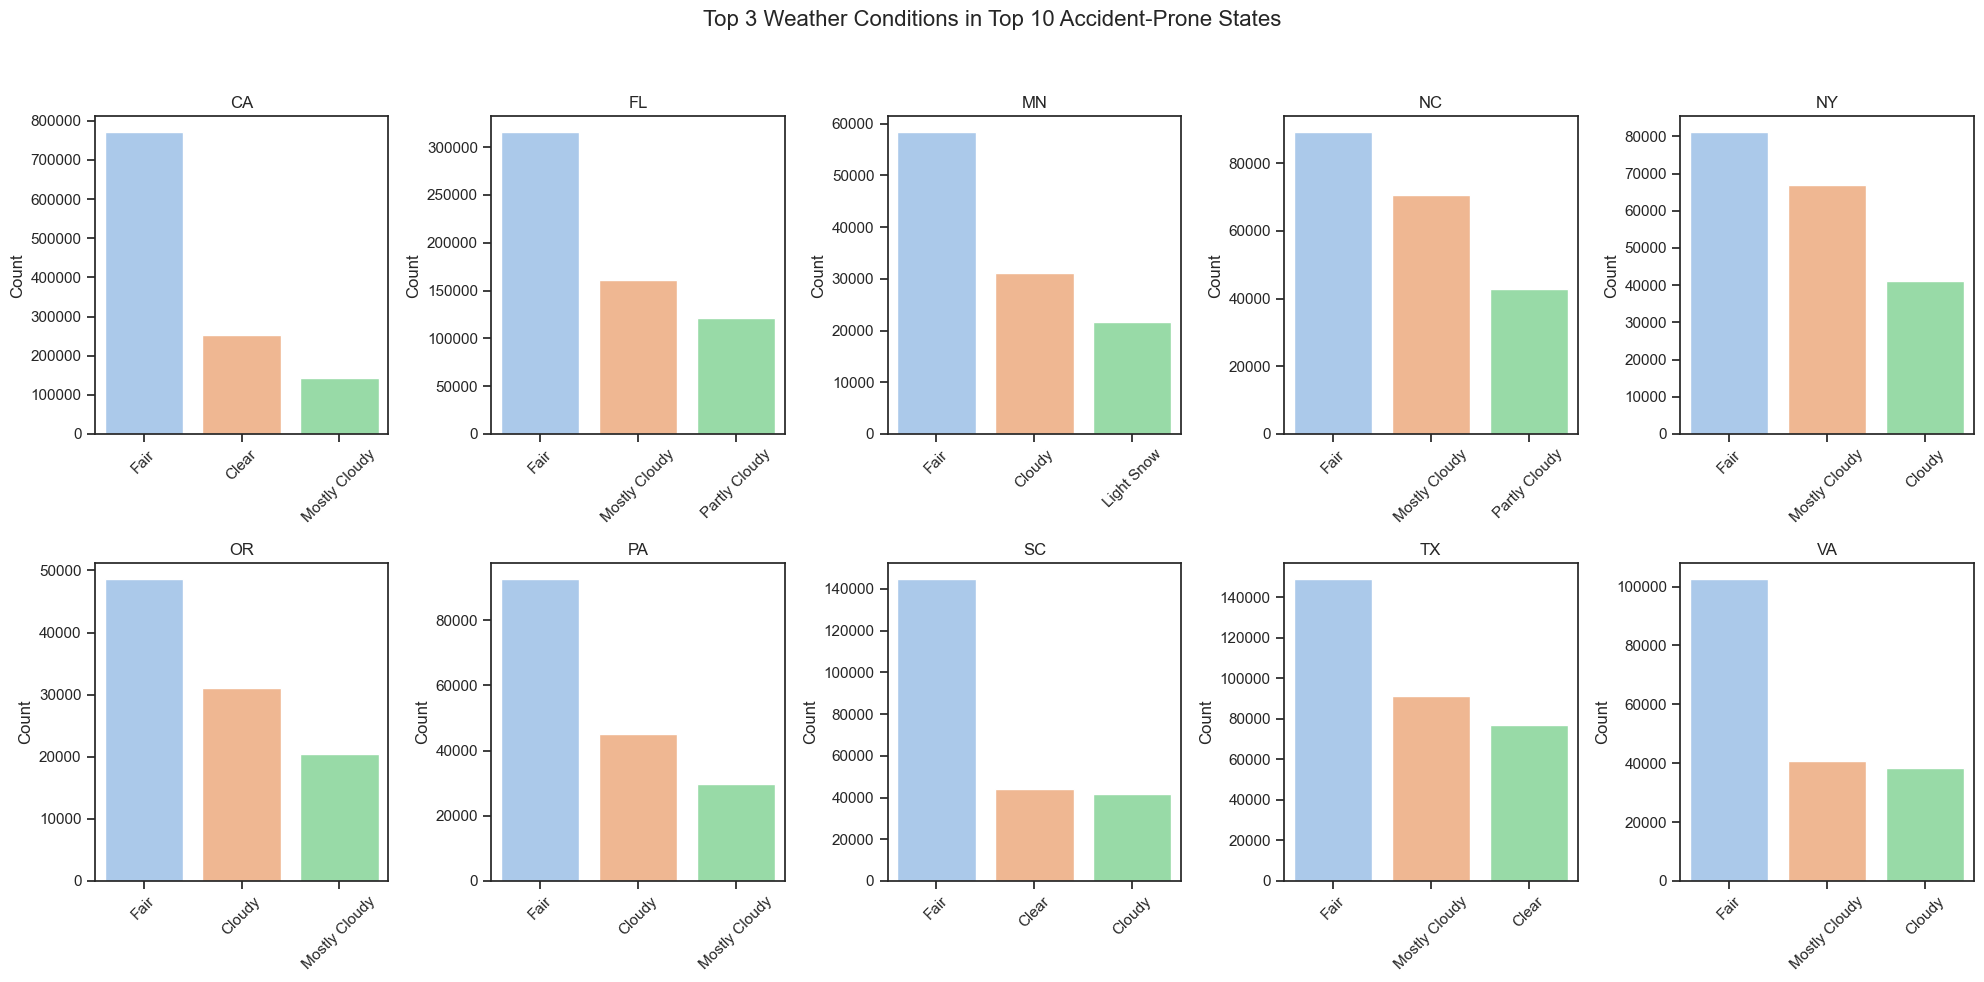

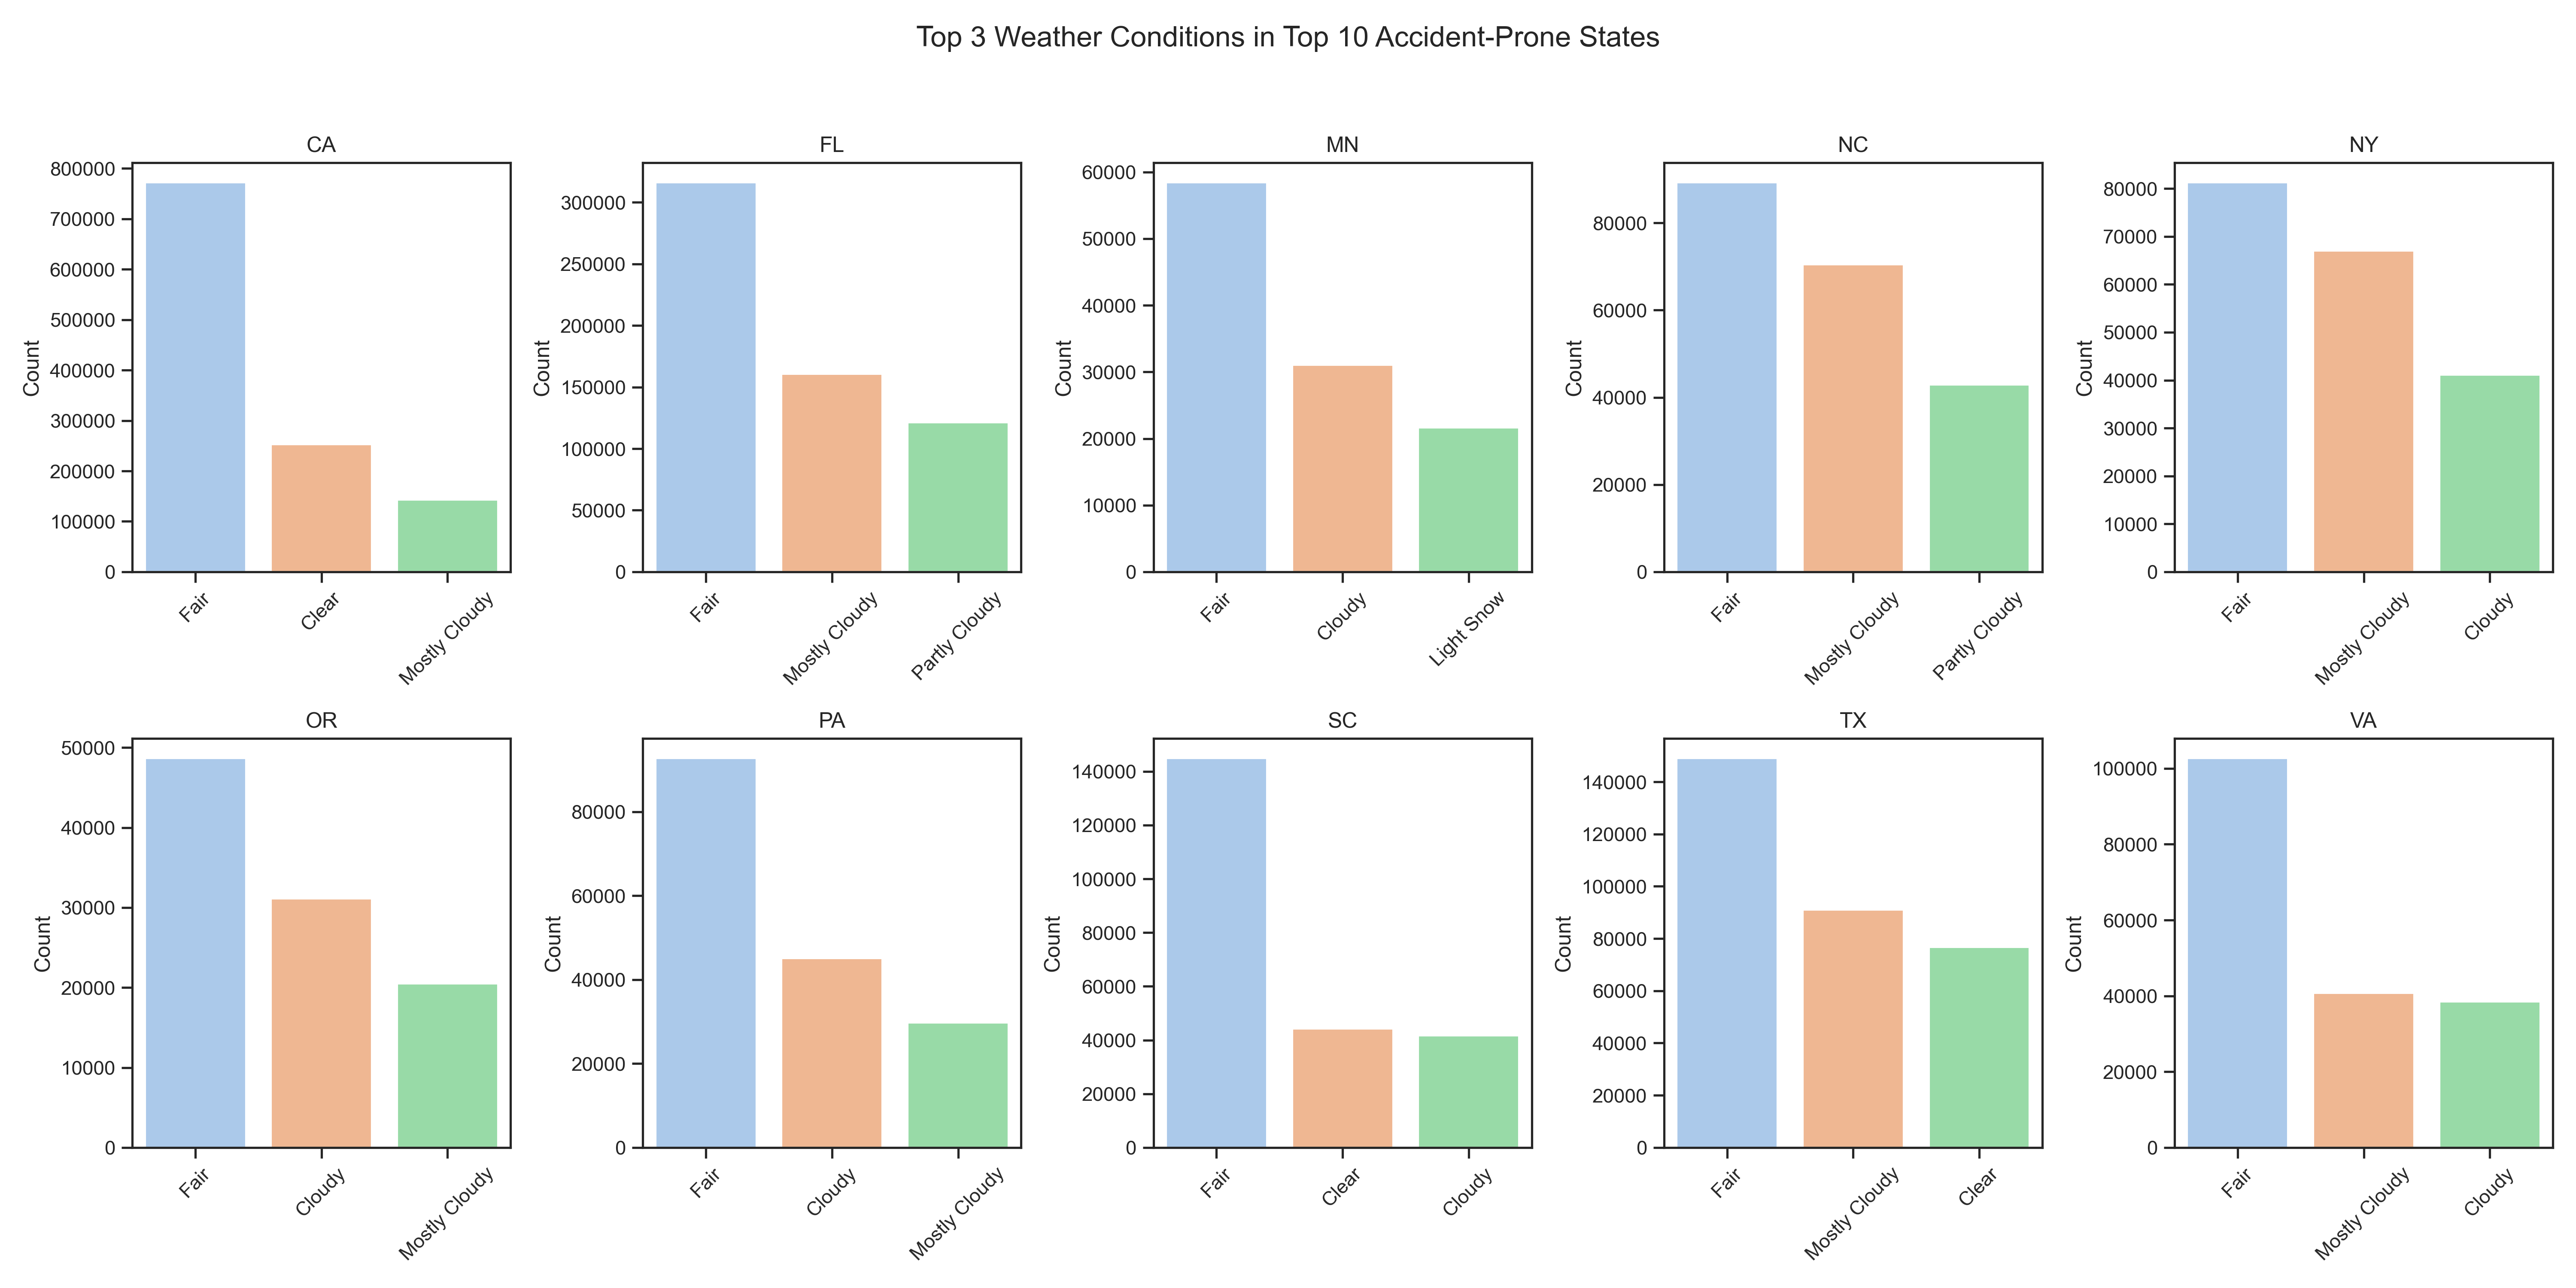

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import Image, display

# === Ensure output directory ===
os.makedirs("plots/weather", exist_ok=True)

# === Step 1: Identify top 10 states by accident count ===
top_states = df_full['State'].value_counts().nlargest(10).index

# === Step 2: Filter and group weather condition counts per state ===
top_weather = (
    df_full[df_full['State'].isin(top_states)]
    .groupby(['State', 'Weather_Condition'])
    .size()
    .reset_index(name='Counts')
)

# === Step 3: For each state, get top 3 weather conditions ===
top_weather = (
    top_weather.sort_values(['State', 'Counts'], ascending=[True, False])
    .groupby('State')
    .head(3)
)

# === Step 4: Plot each state's top weather conditions as a subplot ===
states = top_weather['State'].unique()
num_states = len(states)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axes = axes.flatten()

for i, state in enumerate(states):
    subset = top_weather[top_weather['State'] == state]
    sns.barplot(data=subset, x='Weather_Condition', y='Counts', ax=axes[i], palette='pastel')
    axes[i].set_title(f'{state}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Remove extra subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Top 3 Weather Conditions in Top 10 Accident-Prone States", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# === Step 5: Save and display the plot ===
output_path = "plots/weather/most_common_conditions_by_state.png"
plt.savefig(output_path, dpi=300)
plt.show()

# === Step 6: Display in notebook ===
display(Image(filename=output_path))


### 📌 Observation: Most Common Weather Conditions in Top 10 Accident-Prone States

This visualization presents the **top 3 most frequent weather conditions** associated with accidents in each of the **top 10 accident-prone states** in the U.S.

**Key Observations:**

- Across all 10 states, the most frequent condition is consistently **"Fair"** weather. This may seem counterintuitive but suggests that **accidents are not always driven by extreme weather**, and instead may be influenced by human behavior, traffic density, or road infrastructure even under clear skies.
  
- The second and third most common conditions vary by state:
  - **"Mostly Cloudy"** and **"Clear"** conditions often appear next in line, particularly in **California, Florida, Texas, and Virginia**, reinforcing the above point that **moderate weather dominates accident conditions**.
  - States like **Minnesota (MN)** and **Oregon (OR)** show higher rankings for **"Cloudy"** and **"Light Snow"**, reflecting their regional climates.
  
- Notably, **"Light Snow"** only appears in northern states such as **MN**, underscoring **regional weather impacts** on accident profiles.

This analysis indicates that while hazardous conditions like snow or fog are certainly risk factors, **the majority of accidents still occur in relatively normal weather**. This insight is critical for designing **year-round traffic safety campaigns** that go beyond just extreme weather alerts.


### 🔍 Summary of Key Findings


1. **Total U.S. Traffic Accidents (2016–2023):** Over **7.7 million** reported accidents, with a steady **year-over-year increase** in volume until 2022, followed by a **notable drop in 2023**.

2. **Severity Trends:** The **average severity decreased** slightly over time—from **2.38 in 2016** to **2.07 in 2022**, showing a **rise in minor accidents** relative to serious ones.

3. **Hourly Patterns:** Accidents peak during **commute hours**, especially **7–8 AM** and **3–5 PM**, and drop sharply between **2–5 AM**.

4. **Day-of-Week Trend:** **Weekdays** (especially **Monday to Friday**) show significantly **higher accident counts** than weekends—linked to regular commute and work travel.

5. **Monthly & Seasonal Trends:** Accidents are highest in **November and December**, with **Fall and Winter** consistently being the **riskiest seasons** across years.

6. **Geographic Hotspots:** **California, Florida, and Texas** dominate in total accident counts. **Los Angeles**, **Miami**, and **Houston** are top-ranking cities.

7. **Weather Conditions:** Surprisingly, most accidents occur in **“Fair” or “Clear” weather**, suggesting **non-weather factors** (like human error, traffic congestion, or road design) are key drivers.

8. **Humidity & Visibility Effects:** Accidents were more frequent in conditions with **higher humidity** and **lower visibility**, suggesting a need for **weather-aware driving policies**, even in non-extreme conditions.

9. **Wind Speed & Temperature:** Although wind speed and temperature had **limited direct correlation** with severity, a few states did exhibit **slight deviations** from their annual climate norms during peak accident periods.

10. **Traffic Signal and Junction-Related Accidents:** A substantial number of accidents occurred near **traffic signals**, **junctions**, and **intersections**, highlighting these as **critical risk zones** for urban planning.

11. **Geospatial Distribution:** The **heatmaps** revealed a clear concentration of accidents along **major highways and city clusters**—particularly in the **East Coast**, **West Coast**, and **Texas region**—indicating that **densely populated urban corridors** are more prone to frequent incidents.

12. **Severity Mapping:** **Lower severity accidents (1–2)** are densely clustered around **urban areas** and **major interstate highways**, while **higher severity accidents (3–4)** are more dispersed but concentrated in parts of the **Midwest**, **Southeast**, and **East Coast**, especially near **highway junctions**—suggesting that severity is influenced by **road type**, **travel speed**, and **emergency response access**.


13. **Traffic-Related Boolean Indicators:** Accidents happens **nearby traffic signals, crossings and junctions**. Places with lesser effects are the stop signs, stations and amenities. Further research should be done near these areas to find out why accidents happens near these areas.


### ✅ Recommendations

1. **Target Commute Hours:** Prioritize **traffic control and driver awareness** between **7–9 AM** and **3–6 PM** to reduce accident spikes.

2. **Focus on High-Risk Days & Seasons:** Strengthen road safety messaging and enforcement on **weekdays**, especially in **Fall and Winter**, and during the **holiday months**.

3. **City-Specific Measures:** Invest in **localized safety improvements** in cities like **Los Angeles, Miami, and Houston**, which consistently rank high in incident counts.

4. **Explore 2023 Decline:** Investigate the factors behind the **sharp drop in 2023**. If tied to policy or infrastructure changes, **scale those practices nationwide**.

5. **Improve Safety Under Normal Conditions:** Since most accidents happen in good weather, shift the public narrative from “bad weather caution” to **everyday safe driving habits**.

6. **Sustain Severity Reduction Efforts:** Continue promoting **seatbelt usage, speed regulation, and responsive emergency services** to keep lowering the impact of accidents.

7. **Deploy Weather-Aware Alerts:** Implement **real-time driving alerts** or automated signage during periods of **high humidity or low visibility**, especially in regions with frequent such conditions.

8. **Refine Urban Traffic Design:** Enhance **signal timing**, **intersection design**, and **pedestrian zone management** in accident-prone urban corridors to reduce collisions near **traffic signals and crossings**.

9. **Regional Risk Management:** Direct **state-level safety investments** toward **high-density clusters** on the East and West Coasts and in Texas, where both volume and severity of accidents are elevated.

10. **Targeted Patrol on High-Severity Routes:** Since **severe accidents** occur more often on **less dense, intercity highways**, consider deploying **increased highway patrol and emergency response** coverage on those routes.

11. **Infrastructure-Based Interventions:** Prioritize accident-prevention infrastructure like **reflective lane markings**, **roundabouts**, and **speed-reducing designs** in areas with high occurrence near **junctions and traffic signals**.

12. **Integrate Environmental Data in City Planning:** Encourage municipalities to incorporate **humidity, wind, and visibility data** into **smart city traffic systems**, enhancing predictive risk modeling and accident prevention.

